# Final full idea put together



# Load Data

In [4]:
import numpy as np
import pandas as pd
import json
import sys
import logging
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, r2_score, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
import shap

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')


###############################################################################
# HELPER FUNCTION FOR DEBUG OUTPUTS
###############################################################################
def _print_debug_info(step_name, df, new_columns=None, debug=False):
    """
    Prints debug information about a DataFrame after a processing step.
    
    When debug=True, prints:
      - The step name.
      - The DataFrame shape.
      - If new_columns is provided (a list of column names), prints for each:
          • Data type and a sample of unique values (up to 5).
    When debug=False, prints a single-line message indicating step completion.
    """
    if debug:
        logging.info(f"Step [{step_name}]: DataFrame shape = {df.shape}")
        if new_columns:
            logging.info(f"New columns added: {new_columns}")
            for col in new_columns:
                sample = df[col].dropna().unique()[:5]
                logging.info(f" - {col}: dtype={df[col].dtype}, sample values={sample}")
    else:
        logging.info(f"Step [{step_name}] completed.")


###############################################################################
# FUNCTION DEFINITIONS
###############################################################################
def load_data(csv_path, json_path, participant_id='P0001', debug=False):
    """
    Loads the main dataset and participant information, then merges them.
    
    Parameters:
      - csv_path (str): Path to the main CSV file.
      - json_path (str): Path to the participant information JSON file.
      - participant_id (str): Participant identifier.
      - debug (bool): If True, prints detailed debug info.
    
    Returns:
      - data (pd.DataFrame): Merged DataFrame.
    """
    # Load main dataset
    try:
        data = pd.read_csv(csv_path)
        logging.info(f"Loaded data from {csv_path} with shape {data.shape}")
    except FileNotFoundError:
        logging.error(f"File not found: {csv_path}")
        sys.exit(1)
    except Exception as e:
        logging.error(f"Error loading {csv_path}: {e}")
        sys.exit(1)
    
    data['participant_id'] = participant_id
    logging.info(f"Added 'participant_id' column with value '{participant_id}'")
    
    # Load participant info
    try:
        with open(json_path, 'r') as file:
            participant_info = json.load(file)
        participant_df = pd.DataFrame([participant_info])
        logging.info(f"Loaded participant information from {json_path}")
    except FileNotFoundError:
        logging.error(f"File not found: {json_path}")
        sys.exit(1)
    except json.JSONDecodeError:
        logging.error(f"Invalid JSON format in {json_path}")
        sys.exit(1)
    except Exception as e:
        logging.error(f"Error loading {json_path}: {e}")
        sys.exit(1)
    
    data = pd.merge(data, participant_df, on='participant_id', how='left')
    logging.info(f"Merged participant data. New shape: {data.shape}")
    _print_debug_info("load_data", data, debug=debug)
    return data

def calculate_joint_angles(df, connections, debug=False):
    """
    Calculates joint angles from coordinate data using vector mathematics.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing joint coordinates.
        connections (list): Joint connections defining biomechanical segments.
        debug (bool): Enable debug logging.
        
    Returns:
        df (pd.DataFrame): Updated DataFrame with new angle columns.
    """
    angle_columns = []
    
    # Define angle calculation points for key joints
    # Note: The new "KNEE" definition uses hip, knee, and ankle as the points.
    angle_definitions = {
        'SHOULDER': {
            'left': ['L_HIP', 'L_SHOULDER', 'L_ELBOW'],
            'right': ['R_HIP', 'R_SHOULDER', 'R_ELBOW']
        },
        'HIP': {
            'left': ['L_SHOULDER', 'L_HIP', 'L_KNEE'],
            'right': ['R_SHOULDER', 'R_HIP', 'R_KNEE']
        },
        'KNEE': {
            'left': ['L_HIP', 'L_KNEE', 'L_ANKLE'],
            'right': ['R_HIP', 'R_KNEE', 'R_ANKLE']
        },
        'ANKLE': {
            'left': ['L_KNEE', 'L_ANKLE', 'L_5THTOE'],
            'right': ['R_KNEE', 'R_ANKLE', 'R_5THTOE']
        }
    }

    for joint, sides in angle_definitions.items():
        for side in ['left', 'right']:
            points = sides[side]
            prefix = 'L' if side == 'left' else 'R'
            
            # Build list of required coordinate columns for this calculation
            required_cols = []
            for point in points:
                required_cols += [f'{point}_x', f'{point}_y', f'{point}_z']
                
            if all(col in df.columns for col in required_cols):
                # Calculate the vectors needed for the angle
                vec1 = df[[f'{points[0]}_x', f'{points[0]}_y', f'{points[0]}_z']].values - \
                       df[[f'{points[1]}_x', f'{points[1]}_y', f'{points[1]}_z']].values
                vec2 = df[[f'{points[2]}_x', f'{points[2]}_y', f'{points[2]}_z']].values - \
                       df[[f'{points[1]}_x', f'{points[1]}_y', f'{points[1]}_z']].values

                # Compute the dot product and the norms of the vectors
                dot_product = np.sum(vec1 * vec2, axis=1)
                norm_product = np.linalg.norm(vec1, axis=1) * np.linalg.norm(vec2, axis=1)
                
                # Compute the angle (in degrees) and add a small epsilon to avoid division by zero
                angles = np.degrees(np.arccos(dot_product / (norm_product + 1e-8)))
                
                col_name = f'{prefix}_{joint}_angle'
                df[col_name] = angles
                angle_columns.append(col_name)
                
                if debug:
                    logging.info(f"Calculated {col_name} with mean: {angles.mean():.2f}°")
            else:
                logging.warning(f"Missing coordinates for {prefix}_{joint} angle calculation")

    _print_debug_info("calculate_joint_angles", df, new_columns=angle_columns, debug=debug)
    return df



def prepare_joint_features(data, debug=False, group_trial=False, group_shot_phase=False):
    """
    Aggregates joint-level energy and power, creates additional biomechanical features,
    and adds new features:
      - energy_acceleration: instantaneous rate of change of joint_energy.
      - ankle_power_ratio: ratio of left to right ankle ongoing power.
      - Additional asymmetry metrics.
      - Power ratios for all joint pairs.
      - Side-Specific Range-of-Motion (ROM) metrics (ROM, deviation, and binary extreme flag).
      - Removal of the wrist_angle_release column if present.
      
    NEW GROUPING FEATURE (optional):
      - If group_trial is True, computes aggregated trial-level features (e.g., trial mean exhaustion and total joint energy)
        and merges them into the DataFrame.
      - If group_shot_phase is True, and if the column 'shooting_phases' exists, computes shot-phase level aggregates
        (based on both 'trial_id' and 'shooting_phases') and merges them in.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - debug (bool): If True, prints detailed debug outputs.
      - group_trial (bool): If True, add trial-level aggregated features.
      - group_shot_phase (bool): If True, add shot-phase-level aggregated features.
    
    Returns:
      - data (pd.DataFrame): Updated DataFrame with new features and, optionally, grouping-based extra columns.
    """
    step = "prepare_joint_features"
    new_cols = []
    connections = [
        ("R_EYE", "L_EYE"), ("R_EYE", "NOSE"), ("L_EYE", "NOSE"),
        ("R_EYE", "R_EAR"), ("L_EYE", "L_EAR"), ("R_SHOULDER", "L_SHOULDER"),
        ("R_SHOULDER", "R_ELBOW"), ("L_SHOULDER", "L_ELBOW"), ("R_ELBOW", "R_WRIST"),
        ("L_ELBOW", "L_WRIST"), ("R_SHOULDER", "R_HIP"), ("L_SHOULDER", "L_HIP"),
        ("R_HIP", "L_HIP"), ("R_HIP", "R_KNEE"), ("L_HIP", "L_KNEE"),
        ("R_KNEE", "R_ANKLE"), ("L_KNEE", "L_ANKLE"), ("R_WRIST", "R_1STFINGER"),
        ("R_WRIST", "R_5THFINGER"), ("L_WRIST", "L_1STFINGER"), ("L_WRIST", "L_5THFINGER"),
        ("R_ANKLE", "R_1STTOE"), ("R_ANKLE", "R_5THTOE"), ("L_ANKLE", "L_1STTOE"),
        ("L_ANKLE", "L_5THTOE"), ("R_ANKLE", "R_CALC"), ("L_ANKLE", "L_CALC"),
        ("R_1STTOE", "R_5THTOE"), ("L_1STTOE", "L_5THTOE"), ("R_1STTOE", "R_CALC"),
        ("L_1STTOE", "L_CALC"), ("R_5THTOE", "R_CALC"), ("L_5THTOE", "L_CALC"),
        ("R_1STFINGER", "R_5THFINGER"), ("L_1STFINGER", "L_5THFINGER")
    ]
    # Compute joint angles first.
    data = calculate_joint_angles(data, connections, debug=debug)
    
    # Rename participant anthropometrics if available.
    if 'height_in_meters' in data.columns and 'weight__in_kg' in data.columns:
        data['player_height_in_meters'] = data['height_in_meters']
        data['player_weight__in_kg'] = data['weight__in_kg']
        data.drop(['height_in_meters', 'weight__in_kg'], axis=1, inplace=True, errors='ignore')
        new_cols.extend(['player_height_in_meters', 'player_weight__in_kg'])
        logging.info("Renamed participant anthropometrics.")
    else:
        logging.warning("Participant anthropometric columns not found during renaming.")

    # Identify joint energy and power columns.
    joint_energy_columns = [col for col in data.columns if '_energy' in col and not ('by_trial' in col or 'overall' in col)]
    print("Joint energy columns: ", joint_energy_columns)
    joint_power_columns = [col for col in data.columns if '_ongoing_power' in col]
    print("Joint power columns: ", joint_power_columns)
    print("All angle columns: ", [col for col in data.columns if 'angle' in col])
    logging.info(f"Identified {len(joint_energy_columns)} joint energy and {len(joint_power_columns)} joint power columns.")
    if not joint_energy_columns:
        logging.error("No joint energy columns found. Check naming conventions.")
        sys.exit(1)
    if not joint_power_columns:
        logging.error("No joint power columns found. Check naming conventions.")
        sys.exit(1)
    
    # Create aggregated columns.
    data['joint_energy'] = data[joint_energy_columns].sum(axis=1)
    data['joint_power'] = data[joint_power_columns].sum(axis=1)
    new_cols.extend(['joint_energy', 'joint_power'])
    logging.info("Created aggregated 'joint_energy' and 'joint_power'.")

    # --- NEW FEATURE: Energy Acceleration ---
    if 'continuous_frame_time' in data.columns:
        time_diff = data['continuous_frame_time'].diff().replace(0, 1e-6)  # Avoid division by zero
        data['energy_acceleration'] = data['joint_energy'].diff() / time_diff
        data['energy_acceleration'] = data['energy_acceleration'].replace([np.inf, -np.inf], np.nan)
        new_cols.append('energy_acceleration')
        logging.info("Created 'energy_acceleration' as derivative of joint_energy over time.")
    else:
        logging.error("Missing 'continuous_frame_time' for energy_acceleration calculation.")
        sys.exit(1)
    
    # --- NEW FEATURE: Ankle Power Ratio ---
    if 'L_ANKLE_ongoing_power' in data.columns and 'R_ANKLE_ongoing_power' in data.columns:
        data['ankle_power_ratio'] = data['L_ANKLE_ongoing_power'] / (data['R_ANKLE_ongoing_power'] + 1e-6)
        new_cols.append('ankle_power_ratio')
        logging.info("Created 'ankle_power_ratio' feature comparing left to right ankle ongoing power.")
    else:
        logging.warning("Ankle ongoing power columns not found; 'ankle_power_ratio' not created.")

    # --- NEW FEATURES: Additional Asymmetry Metrics ---
    additional_asymmetry_joints = ['hip', 'ankle', 'wrist', 'elbow', 'knee', '1stfinger', '5thfinger']
    for joint in additional_asymmetry_joints:
        left_col = f"L_{joint.upper()}_energy"
        right_col = f"R_{joint.upper()}_energy"
        if left_col in data.columns and right_col in data.columns:
            col_name = f"{joint}_asymmetry"
            data[col_name] = np.abs(data[left_col] - data[right_col])
            new_cols.append(col_name)
            logging.info(f"Created asymmetry feature: {col_name}")
        else:
            logging.warning(f"Columns {left_col} and/or {right_col} not found; skipping {joint}_asymmetry.")

    # --- NEW FEATURES: Power Ratios for All Joints ---
    joints_for_power_ratio = additional_asymmetry_joints.copy()
    if 'knee' not in joints_for_power_ratio:
        joints_for_power_ratio.append('knee')
    for joint in joints_for_power_ratio:
        if joint == 'foot':
            left_col = 'left_foot_power'
            right_col = 'right_foot_power'
        else:
            left_col = f"L_{joint.upper()}_ongoing_power"
            right_col = f"R_{joint.upper()}_ongoing_power"
        logging.debug(f"Expecting power columns: {left_col} and {right_col}")
        if left_col in data.columns and right_col in data.columns:
            ratio_col = f"{joint}_power_ratio"
            data[ratio_col] = data[left_col] / (data[right_col] + 1e-6)
            new_cols.append(ratio_col)
            logging.info(f"Created power ratio feature: {ratio_col} using columns {left_col} and {right_col}")
        else:
            logging.warning(f"Columns {left_col} and/or {right_col} not found; skipping {joint}_power_ratio.")

    # --- NEW FEATURES: Side-Specific Range-of-Motion (ROM) Metrics ---
    rom_joints = {
        'KNEE': {'min': 120, 'max': 135},
        'SHOULDER': {'min': 0,  'max': 150},
        'HIP': {'min': 0,  'max': 120},
        'ANKLE': {'min': 0,  'max': 20},
        'WRIST': {'min': 0,  'max': 80}
    }
    for joint, thresholds in rom_joints.items():
        for side in ['L', 'R']:
            angle_col = f"{side}_{joint}_angle"
            if angle_col in data.columns:
                rom_col = f"{side}_{joint}_ROM"
                data[rom_col] = data.groupby('trial_id')[angle_col].transform(lambda x: x.max() - x.min())
                new_cols.append(rom_col)
                logging.info(f"Computed ROM for {side} {joint} as {rom_col}")

                deviation_col = f"{side}_{joint}_ROM_deviation"
                normal_min = thresholds['min']
                normal_max = thresholds['max']
                data[deviation_col] = np.maximum(0, normal_min - data[rom_col]) + np.maximum(0, data[rom_col] - normal_max)
                new_cols.append(deviation_col)
                logging.info(f"Computed ROM deviation for {side} {joint} as {deviation_col}")

                extreme_col = f"{side}_{joint}_ROM_extreme"
                data[extreme_col] = ((data[rom_col] < normal_min) | (data[rom_col] > normal_max)).astype(int)
                new_cols.append(extreme_col)
                logging.info(f"Created binary flag for {side} {joint} ROM extremes: {extreme_col}")
            else:
                logging.info(f"Angle column '{angle_col}' not found; skipping ROM metrics for {side} {joint}.")

    # --- Removal of Non-Contributing Features ---
    if 'wrist_angle_release' in data.columns:
        data.drop(columns=['wrist_angle_release'], inplace=True)
        logging.info("Dropped 'wrist_angle_release' column as it is not helpful for the model.")
    
    # --- Sort Data ---
    if 'continuous_frame_time' in data.columns and 'participant_id' in data.columns:
        data.sort_values(by=['participant_id', 'continuous_frame_time'], inplace=True)
        data.reset_index(drop=True, inplace=True)
        logging.info("Sorted data by 'participant_id' and 'continuous_frame_time'.")
    else:
        logging.error("Missing required columns for sorting ('participant_id', 'continuous_frame_time').")
        sys.exit(1)

    # --- Create Exhaustion Rate ---
    if 'by_trial_exhaustion_score' in data.columns and 'by_trial_time' in data.columns:
        data['exhaustion_rate'] = data['by_trial_exhaustion_score'].diff() / data['by_trial_time'].diff()
        print("print all the columns with by_trial_exhaustion_score: ", [col for col in data.columns if 'by_trial_exhaustion_score' in col])
        new_cols.append('exhaustion_rate')
        logging.info("Created 'exhaustion_rate' feature.")
    else:
        logging.error("Missing columns for 'exhaustion_rate' calculation.")
        sys.exit(1)
    
    # --- Create Simulated Heart Rate ---
    if 'by_trial_exhaustion_score' in data.columns and 'joint_energy' in data.columns:
        data['simulated_HR'] = 60 + (data['by_trial_exhaustion_score'] * 1.5) + (data['joint_energy'] * 0.3)
        new_cols.append('simulated_HR')
        logging.info("Created 'simulated_HR' feature.")
    else:
        logging.error("Missing columns for 'simulated_HR' calculation.")
        sys.exit(1)
    
    # ----- NEW: Add Grouping-Based Aggregation Features -----
    # Trial-level aggregations
    if group_trial:
        # For example, compute the trial mean exhaustion score and trial total joint energy.
        trial_aggs = data.groupby('trial_id').agg({
            'by_trial_exhaustion_score': 'mean',
            'joint_energy': 'sum'
        }).rename(columns={
            'by_trial_exhaustion_score': 'trial_mean_exhaustion',
            'joint_energy': 'trial_total_joint_energy'
        }).reset_index()
        data = data.merge(trial_aggs, on='trial_id', how='left')
        new_cols.extend(['trial_mean_exhaustion', 'trial_total_joint_energy'])
        logging.info("Added trial-level aggregated features: trial_mean_exhaustion, trial_total_joint_energy.")

    # Shot-phase-level aggregations (requires shooting_phases column)
    if group_shot_phase:
        if 'shooting_phases' in data.columns:
            shot_aggs = data.groupby(['trial_id', 'shooting_phases']).agg({
                'by_trial_exhaustion_score': 'mean',
                'joint_energy': 'sum'
            }).rename(columns={
                'by_trial_exhaustion_score': 'shot_phase_mean_exhaustion',
                'joint_energy': 'shot_phase_total_joint_energy'
            }).reset_index()
            data = data.merge(shot_aggs, on=['trial_id', 'shooting_phases'], how='left')
            new_cols.extend(['shot_phase_mean_exhaustion', 'shot_phase_total_joint_energy'])
            logging.info("Added shot-phase-level aggregated features: shot_phase_mean_exhaustion, shot_phase_total_joint_energy.")
        else:
            logging.warning("Column 'shooting_phases' not found; skipping shot-phase aggregation features.")

    _print_debug_info(step, data, new_columns=new_cols, debug=debug)
    return data



def summarize_data(data, groupby_cols, lag_columns=None, rolling_window=3, 
                   agg_columns=None, phase_list=None, global_lag=False, debug=False):
    """
    Summarize the dataset with advanced feature engineering by grouping on specified columns.
    
    This function computes:
      - The mean of selected numeric columns (except for 'injury_risk', which is aggregated using max).
      - The standard deviation of these columns (with a '_std' suffix).
      - The count of records in each group.
      - A computed duration (e.g., frame_count * 0.33 seconds if applicable).
    
    Additionally, for the columns specified in lag_columns, it computes:
      - A lag feature.
      - A delta feature (current value minus the lag).
      - A rolling average (using the specified rolling window).
    
    If a phase_list is provided and 'shooting_phases' is in groupby_cols,
    the function forces the final DataFrame to include all combinations of trial_id and
    the specified phases (Cartesian product).
    
    Parameters:
        global_lag (bool): If True, lag is computed over the entire DataFrame (across all trials);
                           if False, lag is computed within groups defined by the last groupby column.
    
    Returns:
        pd.DataFrame: Aggregated DataFrame with additional lag features.
    """
    import pandas as pd
    import numpy as np

    # 1) Set default aggregation and lag columns if not provided.
    default_agg_columns = [
        'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy',
        'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_energy', 'R_KNEE_energy',
        'L_HIP_energy', 'R_HIP_energy',
        'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power',
        'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power',
        'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power',
        'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry',
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle',
        'L_KNEE_angle', 'R_KNEE_angle',
        'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM',
        'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM',
        'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk',
        'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'simulated_HR',
        'player_height_in_meters', 'player_weight__in_kg'
    ]
    default_lag_columns = [
        'joint_energy', 'joint_power',
        'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        'elbow_asymmetry', 'wrist_asymmetry',
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle',
        'exhaustion_rate', 'by_trial_exhaustion_score', 'simulated_HR'
    ]
    if agg_columns is None:
        agg_columns = default_agg_columns.copy()
    if lag_columns is None:
        lag_columns = default_lag_columns.copy()

    if debug:
        print("\n--- DEBUG: summarize_data START ---")
        print(f"Initial data shape: {data.shape}")
        print(f"Grouping by: {groupby_cols}")
        print(f"Aggregation columns: {agg_columns}")
        print(f"Lag columns: {lag_columns}")
        print(f"Rolling window: {rolling_window}")
        print(f"Global lag: {global_lag}")
        if phase_list is not None:
            print(f"Forced phase list: {phase_list}")
        else:
            print("No forced phase list provided.")

    # 2) Build aggregation dictionary.
    # Use 'mean' for all columns by default, but for 'injury_risk' use 'max' to force binary outcome.
    agg_dict = {col: 'mean' for col in agg_columns}
    if 'injury_risk' in agg_columns:
        agg_dict['injury_risk'] = 'max'
    
    # 3) Group by the specified columns and compute aggregates.
    grouped = data.groupby(groupby_cols)
    mean_df = grouped.agg(agg_dict).reset_index()
    std_df = grouped[agg_columns].std(ddof=0).reset_index()
    count_df = grouped.size().reset_index(name='frame_count')

    # 4) Merge aggregates.
    summary = pd.merge(mean_df, std_df, on=groupby_cols, suffixes=("", "_std"))
    summary = pd.merge(summary, count_df, on=groupby_cols)

    # 5) Compute duration metric.
    if 'frame_count' in summary.columns:
        summary['phase_duration'] = summary['frame_count'] * 0.33

    # 6) Sort the summary by the grouping columns.
    summary = summary.sort_values(groupby_cols)

    # 7) Compute lag, delta, and rolling average features.
    for col in lag_columns:
        if col in summary.columns:
            if global_lag:
                summary[f"{col}_lag1"] = summary[col].shift(1)
                summary[f"{col}_rolling_avg"] = summary[col].rolling(window=rolling_window, min_periods=1).mean()
            else:
                group_key = groupby_cols[-1]
                summary[f"{col}_lag1"] = summary.groupby(group_key)[col].shift(1)
                summary[f"{col}_rolling_avg"] = (
                    summary.groupby(group_key)[col]
                    .rolling(window=rolling_window, min_periods=1)
                    .mean()
                    .reset_index(level=0, drop=True)
                )
            summary[f"{col}_delta"] = summary[col] - summary[f"{col}_lag1"]
            if debug:
                print(f"\nComputed lag features for '{col}' with global_lag={global_lag}")

    # 8) Impute NaN values in lag and delta columns.
    lag_feature_cols = []
    for col in lag_columns:
        for suffix in ['_lag1', '_delta']:
            new_col = f"{col}{suffix}"
            if new_col in summary.columns:
                lag_feature_cols.append(new_col)
    for lag_col in lag_feature_cols:
        overall_mean = summary[lag_col].mean(skipna=True)
        summary[lag_col] = summary[lag_col].fillna(overall_mean)
        if debug:
            nan_count = summary[lag_col].isna().sum()
            print(f"Imputed {nan_count} NaN(s) in column '{lag_col}' with overall mean {overall_mean:.4f}")

    # 9) Handle forced phase list for shot phase data.
    if phase_list is not None and 'shooting_phases' in groupby_cols:
        trial_ids = data['trial_id'].unique()
        phase_list = np.array(phase_list)
        all_combinations = pd.MultiIndex.from_product([trial_ids, phase_list],
                                                        names=['trial_id', 'shooting_phases']).to_frame(index=False)
        summary = pd.merge(all_combinations, summary, on=['trial_id', 'shooting_phases'], how='left')
        summary = summary[summary['shooting_phases'].notnull()]

    # 10) Final sort and re-index.
    summary = summary.sort_values(groupby_cols).reset_index(drop=True)
    if debug:
        print(f"\n--- Final debug: summary at end of function ---")
        print("Final summary shape:", summary.shape)
        print("Final summary columns:", summary.columns.tolist())
        print("Sample final summary rows:\n", summary.head(10))
        print("--- DEBUG: summarize_data END ---\n")

    return summary





def feature_engineering(data, window_size=5, debug=False, group_trial=False, group_shot_phase=False):
    """Optimized feature engineering with vectorized operations.
    
    NEW GROUPING FEATURE (optional):
      - If group_trial is True, adds trial-level aggregated features (mean exhaustion and injury rate).
      - If group_shot_phase is True, and if 'shooting_phases' exists, adds shot-phase-level aggregated features.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - window_size (int): Window size for some rolling computations.
      - debug (bool): If True, prints detailed debug outputs.
      - group_trial (bool): If True, add trial-level aggregated features.
      - group_shot_phase (bool): If True, add shot-phase-level aggregated features.
    
    Returns:
      - data (pd.DataFrame): Updated DataFrame with engineered features and optional grouping-based columns.
    """
    step = "feature_engineering"
    new_cols = []
    rolling_window = 20
    required_columns = {
        'base': ['by_trial_exhaustion_score', 'joint_power', 'simulated_HR', 'continuous_frame_time'],
        'joints': ['by_trial_time']
    }
    
    # Validate required columns
    missing = [col for col in required_columns['base'] if col not in data.columns]
    if missing:
        logging.error(f"Missing required columns: {missing}")
        sys.exit(1)

    # Vectorized temporal features
    data['time_since_start'] = data['continuous_frame_time'] - data['continuous_frame_time'].min()
    new_cols.append('time_since_start')
    
    # Fill ball-related columns with 0 when not in play
    ball_cols = ['ball_speed', 'ball_velocity_x', 'ball_velocity_y', 'ball_velocity_z']
    data[ball_cols] = data[ball_cols].fillna(0)

    # For motion columns, forward-fill missing values
    motion_cols = ['dx', 'dy', 'dz']
    data[motion_cols] = data[motion_cols].ffill().fillna(0)


    # Rolling features
    roll_config = {
        'power_avg_5': ('joint_power', 'mean'),
        'rolling_power_std': ('joint_power', 'std'),
        'rolling_hr_mean': ('simulated_HR', 'mean')
    }
    for new_col, (base_col, func) in roll_config.items():
        data[new_col] = getattr(data[base_col].rolling(window_size, min_periods=1), func)()
    
    # Safe expanding quantile function
    def safe_expanding_quantile(s):
        return s.expanding().quantile(0.75).shift().fillna(0)
    
    # Optional new feature: Rolling Energy Standard Deviation
    if 'joint_energy' in data.columns:
        data['rolling_energy_std'] = data['joint_energy'].rolling(window=window_size, min_periods=1).std(ddof=0)
        logging.info(f"Created 'rolling_energy_std' with sample: {data['rolling_energy_std'].head(10).tolist()}")
        logging.info(f"Created 'rolling_energy_std' with window {window_size}.")
    else:
        logging.warning("Column 'joint_energy' missing for 'rolling_energy_std'.")
    new_cols.append('rolling_energy_std')
    
    # Vectorized exhaustion features
    data['exhaustion_lag1'] = data['by_trial_exhaustion_score'].shift(1)
    data['ema_exhaustion'] = data['by_trial_exhaustion_score'].ewm(span=10, adjust=False).mean()
    data['rolling_exhaustion'] = data['by_trial_exhaustion_score'].rolling(rolling_window, min_periods=1).sum()
    
    # Injury risk calculation
    data['injury_risk'] = (data['rolling_exhaustion'] > safe_expanding_quantile(data['rolling_exhaustion'])).astype(int)
    new_cols += ['exhaustion_lag1', 'ema_exhaustion', 'rolling_exhaustion', 'injury_risk']

    # Joint features computed per joint & side
    joints = ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']
    sides = ['L', 'R']
    dt = data['by_trial_time'].diff().replace(0, np.nan)
    for joint in joints:
        for side in sides:
            joint_name = f"{side}_{joint}"
            score_col = f'{joint_name}_energy_by_trial_exhaustion_score'
            if score_col not in data.columns:
                continue
            data[f'{joint_name}_exhaustion_rate'] = data[score_col].diff() / dt
            data[f'{joint_name}_rolling_exhaustion'] = data[score_col].rolling(rolling_window, min_periods=1).sum()
            rolling_series = data[f'{joint_name}_rolling_exhaustion']
            data[f'{joint_name}_injury_risk'] = (rolling_series > safe_expanding_quantile(rolling_series)).astype(int)
            new_cols.extend([f'{joint_name}_exhaustion_rate', f'{joint_name}_rolling_exhaustion', f'{joint_name}_injury_risk'])

    # Drop rows with NA in exhaustion_lag1
    data.dropna(subset=['exhaustion_lag1'], inplace=True)
    
    # ----- NEW: Add Grouping-Based Aggregation Features in Feature Engineering -----
    # Trial-level aggregations for feature engineering
    if group_trial:
        trial_aggs = data.groupby('trial_id').agg({
            'by_trial_exhaustion_score': 'mean',
            'injury_risk': 'mean'
        }).rename(columns={
            'by_trial_exhaustion_score': 'trial_mean_exhaustion_fe',
            'injury_risk': 'trial_injury_rate_fe'
        }).reset_index()
        data = data.merge(trial_aggs, on='trial_id', how='left')
        new_cols.extend(['trial_mean_exhaustion_fe', 'trial_injury_rate_fe'])
        logging.info("Added trial-level aggregated features in feature_engineering: trial_mean_exhaustion_fe, trial_injury_rate_fe.")

    # Shot-phase-level aggregations
    if group_shot_phase:
        if 'shooting_phases' in data.columns:
            shot_aggs = data.groupby(['trial_id', 'shooting_phases']).agg({
                'by_trial_exhaustion_score': 'mean',
                'injury_risk': 'mean'
            }).rename(columns={
                'by_trial_exhaustion_score': 'shot_phase_mean_exhaustion_fe',
                'injury_risk': 'shot_phase_injury_rate_fe'
            }).reset_index()
            data = data.merge(shot_aggs, on=['trial_id', 'shooting_phases'], how='left')
            new_cols.extend(['shot_phase_mean_exhaustion_fe', 'shot_phase_injury_rate_fe'])
            logging.info("Added shot-phase-level aggregated features in feature_engineering: shot_phase_mean_exhaustion_fe, shot_phase_injury_rate_fe.")
        else:
            logging.warning("Column 'shooting_phases' not found; skipping shot-phase grouping features in feature_engineering.")

    if debug:
        _print_debug_info(step, data, new_columns=new_cols, debug=debug)
    
    return data


def make_exhaustion_monotonic_and_time_to_zero(data):
    # (A) Cumulative exhaustion example
    data['cumulative_exhaustion'] = (
        data.groupby('participant_id')['by_trial_exhaustion_score']
            .cumsum()
    )
    
    # (B) Invert the raw exhaustion so that 1=Fresh, 0=Exhausted
    data['remaining_capacity'] = 1.0 - data['by_trial_exhaustion_score']
    
    # (C) Compute "time to 0 exhaustion"
    data = data.sort_values(['participant_id', 'continuous_frame_time']).reset_index(drop=True)
    times = data['continuous_frame_time'].values
    exhaustion = data['by_trial_exhaustion_score'].values
    time_to_zero = np.full(len(data), np.nan)
    
    for i in range(len(data)):
        if exhaustion[i] <= 0.0:
            time_to_zero[i] = 0.0
        else:
            future_idxs = np.where(exhaustion[i:] <= 0.0)[0]
            if len(future_idxs) > 0:
                j = i + future_idxs[0]
                time_to_zero[i] = times[j] - times[i]
            else:
                # If it never reaches 0 in the future, leave it as NaN or set a default
                time_to_zero[i] = np.nan

    data['time_to_zero_exhaustion'] = time_to_zero
    
    return data



def add_simulated_player_metrics(df, window=5, debug=False):
    """
    Adds simulated player metrics to mimic heart rate and fatigue.
    
    New Metrics:
      - simulated_HR_fake: Alternative simulated heart rate.
      - fatigue_index_fake: Combined fatigue index.
      - fatigue_rate_fake: Frame-by-frame rate of change of fatigue_index_fake.
      - HR_variability_fake: Rolling standard deviation of simulated_HR_fake.
    
    Parameters:
      - df (pd.DataFrame): DataFrame with required columns (e.g., by_trial_exhaustion_score, joint_energy, overall_exhaustion_score, dt).
      - window (int): Rolling window size for HR variability.
      - debug (bool): If True, prints detailed debug outputs.
    
    Returns:
      - df (pd.DataFrame): DataFrame with new simulated metrics.
    """
    step = "add_simulated_player_metrics"
    new_cols = []
    
    # Use maximum joint_energy for scaling
    max_joint_energy = df['joint_energy'].max() if 'joint_energy' in df.columns else 1
    df['simulated_HR_fake'] = 60 + (df['by_trial_exhaustion_score'] * 2.0) + ((df['joint_energy'] / max_joint_energy) * 20)
    new_cols.append('simulated_HR_fake')
    
    df['fatigue_index_fake'] = df['overall_exhaustion_score'] + ((df['simulated_HR_fake'] - 60) / 100)
    new_cols.append('fatigue_index_fake')
    
    df['fatigue_rate_fake'] = df['fatigue_index_fake'].diff() / df['dt']
    df['fatigue_rate_fake'] = df['fatigue_rate_fake'].fillna(0)
    new_cols.append('fatigue_rate_fake')
    
    df['HR_variability_fake'] = df['simulated_HR_fake'].rolling(window=window, min_periods=1).std()
    new_cols.append('HR_variability_fake')
    
    _print_debug_info(step, df, new_columns=new_cols, debug=debug)
    return df


def joint_specific_analysis(data, joint_energy_columns, debug=False):
    """
    Performs joint-specific analysis including:
      - Energy distribution per joint.
      - Injury risk analysis for each joint.
      - Cumulative energy accumulation patterns.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - joint_energy_columns (list): List of joint energy column names.
      - debug (bool): If True, prints debug information.
    """
    step = "joint_specific_analysis"
    # Energy distribution across joints
    joint_energy_melted = data[joint_energy_columns].melt(var_name='Joint', value_name='Energy')
    plt.figure(figsize=(15, 8))
    order = joint_energy_melted.groupby('Joint')['Energy'].median().sort_values().index
    sns.boxplot(x='Joint', y='Energy', data=joint_energy_melted, order=order)
    plt.title('Joint Energy Distributions (Sorted by Median Energy)')
    plt.xticks(rotation=45)
    plt.show()
    if debug:
        logging.info("Displayed boxplot for joint energy distributions.")
    else:
        logging.info("Energy distribution plot displayed.")
    
    # Injury risk analysis: only run if 'injury_risk' exists.
    if 'injury_risk' not in data.columns:
        logging.warning("Column 'injury_risk' not found; skipping injury risk analysis in joint_specific_analysis.")
    else:
        num_plots = len(joint_energy_columns)
        ncols = 4
        nrows = int(np.ceil(num_plots / ncols))
        plt.figure(figsize=(15, 10))
        for i, joint in enumerate(joint_energy_columns, 1):
            plt.subplot(nrows, ncols, i)
            sns.boxplot(x='injury_risk', y=joint, data=data)
            plt.title(f'{joint.split("_")[0].title()} Energy')
            plt.tight_layout()
        plt.suptitle('Joint Energy Distributions by Injury Risk', y=1.02)
        plt.show()
        if debug:
            logging.info("Displayed injury risk analysis plots for joint energy.")
        else:
            logging.info("Injury risk analysis plots displayed.")
    
    # Cumulative energy accumulation patterns
    joint_cumulative = data.groupby('participant_id')[joint_energy_columns].cumsum()
    joint_cumulative['time'] = data['continuous_frame_time']
    joint_cumulative_melted = joint_cumulative.melt(id_vars='time', var_name='Joint', value_name='Cumulative Energy')
    plt.figure(figsize=(15, 8))
    sns.lineplot(x='time', y='Cumulative Energy', hue='Joint', 
                 data=joint_cumulative_melted, estimator='median', errorbar=None)
    plt.title('Cumulative Joint Energy Over Time (Median Across Participants)')
    plt.xlabel('Time (s)')
    plt.ylabel('Cumulative Energy')
    plt.show()
    if debug:
        logging.info("Displayed cumulative joint energy plot.")
    else:
        logging.info("Cumulative energy plot displayed.")
    
    _print_debug_info(step, data, debug=debug)


def movement_pattern_analysis(data, debug=False):
    """
    Performs movement pattern analysis:
      - Angular velocity histograms with KDE.
      - Asymmetry analysis via pairplot.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - debug (bool): If True, prints debug information.
    """
    step = "movement_pattern_analysis"
    # Angular velocity analysis
    angular_columns = [col for col in data.columns if '_angular_velocity' in col]
    if angular_columns:
        fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
        axes = axes.flatten()
        for ax, col in zip(axes, angular_columns):
            sns.histplot(data[col], ax=ax, kde=True)
            ax.set_title(f'{col.split("_")[0].title()} Angular Velocity')
        for j in range(len(angular_columns), len(axes)):
            fig.delaxes(axes[j])
        plt.tight_layout()
        plt.show()
        logging.info("Displayed angular velocity histograms.")
    else:
        logging.info("No angular velocity columns found.")
    
    # Asymmetry analysis
    asymmetry_metrics = [col for col in data.columns if 'asymmetry' in col]
    if 'injury_risk' in data.columns and asymmetry_metrics:
        sns.pairplot(data[asymmetry_metrics + ['injury_risk']], hue='injury_risk', corner=True)
        plt.suptitle('Joint Asymmetry Relationships with Injury Risk', y=1.02)
        plt.show()
        logging.info("Displayed asymmetry pairplot.")
    else:
        logging.info("Required columns for asymmetry analysis not found.")
    
    _print_debug_info(step, data, debug=debug)


def temporal_analysis_enhancements(data, debug=False):
    """
    Performs temporal analysis enhancements:
      - Computes lagged correlations between joint energy and exhaustion score.
      - Plots autocorrelation of joint energy.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - debug (bool): If True, prints debug information.
    """
    step = "temporal_analysis_enhancements"
    max_lag = 10
    lagged_corrs = []
    for lag in range(1, max_lag + 1):
        corr_val = data['joint_energy'].corr(data['by_trial_exhaustion_score'].shift(lag))
        lagged_corrs.append(corr_val)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_lag + 1), lagged_corrs, marker='o')
    plt.title('Lagged Correlation Between Joint Energy and Exhaustion Score')
    plt.xlabel('Time Lag (periods)')
    plt.ylabel('Correlation Coefficient')
    plt.grid(True)
    plt.show()
    
    from statsmodels.graphics.tsaplots import plot_acf
    plt.figure(figsize=(12, 6))
    plot_acf(data['joint_energy'].dropna(), lags=50, alpha=0.05)
    plt.title('Joint Energy Autocorrelation')
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.show()
    
    _print_debug_info(step, data, debug=debug)


def multivariate_analysis(data, joint_energy_columns, debug=False):
    """
    Performs multivariate analysis separately for left- and right-sided joints:
      - 3D visualization of joint energy interactions for each side.
      - KMeans clustering on selected features for each side.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - joint_energy_columns (list): List of all joint energy columns.
      - debug (bool): If True, prints debug information.
    """
    step = "multivariate_analysis"

    # --- 3D Visualization: Left Side ---
    required_left = ['L_ELBOW_energy', 'L_KNEE_energy', 'L_ANKLE_energy', 'injury_risk']
    if all(col in data.columns for col in required_left):
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(data['L_ELBOW_energy'], 
                             data['L_KNEE_energy'], 
                             data['L_ANKLE_energy'], 
                             c=data['injury_risk'],
                             cmap='viridis',
                             alpha=0.6)
        ax.set_xlabel('L Elbow Energy')
        ax.set_ylabel('L Knee Energy')
        ax.set_zlabel('L Ankle Energy')
        plt.title('3D Joint Energy Space (Left Side) with Injury Risk Coloring')
        plt.colorbar(scatter, label='Injury Risk')
        plt.show()
    else:
        logging.info("Required left-side columns for 3D analysis not found; skipping left side 3D plot.")

    # --- 3D Visualization: Right Side ---
    required_right = ['R_ELBOW_energy', 'R_KNEE_energy', 'R_ANKLE_energy', 'injury_risk']
    if all(col in data.columns for col in required_right):
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(data['R_ELBOW_energy'], 
                             data['R_KNEE_energy'], 
                             data['R_ANKLE_energy'], 
                             c=data['injury_risk'],
                             cmap='viridis',
                             alpha=0.6)
        ax.set_xlabel('R Elbow Energy')
        ax.set_ylabel('R Knee Energy')
        ax.set_zlabel('R Ankle Energy')
        plt.title('3D Joint Energy Space (Right Side) with Injury Risk Coloring')
        plt.colorbar(scatter, label='Injury Risk')
        plt.show()
    else:
        logging.info("Required right-side columns for 3D analysis not found; skipping right side 3D plot.")

    # --- Clustering Analysis: Left Side ---
    left_features = ['L_ELBOW_energy', 'L_KNEE_energy', 'L_ANKLE_energy']
    # Optionally include asymmetry features if desired (they compare L vs R)
    left_features = [feat for feat in left_features if feat in data.columns]
    if left_features:
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler
        X_left = data[left_features].dropna()
        X_left_scaled = StandardScaler().fit_transform(X_left)
        kmeans_left = KMeans(n_clusters=3, random_state=42).fit(X_left_scaled)
        data.loc[X_left.index, 'left_movement_cluster'] = kmeans_left.labels_
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='L_ELBOW_energy', y='L_KNEE_energy', hue='left_movement_cluster', 
                        data=data, palette='viridis', alpha=0.6)
        plt.title('Left Side Movement Clusters in Elbow-Knee Energy Space')
        plt.xlabel('L Elbow Energy')
        plt.ylabel('L Knee Energy')
        plt.show()
    else:
        logging.info("Not enough left-side features available for clustering analysis.")

    # --- Clustering Analysis: Right Side ---
    right_features = ['R_ELBOW_energy', 'R_KNEE_energy', 'R_ANKLE_energy']
    right_features = [feat for feat in right_features if feat in data.columns]
    if right_features:
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler
        X_right = data[right_features].dropna()
        X_right_scaled = StandardScaler().fit_transform(X_right)
        kmeans_right = KMeans(n_clusters=3, random_state=42).fit(X_right_scaled)
        data.loc[X_right.index, 'right_movement_cluster'] = kmeans_right.labels_
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='R_ELBOW_energy', y='R_KNEE_energy', hue='right_movement_cluster', 
                        data=data, palette='viridis', alpha=0.6)
        plt.title('Right Side Movement Clusters in Elbow-Knee Energy Space')
        plt.xlabel('R Elbow Energy')
        plt.ylabel('R Knee Energy')
        plt.show()
    else:
        logging.info("Not enough right-side features available for clustering analysis.")

    _print_debug_info(step, data, debug=debug)



def statistical_testing(data, joint_energy_columns, debug=False):
    """
    Performs Mann-Whitney U tests on each joint energy metric between low and high injury risk groups.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - joint_energy_columns (list): List of joint energy column names.
      - debug (bool): If True, prints detailed test outputs.
    
    Returns:
      - results_df (pd.DataFrame): Summary table of test statistics.
    """
    from scipy.stats import mannwhitneyu
    step = "statistical_testing"
    results = []
    for joint in joint_energy_columns:
        if joint in data.columns and 'injury_risk' in data.columns:
            low_risk = data[data['injury_risk'] == 0][joint]
            high_risk = data[data['injury_risk'] == 1][joint]
            stat, p = mannwhitneyu(low_risk, high_risk, alternative='two-sided')
            effect_size = stat / (len(low_risk) * len(high_risk)) if (len(low_risk) * len(high_risk)) > 0 else np.nan
            results.append({
                'Joint': joint.split('_')[0],
                'U Statistic': stat,
                'p-value': p,
                'Effect Size': effect_size
            })
    results_df = pd.DataFrame(results).sort_values('p-value')
    logging.info("Mann-Whitney U Test Results:")
    logging.info(results_df)
    _print_debug_info(step, data, debug=debug)
    return results_df



## Utility function to print debug information
def validate_target_column(target_array, target_name, expected_type):
    """
    Validates that the target array meets the expected type.
    
    Parameters:
      - target_array (np.ndarray): The target values.
      - target_name (str): Name of the target (for logging).
      - expected_type (str): Either "binary" or "continuous".
    
    Raises:
      - ValueError: If the target values do not match the expectation.
    """
    unique_vals = np.unique(target_array)
    logging.info(f"Validating target '{target_name}': unique values = {unique_vals}")
    
    if expected_type == "binary":
        # Check that the unique values are a subset of {0, 1}
        if not set(unique_vals).issubset({0, 1, 0.0, 1.0}):
            raise ValueError(f"Target '{target_name}' expected to be binary, but got values: {unique_vals}")
    elif expected_type == "continuous":
        # For continuous targets, if there are only two unique values (0 and 1), warn or error.
        if set(unique_vals).issubset({0, 1, 0.0, 1.0}):
            raise ValueError(f"Target '{target_name}' expected to be continuous, but appears binary: {unique_vals}")
    else:
        raise ValueError(f"Unknown expected_type '{expected_type}' for target '{target_name}'")


###############################################################################
# MAIN SCRIPT
###############################################################################

if __name__ == "__main__":
    # Run the main pipeline with debug output enabled.

    debug=True
 
    # """
    # Main processing pipeline:
    #   1. Loads and merges data.
    #   2. Prepares joint features.
    #   3. Performs feature engineering.
    #   4. Adds simulated player metrics.
    #   5. Executes various analyses (joint-specific, movement pattern, temporal, multivariate, statistical, and fatigue-injury interaction).
    
    # Parameters:
    #   - debug (bool): Controls verbose debug output.
    #   - csv_path (str): Path to input CSV file.
    #   - json_path (str): Path to participant info JSON.
    # """
    csv_path="../../data/processed/final_granular_dataset.csv"
    json_path="../../data/basketball/freethrow/participant_information.json"
    data = load_data(csv_path, json_path, debug=debug)

    print("debug: unique trial ids in data: ", data['trial_id'].unique())
    print("debug: unique shooting phases in data: ", data['shooting_phases'].unique())
    print("debug unique shooting phases per trial: ", data.groupby('trial_id')['shooting_phases'].unique())
    
    # check null sums
    null_sums = data.isnull().sum()
    nulls_list = null_sums.tolist()
    print(f"check the null sums for shot phase summary =========={null_sums}")
    print(f"check the null sums for shot phase summary =========={nulls_list}")
    
    total_rows = len(data)
    null_sums = data.isnull().sum()

    # Print column name, null count, and percentage of nulls
    for col, count in null_sums.items():
        percent = (count / total_rows) * 100
        print(f"{col}: {count} nulls, {percent:.2f}% null")

    # Group by 'trial_id' and 'shooting_phases' to get frame counts per phase per trial
    phase_counts = data.groupby(['trial_id', 'shooting_phases']).size().reset_index(name='frame_count')
    print("Frame counts per phase per trial:")
    print(phase_counts)

    # Create a pivot table: trials as rows, phases as columns, and frame counts as values
    pivot_phase_counts = phase_counts.pivot(index='trial_id', columns='shooting_phases', values='frame_count')
    print("\nPivot table of frame counts per trial and phase:")
    print(pivot_phase_counts)

    # Check if each trial has all expected phases
    expected_phases = ['arm_cock', 'arm_release', 'leg_cock', 'wrist_release']
    # For each trial, count the number of non-null phases
    phase_availability = pivot_phase_counts[expected_phases].notnull().sum(axis=1)
    print("\nNumber of available phases per trial (out of expected phases):")
    print(phase_availability)

    # Optionally, list trials that don't have all expected phases
    trials_missing = phase_availability[phase_availability < len(expected_phases)]
    print("\nTrials missing some shooting phases:")
    print(trials_missing)


    data = prepare_joint_features(data, debug=debug)
    data = feature_engineering(data, debug=debug)

    
    print(data.columns.tolist())
    
    # adding 2 summarized datasets: 
    # After feature engineering in the main pipeline:
    # For shot phases, compute lag features only for 'joint_power' and 'joint_energy'
    default_agg_columns = [
        # Primary joint energies (key performance indicators)
        'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy',
        
        # Critical power metrics 
        'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 
        'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power',
        'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power',
        
        # Key asymmetry metrics (injury prevention indicators)
        'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry',
        
        # Critical joint angles (form analysis)
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 
        'L_KNEE_angle', 'R_KNEE_angle',
        
        # Essential ROM metrics (technique consistency)
        'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM',
        'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM',
        
        # Fatigue and injury risk indicators
        'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk',
        'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'simulated_HR',
        
        # Player physical attributes (static, but important for context)
        'player_height_in_meters', 'player_weight__in_kg'
    ]
    
    # Define optimized lag columns if not provided
    default_lag_columns = [
        # Energy transfer metrics (fatigue indicators)
        'joint_energy', 'joint_power',
        'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        
        # Primary asymmetry metrics (technique degradation)
        'elbow_asymmetry', 'wrist_asymmetry',
        
        # Critical angles for shooting form
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle',
        
        # Fatigue indicators
        'exhaustion_rate', 'by_trial_exhaustion_score',
        'simulated_HR'
    ]
    rolling_window=3
    
    trial_data = prepare_joint_features(data, debug=True, group_trial=True)
    trial_data = feature_engineering(trial_data, debug=True, group_trial=True)
        
    trial_summary_data = summarize_data(data,
                                    groupby_cols=['trial_id'],
                                    lag_columns=default_lag_columns,
                                    rolling_window=rolling_window,
                                    agg_columns=default_agg_columns,
                                    global_lag=True,
                                    debug=True)
    
    shot_phase_data = prepare_joint_features(data, debug=True, group_trial=True, group_shot_phase=True)
    shot_phase_data = feature_engineering(shot_phase_data, debug=True, group_trial=True, group_shot_phase=True)
    shot_phase_summary_data = summarize_data(shot_phase_data,
                                            groupby_cols=['trial_id', 'shooting_phases'],
                                            lag_columns=default_lag_columns,
                                            rolling_window=rolling_window,
                                            agg_columns=default_agg_columns,
                                            phase_list=["arm_cock", "arm_release", "leg_cock", "wrist_release"],
                                            debug=True)
    print(shot_phase_summary_data.head())
    print(trial_summary_data.head())    

    # shot phase nulls:
    # check null sums
    null_sums = shot_phase_summary_data.isnull().sum()
    nulls_list = null_sums.tolist()
    print(f"check the null sums for shot phase summary =========={null_sums}")
    print(f"check the null sums for shot phase summary =========={nulls_list}")
    
    total_rows = len(shot_phase_summary_data)

    # Print column name, null count, and percentage of nulls
    for col, count in null_sums.items():
        percent = (count / total_rows) * 100
        print(f"{col}: {count} nulls, {percent:.2f}% null")

    # trial_summary_data nulls:
    # check null sums
    null_sums = trial_summary_data.isnull().sum()
    nulls_list = null_sums.tolist()
    print(f"check the null sums for trial_summary_data summary =========={null_sums}")
    print(f"check the null sums for trial_summary_data summary =========={nulls_list}")
    
    total_rows = len(shot_phase_summary_data)

    # Print column name, null count, and percentage of nulls
    for col, count in null_sums.items():
        percent = (count / total_rows) * 100
        print(f"{col}: {count} nulls, {percent:.2f}% null")
        
    # data = add_simulated_player_metrics(data, window=5, debug=debug)

    # === NEW ADDITION: Validate Target Columns ===
    try:
        # 'by_trial_exhaustion_score' should be continuous
        validate_target_column(data['by_trial_exhaustion_score'].values, 
                               'by_trial_exhaustion_score', 'continuous')
        # 'injury_risk' should be binary
        validate_target_column(data['injury_risk'].values, 
                               'injury_risk', 'binary')
        # 'by_trial_exhaustion_score' should be continuous
        validate_target_column(trial_summary_data['by_trial_exhaustion_score'].values, 
                               'by_trial_exhaustion_score', 'continuous')
        # 'injury_risk' should be binary
        validate_target_column(trial_summary_data['injury_risk'].values, 
                               'injury_risk', 'binary')
        # 'by_trial_exhaustion_score' should be continuous
        validate_target_column(shot_phase_summary_data['by_trial_exhaustion_score'].values, 
                               'by_trial_exhaustion_score', 'continuous')
        # 'injury_risk' should be binary
        validate_target_column(shot_phase_summary_data['injury_risk'].values, 
                               'injury_risk', 'binary')
    except ValueError as e:
        logging.error(f"Target validation error: {e}")
        sys.exit(1)


    # For demonstration, define features/targets (you can adjust these as needed)
    features_exhaustion = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  
        'wrist_angle', 
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_exhaustion = 'by_trial_exhaustion_score'
    features_injury = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  
        'knee_asymmetry', 
        'wrist_angle', 
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_injury = 'injury_risk'
    
    # Identify joint energy columns (excluding the aggregated 'joint_energy')
    joint_energy_columns = [
        col for col in data.columns
        if '_energy' in col and not ('by_trial' in col or 'overall' in col) and col != 'joint_energy'
    ]
    logging.info(f"Joint Energy Columns after excluding 'joint_energy' ({len(joint_energy_columns)}): {joint_energy_columns}")
    
    # # Execute analysis functions
    # joint_specific_analysis(data, joint_energy_columns, debug=debug)
    # movement_pattern_analysis(data, debug=debug)
    # temporal_analysis_enhancements(data, debug=debug)
    # multivariate_analysis(data, joint_energy_columns, debug=debug)
    # statistical_testing(data, joint_energy_columns, debug=debug)
     
    logging.info("Processing pipeline completed successfully.")

INFO: Loaded data from ../../data/processed/final_granular_dataset.csv with shape (16047, 228)
INFO: Added 'participant_id' column with value 'P0001'
INFO: Loaded participant information from ../../data/basketball/freethrow/participant_information.json
INFO: Merged participant data. New shape: (16047, 231)
INFO: Step [load_data]: DataFrame shape = (16047, 231)
INFO: Calculated L_SHOULDER_angle with mean: 37.07°
INFO: Calculated R_SHOULDER_angle with mean: 41.72°
INFO: Calculated L_HIP_angle with mean: 157.79°
INFO: Calculated R_HIP_angle with mean: 155.49°
INFO: Calculated L_KNEE_angle with mean: 157.21°
INFO: Calculated R_KNEE_angle with mean: 152.18°
INFO: Calculated L_ANKLE_angle with mean: 113.75°
INFO: Calculated R_ANKLE_angle with mean: 114.63°
INFO: Step [calculate_joint_angles]: DataFrame shape = (16047, 237)
INFO: New columns added: ['L_SHOULDER_angle', 'R_SHOULDER_angle', 'L_HIP_angle', 'R_HIP_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_ANKLE_angle', 'R_ANKLE_angle']
INFO:  - 

debug: unique trial ids in data:  ['T0001' 'T0002' 'T0003' 'T0004' 'T0005' 'T0006' 'T0007' 'T0008' 'T0009'
 'T0010' 'T0011' 'T0012' 'T0013' 'T0014' 'T0015' 'T0016' 'T0017' 'T0018'
 'T0019' 'T0020' 'T0021' 'T0022' 'T0023' 'T0024' 'T0025' 'T0026' 'T0027'
 'T0028' 'T0029' 'T0030' 'T0031' 'T0032' 'T0033' 'T0034' 'T0035' 'T0036'
 'T0037' 'T0038' 'T0039' 'T0040' 'T0041' 'T0042' 'T0043' 'T0044' 'T0045'
 'T0046' 'T0047' 'T0048' 'T0049' 'T0050' 'T0051' 'T0052' 'T0053' 'T0054'
 'T0055' 'T0056' 'T0057' 'T0058' 'T0059' 'T0060' 'T0061' 'T0062' 'T0063'
 'T0064' 'T0065' 'T0066' 'T0067' 'T0068' 'T0069' 'T0070' 'T0071' 'T0072'
 'T0073' 'T0074' 'T0075' 'T0076' 'T0077' 'T0078' 'T0079' 'T0080' 'T0081'
 'T0082' 'T0083' 'T0084' 'T0085' 'T0086' 'T0087' 'T0088' 'T0089' 'T0090'
 'T0091' 'T0092' 'T0093' 'T0094' 'T0095' 'T0096' 'T0097' 'T0098' 'T0099'
 'T0100' 'T0101' 'T0102' 'T0103' 'T0104' 'T0105' 'T0106' 'T0107' 'T0108'
 'T0109' 'T0110' 'T0111' 'T0112' 'T0113' 'T0114' 'T0115' 'T0116' 'T0117'
 'T0118' 'T0119' 

INFO: Computed ROM deviation for R ANKLE as R_ANKLE_ROM_deviation
INFO: Created binary flag for R ANKLE ROM extremes: R_ANKLE_ROM_extreme
INFO: Computed ROM for L WRIST as L_WRIST_ROM
INFO: Computed ROM deviation for L WRIST as L_WRIST_ROM_deviation
INFO: Created binary flag for L WRIST ROM extremes: L_WRIST_ROM_extreme
INFO: Computed ROM for R WRIST as R_WRIST_ROM
INFO: Computed ROM deviation for R WRIST as R_WRIST_ROM_deviation
INFO: Created binary flag for R WRIST ROM extremes: R_WRIST_ROM_extreme
INFO: Sorted data by 'participant_id' and 'continuous_frame_time'.
INFO: Created 'exhaustion_rate' feature.
INFO: Created 'simulated_HR' feature.
INFO: Step [prepare_joint_features]: DataFrame shape = (16047, 285)
INFO: New columns added: ['player_height_in_meters', 'player_weight__in_kg', 'joint_energy', 'joint_power', 'energy_acceleration', 'ankle_power_ratio', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'elbow_asymmetry', 'knee_asymmetry', '1stfinger_asymmetry', '5thfinger_as

print all the columns with by_trial_exhaustion_score:  ['by_trial_exhaustion_score', 'L_ANKLE_energy_by_trial_exhaustion_score', 'R_ANKLE_energy_by_trial_exhaustion_score', 'L_KNEE_energy_by_trial_exhaustion_score', 'R_KNEE_energy_by_trial_exhaustion_score', 'L_HIP_energy_by_trial_exhaustion_score', 'R_HIP_energy_by_trial_exhaustion_score', 'L_ELBOW_energy_by_trial_exhaustion_score', 'R_ELBOW_energy_by_trial_exhaustion_score', 'L_WRIST_energy_by_trial_exhaustion_score', 'R_WRIST_energy_by_trial_exhaustion_score', 'L_1STFINGER_energy_by_trial_exhaustion_score', 'R_1STFINGER_energy_by_trial_exhaustion_score', 'L_5THFINGER_energy_by_trial_exhaustion_score', 'R_5THFINGER_energy_by_trial_exhaustion_score']


INFO:  - R_KNEE_exhaustion_rate: dtype=float64, sample values=[0.00140049 0.0012913  0.00107665 0.00089948 0.00066695]
INFO:  - R_KNEE_rolling_exhaustion: dtype=float64, sample values=[0.04621615 0.13504507 0.26048023 0.41559839 0.59272603]
INFO:  - R_KNEE_injury_risk: dtype=int32, sample values=[1 0]
INFO:  - L_HIP_exhaustion_rate: dtype=float64, sample values=[0.00039011 0.0003655  0.0003419  0.00034833 0.00035827]
INFO:  - L_HIP_rolling_exhaustion: dtype=float64, sample values=[0.01287351 0.03780854 0.07436817 0.12242266 0.18230005]
INFO:  - L_HIP_injury_risk: dtype=int32, sample values=[1 0]
INFO:  - R_HIP_exhaustion_rate: dtype=float64, sample values=[0.00049068 0.00049019 0.00046828 0.00050717 0.00051545]
INFO:  - R_HIP_rolling_exhaustion: dtype=float64, sample values=[0.01619242 0.04856097 0.09685115 0.16187792 0.24391457]
INFO:  - R_HIP_injury_risk: dtype=int32, sample values=[1 0]
INFO: Calculated L_SHOULDER_angle with mean: 37.08°
INFO: Calculated R_SHOULDER_angle with mean: 

['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', 'R_ANKLE_z', 'L_ANKLE_x', 'L_ANKLE_y', 'L_ANKLE_z', 'R_1STFINGER_x', 'R_1STFINGER_y', 'R_1STFINGER_z', 'R_5THFINGER_x', 'R_5THFINGER_y', 'R_5THFINGER_z', 'L_1STFINGER_x', 'L_1STFINGER_y', 'L_1STFINGER_z', 'L_5THFINGER_x', 'L_5THFINGER_y', 'L_5THFINGER_z', 'R_1STTOE_x', 'R_1STTOE_y', 'R_1STTOE_z', 'R_5THTOE_x', 'R

INFO: Added trial-level aggregated features: trial_mean_exhaustion, trial_total_joint_energy.
INFO: Step [prepare_joint_features]: DataFrame shape = (16046, 326)
INFO: New columns added: ['joint_energy', 'joint_power', 'energy_acceleration', 'ankle_power_ratio', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'elbow_asymmetry', 'knee_asymmetry', '1stfinger_asymmetry', '5thfinger_asymmetry', 'hip_power_ratio', 'ankle_power_ratio', 'wrist_power_ratio', 'elbow_power_ratio', 'knee_power_ratio', '1stfinger_power_ratio', '5thfinger_power_ratio', 'L_KNEE_ROM', 'L_KNEE_ROM_deviation', 'L_KNEE_ROM_extreme', 'R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'R_KNEE_ROM_extreme', 'L_SHOULDER_ROM', 'L_SHOULDER_ROM_deviation', 'L_SHOULDER_ROM_extreme', 'R_SHOULDER_ROM', 'R_SHOULDER_ROM_deviation', 'R_SHOULDER_ROM_extreme', 'L_HIP_ROM', 'L_HIP_ROM_deviation', 'L_HIP_ROM_extreme', 'R_HIP_ROM', 'R_HIP_ROM_deviation', 'R_HIP_ROM_extreme', 'L_ANKLE_ROM', 'L_ANKLE_ROM_deviation', 'L_ANKLE_ROM_extreme', 'R_ANK


--- DEBUG: summarize_data START ---
Initial data shape: (16046, 324)
Grouping by: ['trial_id']
Aggregation columns: ['joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry', 'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM', 'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM', 'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk', 'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean', 'simulated_HR', 'player_height_in_meters', 'player_weight__in_kg']
Lag columns: ['joi

INFO: Computed ROM deviation for R WRIST as R_WRIST_ROM_deviation
INFO: Created binary flag for R WRIST ROM extremes: R_WRIST_ROM_extreme
INFO: Sorted data by 'participant_id' and 'continuous_frame_time'.
INFO: Created 'exhaustion_rate' feature.
INFO: Created 'simulated_HR' feature.
INFO: Added trial-level aggregated features: trial_mean_exhaustion, trial_total_joint_energy.
INFO: Added shot-phase-level aggregated features: shot_phase_mean_exhaustion, shot_phase_total_joint_energy.
INFO: Step [prepare_joint_features]: DataFrame shape = (16046, 328)
INFO: New columns added: ['joint_energy', 'joint_power', 'energy_acceleration', 'ankle_power_ratio', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'elbow_asymmetry', 'knee_asymmetry', '1stfinger_asymmetry', '5thfinger_asymmetry', 'hip_power_ratio', 'ankle_power_ratio', 'wrist_power_ratio', 'elbow_power_ratio', 'knee_power_ratio', '1stfinger_power_ratio', '5thfinger_power_ratio', 'L_KNEE_ROM', 'L_KNEE_ROM_deviation', 'L_KNEE_ROM_extr

print all the columns with by_trial_exhaustion_score:  ['by_trial_exhaustion_score', 'L_ANKLE_energy_by_trial_exhaustion_score', 'R_ANKLE_energy_by_trial_exhaustion_score', 'L_KNEE_energy_by_trial_exhaustion_score', 'R_KNEE_energy_by_trial_exhaustion_score', 'L_HIP_energy_by_trial_exhaustion_score', 'R_HIP_energy_by_trial_exhaustion_score', 'L_ELBOW_energy_by_trial_exhaustion_score', 'R_ELBOW_energy_by_trial_exhaustion_score', 'L_WRIST_energy_by_trial_exhaustion_score', 'R_WRIST_energy_by_trial_exhaustion_score', 'L_1STFINGER_energy_by_trial_exhaustion_score', 'R_1STFINGER_energy_by_trial_exhaustion_score', 'L_5THFINGER_energy_by_trial_exhaustion_score', 'R_5THFINGER_energy_by_trial_exhaustion_score']


INFO: Added trial-level aggregated features in feature_engineering: trial_mean_exhaustion_fe, trial_injury_rate_fe.
INFO: Added shot-phase-level aggregated features in feature_engineering: shot_phase_mean_exhaustion_fe, shot_phase_injury_rate_fe.
INFO: Step [feature_engineering]: DataFrame shape = (16045, 332)
INFO: New columns added: ['time_since_start', 'rolling_energy_std', 'exhaustion_lag1', 'ema_exhaustion', 'rolling_exhaustion', 'injury_risk', 'L_ANKLE_exhaustion_rate', 'L_ANKLE_rolling_exhaustion', 'L_ANKLE_injury_risk', 'R_ANKLE_exhaustion_rate', 'R_ANKLE_rolling_exhaustion', 'R_ANKLE_injury_risk', 'L_WRIST_exhaustion_rate', 'L_WRIST_rolling_exhaustion', 'L_WRIST_injury_risk', 'R_WRIST_exhaustion_rate', 'R_WRIST_rolling_exhaustion', 'R_WRIST_injury_risk', 'L_ELBOW_exhaustion_rate', 'L_ELBOW_rolling_exhaustion', 'L_ELBOW_injury_risk', 'R_ELBOW_exhaustion_rate', 'R_ELBOW_rolling_exhaustion', 'R_ELBOW_injury_risk', 'L_KNEE_exhaustion_rate', 'L_KNEE_rolling_exhaustion', 'L_KNEE_inj


--- DEBUG: summarize_data START ---
Initial data shape: (16045, 332)
Grouping by: ['trial_id', 'shooting_phases']
Aggregation columns: ['joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry', 'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM', 'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM', 'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk', 'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean', 'simulated_HR', 'player_height_in_meters', 'player_weight__in_kg']

# Feature Engineering

In [ ]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import sys
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from pathlib import Path
from joblib import Parallel, delayed

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')


def validate_features(features, df, context):
    """
    Checks that all features in the list exist as columns in the DataFrame.
    If any are missing, logs an error and raises a ValueError.
    
    Parameters:
      - features (list): List of feature names to validate.
      - df (pd.DataFrame): DataFrame whose columns should include the features.
      - context (str): A text string providing context for the error message.
    
    Raises:
      - ValueError: If any feature is missing.
    """
    missing_features = [f for f in features if f not in df.columns]
    if missing_features:
        logging.error(f"{context} - Missing features: {missing_features}")
        raise ValueError(f"{context} - Missing features: {missing_features}")


def save_top_features(results, output_dir="feature_lists/base", importance_threshold=0.5):
    """
    Saves features that meet the minimum importance threshold for each target to pickle files.
    
    For each target:
      - Computes a consensus rank using permutation importance, RFE rank, and SHAP importance.
      - Filters out features that do not exceed the importance threshold.
      - Sorts the remaining features by the consensus rank.
      - Logs a detailed message including the top features, then saves the feature list to a pickle file.
    
    Parameters:
      - results (dict): Mapping of target names to tuples (combined DataFrame, model).
      - output_dir (str): Directory where feature lists will be saved.
      - importance_threshold (float): Minimum threshold for Permutation and SHAP importance.
    """
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    for target, (combined, _) in results.items():
        combined['Consensus_Rank'] = (
            combined['Perm_Importance'].rank(ascending=False) +
            combined['RFE_Rank'] +
            combined['SHAP_Importance'].rank(ascending=False)
        )
        
        filtered_features = combined[
            (combined['Perm_Importance'] > importance_threshold) & 
            (combined['SHAP_Importance'] > importance_threshold)
        ]
        
        if filtered_features.empty:
            logging.warning(f"No valid features for {target} above threshold {importance_threshold}")
            continue
        
        filtered_features = filtered_features.sort_values("Consensus_Rank")
        top_features = filtered_features['Feature'].tolist()
        
        filename = Path(output_dir) / f"{target}_model_feature_list.pkl"
        
        logging.info(f"✅ Saving feature list for {target} at: {filename}\nTop features saved: {top_features}")
        pd.to_pickle(top_features, filename)


def load_top_features(target, feature_dir="../../data/Deep_Learning_Final/feature_lists/base", df=None):
    """
    Loads the saved feature list for a specific target variable.
    
    After loading, it logs details about whether the features are joint-specific,
    displays the DataFrame's columns used for validation, and validates the features.
    
    Parameters:
      - target (str): Target variable name.
      - feature_dir (str): Directory containing the feature lists.
      - df (pd.DataFrame or None): DataFrame used for validation; if None, uses the global 'data'.
    
    Returns:
      - List of feature names.
    
    Raises:
      - System exit if the file is not found.
    """
    filename = Path(feature_dir) / f"{target}_model_feature_list.pkl"
    try:
        features = pd.read_pickle(filename)
        joint_info = "JOINT-specific" if any(joint in target for joint in ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']) else "General"
        logging.info(f"📥 Loaded {joint_info} feature list for '{target}' from {filename}:\n{features}")
        
        check_df = df if df is not None else globals().get('data')
        logging.info(f"DataFrame columns for validation: {list(check_df.columns)}")
        
        validate_features(features, check_df, context=f"load_top_features for {target}")
        return features
    except FileNotFoundError:
        logging.error(f"⚠️ No feature list found for '{target}' at {filename}")
        sys.exit(1)




def perform_feature_importance_analysis(data, features, target, n_features_to_select=5, debug=False):
    """
    Performs feature importance analysis using Permutation Importance, RFE, and SHAP.
    
    This function first filters the provided features to include only those present in the DataFrame.
    It then:
      1. Splits the data into training and testing sets.
      2. Trains a RandomForestRegressor.
      3. Computes permutation importance.
      4. Performs Recursive Feature Elimination (RFE).
      5. Computes SHAP values.
      6. Merges the results into one combined DataFrame.
    
    Parameters:
      - data (pd.DataFrame): The aggregated DataFrame.
      - features (list): List of candidate feature names.
      - target (str): Target variable name.
      - n_features_to_select (int): Number of features to select with RFE.
      - debug (bool): If True, displays debug plots.
      
    Returns:
      - combined (pd.DataFrame): DataFrame with columns 'Feature', 'Perm_Importance',
                                 'RFE_Rank', 'RFE_Support', and 'SHAP_Importance'.
      - rf: The fitted RandomForestRegressor model.
    """
    # Ensure that we use only features present in the data.
    filtered_features = [f for f in features if f in data.columns]
    missing = [f for f in features if f not in data.columns]
    if missing:
        logging.warning(f"The following features are missing in the aggregated dataset and will be ignored: {missing}")
    features = filtered_features

    # Prepare data: fill missing values
    X = data[features].fillna(method='ffill').fillna(method='bfill')
    y = data[target].fillna(method='ffill').fillna(method='bfill')

    # Split the data (we use a time-based split by not shuffling)
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Train a RandomForestRegressor (for regression tasks)
    from sklearn.ensemble import RandomForestRegressor
    rf = RandomForestRegressor(n_estimators=50, random_state=42)
    rf.fit(X_train, y_train)
    
    # Compute permutation importance
    from sklearn.inspection import permutation_importance
    perm_result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
    perm_df = pd.DataFrame({
        'Feature': features,
        'Perm_Importance': perm_result.importances_mean
    })
    
    # Perform Recursive Feature Elimination (RFE)
    from sklearn.feature_selection import RFE
    rfe_selector = RFE(estimator=rf, n_features_to_select=n_features_to_select, step=1)
    rfe_selector.fit(X_train, y_train)
    rfe_df = pd.DataFrame({
        'Feature': features,
        'RFE_Rank': rfe_selector.ranking_,
        'RFE_Support': rfe_selector.support_
    })
    
    # Merge permutation and RFE results
    combined = perm_df.merge(rfe_df, on='Feature')
    
    # Compute SHAP importance
    import shap
    explainer = shap.TreeExplainer(rf)
    sample_size = min(100, X_test.shape[0])
    X_test_sampled = X_test.sample(sample_size, random_state=42)
    shap_values = explainer.shap_values(X_test_sampled)
    # Average the absolute SHAP values for each feature
    shap_abs = np.abs(shap_values).mean(axis=0)
    shap_df = pd.DataFrame({
        'Feature': features,
        'SHAP_Importance': shap_abs
    })
    combined = combined.merge(shap_df, on='Feature')
    
    if debug:
        import matplotlib.pyplot as plt
        import seaborn as sns
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Perm_Importance', y='Feature', data=combined.nlargest(20, 'Perm_Importance'))
        plt.title('Top Permutation Importances')
        plt.xlabel('Mean Permutation Importance')
        plt.ylabel('Feature')
        plt.show()
        shap.summary_plot(shap_values, X_test_sampled, plot_type="bar", max_display=20)
    
    return combined, rf


def analyze_and_display_top_features(results, n_top=5):
    """
    For each target in the results dictionary, extracts and displays the top features based on:
      - Permutation Importance
      - RFE (only the features selected by RFE support)
      - SHAP Importance
      - A consensus ranking calculated from the three metrics.
    
    Parameters:
      - results (dict): A dictionary where keys are target names and values are tuples:
                          (combined DataFrame, fitted model).
      - n_top (int): Number of top features to display for each method.
    
    This function prints the top features for each target.
    """
    for target, (combined, _) in results.items():
        print(f"\n=== Feature Analysis for Target: {target.upper()} ===")
        perm_top = combined.nlargest(n_top, 'Perm_Importance')['Feature'].tolist()
        rfe_top = combined[combined['RFE_Support']]['Feature'].tolist()
        shap_top = combined.nlargest(n_top, 'SHAP_Importance')['Feature'].tolist()
        combined['Consensus_Rank'] = (
            combined['Perm_Importance'].rank(ascending=False) +
            combined['RFE_Rank'] +
            combined['SHAP_Importance'].rank(ascending=False)
        )
        consensus_top = combined.nsmallest(n_top, 'Consensus_Rank')['Feature'].tolist()
        print(f"Permutation Top {n_top}: {perm_top}")
        print(f"RFE Selected Features: {rfe_top}")
        print(f"SHAP Top {n_top}: {shap_top}")
        print(f"Consensus Top {n_top}: {consensus_top}")

def check_for_invalid_values(df):
    """Check DataFrame for inf/na values and extreme magnitudes"""
    numeric_df = df.select_dtypes(include=[np.number])
    inf_mask = numeric_df.isin([np.inf, -np.inf])
    if inf_mask.any().any():
        logging.error(f"Found infinite values in columns: {numeric_df.columns[inf_mask.any()].tolist()}")
    na_mask = numeric_df.isna()
    if na_mask.any().any():
        logging.error(f"Found NA values in columns: {numeric_df.columns[na_mask.any()].tolist()}")
    extreme_mask = (numeric_df.abs() > 1e30).any(axis=1)
    if extreme_mask.any():
        logging.error(f"Found extreme values (>1e30) in rows: {numeric_df.index[extreme_mask].tolist()}")
    return inf_mask.sum().sum() + na_mask.sum().sum() + extreme_mask.sum()

def analyze_joint_injury_features(results, joint, n_top=10, importance_threshold=0.0):
    """
    Aggregates feature importance metrics for a specific joint injury model.
    
    Parameters:
      - results (dict): Dictionary of results from feature importance analysis.
                        Keys are target names and values are tuples (combined DataFrame, model).
      - joint (str): The joint name (e.g. "ANKLE") for which to aggregate the models.
      - n_top (int): Number of top features to select.
      - importance_threshold (float): Minimum importance threshold for both Permutation and SHAP importance.
      
    Returns:
      - top_features (list): List of aggregated top features for the given joint.
      - agg_df (pd.DataFrame): The aggregated dataframe of feature importance metrics.
    """
    joint_keys = [key for key in results if f"_{joint}_injury_risk" in key]
    if not joint_keys:
        logging.warning(f"No injury models found for joint: {joint}")
        return [], None
    df_list = []
    for key in joint_keys:
        combined_df, _ = results[key]
        df_list.append(combined_df.copy())
    concat_df = pd.concat(df_list, axis=0)
    agg_df = concat_df.groupby("Feature", as_index=False).agg({
        'Perm_Importance': 'mean',
        'SHAP_Importance': 'mean',
        'RFE_Rank': 'mean',
        'RFE_Support': 'max'
    })
    agg_df['Consensus_Rank'] = (
        agg_df['Perm_Importance'].rank(ascending=False) +
        agg_df['RFE_Rank'].rank(ascending=True) +
        agg_df['SHAP_Importance'].rank(ascending=False)
    )
    agg_df = agg_df.sort_values("Consensus_Rank")
    top_n = agg_df.nsmallest(n_top, "Consensus_Rank")
    filtered_top = top_n[
        (top_n['Perm_Importance'] > importance_threshold) & (top_n['SHAP_Importance'] > importance_threshold)
    ]
    top_features = filtered_top['Feature'].tolist()
    logging.info(f"Aggregated top features for joint {joint}: {top_features}")
    return top_features, agg_df


import sys
import logging
from pathlib import Path
import pandas as pd
from joblib import Parallel, delayed

# Assuming the following functions are defined elsewhere:
# load_data, prepare_joint_features, feature_engineering, summarize_data,
# check_for_invalid_values, perform_feature_importance_analysis,
# analyze_and_display_top_features, save_top_features, analyze_joint_injury_features

def run_feature_importance_analysis(dataset, features, targets, base_output_dir, output_subdir, debug=False, dataset_label="Dataset", importance_threshold=0.0):
    """
    Performs feature importance analysis on the given dataset for each target variable.
    
    For each target, it:
      1. Validates the presence of features (issuing warnings if some are missing).
      2. Runs the feature importance analysis in parallel using 'perform_feature_importance_analysis'.
      3. Displays the top features.
      4. Saves the list of features meeting the importance threshold to pickle files.
      
    This function is now designed so that when you run it on an aggregated dataset,
    only features present in that dataset are used.
    
    Parameters:
      - dataset (pd.DataFrame): The aggregated dataset.
      - features (list): List of candidate feature names.
      - targets (list): List of target variable names.
      - base_output_dir (str): Base directory for saving outputs.
      - output_subdir (str): Subdirectory name for this dataset’s results.
      - debug (bool): If True, prints debug output.
      - dataset_label (str): Label used in log messages.
      - importance_threshold (float): Minimum importance threshold for filtering features.
      
    Returns:
      - results (dict): Mapping of each target to a tuple (combined DataFrame, fitted model).
    """
    # Validate that the required features exist in the dataset.
    missing_features = [feat for feat in features if feat not in dataset.columns]
    if missing_features:
        logging.warning(f"The following features are missing in {dataset_label} and will be ignored: {missing_features}")
        features = [feat for feat in features if feat in dataset.columns]
    
    # Validate that target variables exist; if any target is missing, exit.
    missing_targets = [t for t in targets if t not in dataset.columns]
    if missing_targets:
        logging.error(f"Missing target variables in {dataset_label}: {missing_targets}")
        sys.exit(1)
    else:
        logging.info(f"All required target variables are present in {dataset_label}.")

    # Perform feature importance analysis in parallel for each target
    from joblib import Parallel, delayed
    results_list = Parallel(n_jobs=-1)(
        delayed(perform_feature_importance_analysis)(dataset, features, target, debug=debug)
        for target in targets
    )
    results = {target: res for target, res in zip(targets, results_list)}
    
    # Display the top features for each target (this function is assumed to exist)
    analyze_and_display_top_features(results, n_top=10)
    
    # Save the top features for each target to pickle files.
    output_path = Path(base_output_dir) / output_subdir
    output_path.mkdir(parents=True, exist_ok=True)
    save_top_features(results, output_dir=str(output_path), importance_threshold=importance_threshold)
    
    return results




# --- Main Script ---
if __name__ == "__main__":
    import os
    debug = True
    importance_threshold = 0.05  # Set threshold as needed
    csv_path = "../../data/processed/final_granular_dataset.csv"
    json_path = "../../data/basketball/freethrow/participant_information.json"
    output_dir = "../../data/Deep_Learning_Final"  # Base directory
    
    # Define separate directories for saving feature lists per dataset type
    base_feature_dir = os.path.join(output_dir, "feature_lists/base")
    trial_feature_dir = os.path.join(output_dir, "feature_lists/trial_summary")
    shot_feature_dir = os.path.join(output_dir, "feature_lists/shot_phase_summary")
    
    # Load and process data
    data = load_data(csv_path, json_path, debug=debug)
    data = prepare_joint_features(data, debug=debug)
    data = feature_engineering(data, debug=debug)
    print("Base data columns:", data.columns.tolist())
    
    # Create aggregated datasets for trial and shot-phase analyses
    default_agg_columns = [
        'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy',
        'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 
        'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power',
        'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power',
        'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry',
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 
        'L_KNEE_angle', 'R_KNEE_angle',
        'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM',
        'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM',
        'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk',
        'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'simulated_HR',
        'player_height_in_meters', 'player_weight__in_kg'
    ]
    
    default_lag_columns = [
        'joint_energy', 'joint_power',
        'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        'elbow_asymmetry', 'wrist_asymmetry',
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle',
        'exhaustion_rate', 'by_trial_exhaustion_score',
        'simulated_HR'
    ]
    rolling_window = 3
    
    trial_data = prepare_joint_features(data, debug=True, group_trial=True)
    trial_data = feature_engineering(trial_data, debug=True, group_trial=True)
    
    trial_summary_data = summarize_data(data,
                                          groupby_cols=['trial_id'],
                                          lag_columns=default_lag_columns,
                                          rolling_window=rolling_window,
                                          agg_columns=default_agg_columns,
                                          global_lag=True,
                                          debug=True)
    
    shot_phase_data = prepare_joint_features(data, debug=True, group_trial=True, group_shot_phase=True)
    shot_phase_data = feature_engineering(shot_phase_data, debug=True, group_trial=True, group_shot_phase=True)
    shot_phase_summary_data = summarize_data(shot_phase_data,
                                               groupby_cols=['trial_id', 'shooting_phases'],
                                               lag_columns=default_lag_columns,
                                               rolling_window=rolling_window,
                                               agg_columns=default_agg_columns,
                                               phase_list=["arm_cock", "arm_release", "leg_cock", "wrist_release"],
                                               debug=True)
    print("Shot Phase Summary Sample:")
    print(shot_phase_summary_data.head())
    print("Trial Summary Sample:")
    print(trial_summary_data.head())
    
    # Filter base data for modeling
    data.drop(columns=['event_idx_leg', 'event_idx_elbow', 'event_idx_release', 'event_idx_wrist'], inplace=True)
    data = data[data['shooting_motion'] == 1]
    invalid_count = check_for_invalid_values(data)
    if invalid_count > 0:
        logging.error("Invalid values detected in feature matrix")
        sys.exit(1)
    
    # Define the base features list and target variables
    features = [
        'joint_energy', 'joint_power', 'energy_acceleration',
        'elbow_asymmetry', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 
        '1stfinger_asymmetry', '5thfinger_asymmetry',
        'elbow_power_ratio', 'hip_power_ratio', 'ankle_power_ratio', 'wrist_power_ratio', 
        'knee_power_ratio', '1stfinger_power_ratio', '5thfinger_power_ratio',
        'L_KNEE_ROM', 'L_KNEE_ROM_deviation', 'L_KNEE_ROM_extreme',
        'R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'R_KNEE_ROM_extreme',
        'L_SHOULDER_ROM', 'L_SHOULDER_ROM_deviation', 'L_SHOULDER_ROM_extreme',
        'R_SHOULDER_ROM', 'R_SHOULDER_ROM_deviation', 'R_SHOULDER_ROM_extreme',
        'L_HIP_ROM', 'L_HIP_ROM_deviation', 'L_HIP_ROM_extreme',
        'R_HIP_ROM', 'R_HIP_ROM_deviation', 'R_HIP_ROM_extreme',
        'L_ANKLE_ROM', 'L_ANKLE_ROM_deviation', 'L_ANKLE_ROM_extreme',
        'R_ANKLE_ROM', 'R_ANKLE_ROM_deviation', 'R_ANKLE_ROM_extreme',
        'exhaustion_lag1', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'time_since_start', 'ema_exhaustion', 'rolling_exhaustion', 'rolling_energy_std',
        'simulated_HR',
        'player_height_in_meters', 'player_weight__in_kg'
    ]
    
    targets = ['by_trial_exhaustion_score', 'injury_risk']
    joints = ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']
    for joint in joints:
        for side in ['L', 'R']:
            targets.append(f"{side}_{joint}_injury_risk")
    
    missing_features = [feat for feat in features if feat not in data.columns]
    missing_targets = [t for t in targets if t not in data.columns]
    if missing_features:
        logging.error(f"Missing features: {missing_features}")
        sys.exit(1)
    if missing_targets:
        logging.error(f"Missing target variables: {missing_targets}")
        sys.exit(1)
    else:
        logging.info("All required features and target variables are present in base data.")
    
    # Run feature importance analysis for each target on the base dataset.
    results_list = Parallel(n_jobs=-1)(
        delayed(perform_feature_importance_analysis)(data, features, target, debug=debug)
        for target in targets
    )
    results = {target: res for target, res in zip(targets, results_list)}
    
    analyze_and_display_top_features(results, n_top=10)
    # Save base dataset feature lists per target to the base feature directory.
    save_top_features(results, output_dir=base_feature_dir, importance_threshold=importance_threshold)
    
    # For each joint, aggregate the results and save the joint-specific summary.
    for joint in joints:
        top_features, agg_df = analyze_joint_injury_features(results, joint, n_top=10, importance_threshold=importance_threshold)
        if top_features:
            logging.info(f"Aggregated top features for joint {joint}: {top_features}")
            filename = Path(base_feature_dir) / f"{joint}_aggregated_feature_importance.pkl"
            pd.to_pickle(agg_df, filename)
            logging.info(f"Saved aggregated feature importance for joint {joint} at {filename}")
    
    # --- Aggregated Datasets: Run Feature Importance Analysis ---
    summary_features = default_agg_columns + [f"{col}_lag1" for col in default_lag_columns]
    logging.info(f"Summary features for aggregated datasets: {summary_features}")
    summary_targets = ['by_trial_exhaustion_score', 'injury_risk']
    
    trial_results = run_feature_importance_analysis(
        dataset=trial_summary_data,
        features=summary_features,
        targets=summary_targets,
        base_output_dir=output_dir,
        output_subdir="feature_lists/trial_summary",
        debug=debug,
        dataset_label="Trial Summary Data",
        importance_threshold=importance_threshold
    )
    
    shot_results = run_feature_importance_analysis(
        dataset=shot_phase_summary_data,
        features=summary_features,
        targets=summary_targets,
        base_output_dir=output_dir,
        output_subdir="feature_lists/shot_phase_summary",
        debug=debug,
        dataset_label="Shot Phase Summary Data",
        importance_threshold=importance_threshold
    )

    # Test loading a joint-specific feature list (e.g., for "L_ANKLE_injury_risk")
    loaded_features_L_ANKLE = load_top_features("L_ANKLE_injury_risk", feature_dir=base_feature_dir)
    logging.info(f"Test Load: Features for L_ANKLE_injury_risk (Base): {loaded_features_L_ANKLE}")
    
    # Test loading a feature list for a trial_summary target (e.g., "by_trial_exhaustion_score")
    loaded_features_trial = load_top_features("by_trial_exhaustion_score", feature_dir=trial_feature_dir, df=trial_summary_data)
    logging.info(f"Test Load: Trial Summary features for by_trial_exhaustion_score: {loaded_features_trial}")
    
    # Test loading a feature list for a shot_phase_summary target (e.g., "by_trial_exhaustion_score")
    loaded_features_shot = load_top_features("by_trial_exhaustion_score", feature_dir=shot_feature_dir, df=shot_phase_summary_data)
    logging.info(f"Test Load: Shot Phase Summary features for by_trial_exhaustion_score: {loaded_features_shot}")
    

INFO: Loaded data from ../../data/processed/final_granular_dataset.csv with shape (16047, 228)
INFO: Added 'participant_id' column with value 'P0001'
INFO: Loaded participant information from ../../data/basketball/freethrow/participant_information.json
INFO: Merged participant data. New shape: (16047, 231)
INFO: Step [load_data]: DataFrame shape = (16047, 231)
INFO: Calculated L_SHOULDER_angle with mean: 37.07°
INFO: Calculated R_SHOULDER_angle with mean: 41.72°
INFO: Calculated L_HIP_angle with mean: 157.79°
INFO: Calculated R_HIP_angle with mean: 155.49°
INFO: Calculated L_KNEE_angle with mean: 157.21°
INFO: Calculated R_KNEE_angle with mean: 152.18°
INFO: Calculated L_ANKLE_angle with mean: 113.75°
INFO: Calculated R_ANKLE_angle with mean: 114.63°
INFO: Step [calculate_joint_angles]: DataFrame shape = (16047, 237)
INFO: New columns added: ['L_SHOULDER_angle', 'R_SHOULDER_angle', 'L_HIP_angle', 'R_HIP_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_ANKLE_angle', 'R_ANKLE_angle']
INFO:  - 

Joint energy columns:  ['L_ANKLE_energy', 'R_ANKLE_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_1STFINGER_energy', 'R_1STFINGER_energy', 'L_5THFINGER_energy', 'R_5THFINGER_energy', 'total_energy']
Joint power columns:  ['L_ANKLE_ongoing_power', 'R_ANKLE_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_1STFINGER_ongoing_power', 'L_5THFINGER_ongoing_power', 'R_1STFINGER_ongoing_power', 'R_5THFINGER_ongoing_power']
All angle columns:  ['entry_angle', 'L_ELBOW_angle', 'L_WRIST_angle', 'L_KNEE_angle', 'L_ELBOW_ongoing_angle', 'L_WRIST_ongoing_angle', 'L_KNEE_ongoing_angle', 'R_ELBOW_angle', 'R_WRIST_angle', 'R_KNEE_angle', 'R_ELBOW_ongoing_angle', 'R_WRIST_ongoing_angle', 'R_KNEE_ongoing_angle', 'initial_release_angle', 'calcu

INFO:  - L_SHOULDER_ROM_deviation: dtype=float64, sample values=[0.]
INFO:  - L_SHOULDER_ROM_extreme: dtype=int32, sample values=[0]
INFO:  - R_SHOULDER_ROM: dtype=float64, sample values=[127.36630171 132.42520607 131.55366227 126.88154535 124.04488661]
INFO:  - R_SHOULDER_ROM_deviation: dtype=float64, sample values=[0.]
INFO:  - R_SHOULDER_ROM_extreme: dtype=int32, sample values=[0]
INFO:  - L_HIP_ROM: dtype=float64, sample values=[41.87334176 42.69399027 44.29157825 43.33340404 39.10888539]
INFO:  - L_HIP_ROM_deviation: dtype=float64, sample values=[0.]
INFO:  - L_HIP_ROM_extreme: dtype=int32, sample values=[0]
INFO:  - R_HIP_ROM: dtype=float64, sample values=[51.00676746 53.8922429  56.17856317 53.15755447 50.23341005]
INFO:  - R_HIP_ROM_deviation: dtype=float64, sample values=[0.]
INFO:  - R_HIP_ROM_extreme: dtype=int32, sample values=[0]
INFO:  - L_ANKLE_ROM: dtype=float64, sample values=[32.32505371 32.99123382 38.821896   35.45367686 32.1162011 ]
INFO:  - L_ANKLE_ROM_deviation: 

Base data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', 'R_ANKLE_z', 'L_ANKLE_x', 'L_ANKLE_y', 'L_ANKLE_z', 'R_1STFINGER_x', 'R_1STFINGER_y', 'R_1STFINGER_z', 'R_5THFINGER_x', 'R_5THFINGER_y', 'R_5THFINGER_z', 'L_1STFINGER_x', 'L_1STFINGER_y', 'L_1STFINGER_z', 'L_5THFINGER_x', 'L_5THFINGER_y', 'L_5THFINGER_z', 'R_1STTOE_x', 'R_1STTOE_y', 'R_1STTOE_z

INFO: Step [prepare_joint_features]: DataFrame shape = (16046, 326)
INFO: New columns added: ['joint_energy', 'joint_power', 'energy_acceleration', 'ankle_power_ratio', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'elbow_asymmetry', 'knee_asymmetry', '1stfinger_asymmetry', '5thfinger_asymmetry', 'hip_power_ratio', 'ankle_power_ratio', 'wrist_power_ratio', 'elbow_power_ratio', 'knee_power_ratio', '1stfinger_power_ratio', '5thfinger_power_ratio', 'L_KNEE_ROM', 'L_KNEE_ROM_deviation', 'L_KNEE_ROM_extreme', 'R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'R_KNEE_ROM_extreme', 'L_SHOULDER_ROM', 'L_SHOULDER_ROM_deviation', 'L_SHOULDER_ROM_extreme', 'R_SHOULDER_ROM', 'R_SHOULDER_ROM_deviation', 'R_SHOULDER_ROM_extreme', 'L_HIP_ROM', 'L_HIP_ROM_deviation', 'L_HIP_ROM_extreme', 'R_HIP_ROM', 'R_HIP_ROM_deviation', 'R_HIP_ROM_extreme', 'L_ANKLE_ROM', 'L_ANKLE_ROM_deviation', 'L_ANKLE_ROM_extreme', 'R_ANKLE_ROM', 'R_ANKLE_ROM_deviation', 'R_ANKLE_ROM_extreme', 'L_WRIST_ROM', 'L_WRIST_ROM_deviation


--- DEBUG: summarize_data START ---
Initial data shape: (16046, 324)
Grouping by: ['trial_id']
Aggregation columns: ['joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry', 'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM', 'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM', 'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk', 'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean', 'simulated_HR', 'player_height_in_meters', 'player_weight__in_kg']
Lag columns: ['joi

INFO: Computed ROM deviation for L WRIST as L_WRIST_ROM_deviation
INFO: Created binary flag for L WRIST ROM extremes: L_WRIST_ROM_extreme
INFO: Computed ROM for R WRIST as R_WRIST_ROM
INFO: Computed ROM deviation for R WRIST as R_WRIST_ROM_deviation
INFO: Created binary flag for R WRIST ROM extremes: R_WRIST_ROM_extreme
INFO: Sorted data by 'participant_id' and 'continuous_frame_time'.
INFO: Created 'exhaustion_rate' feature.
INFO: Created 'simulated_HR' feature.
INFO: Added trial-level aggregated features: trial_mean_exhaustion, trial_total_joint_energy.
INFO: Added shot-phase-level aggregated features: shot_phase_mean_exhaustion, shot_phase_total_joint_energy.
INFO: Step [prepare_joint_features]: DataFrame shape = (16046, 328)
INFO: New columns added: ['joint_energy', 'joint_power', 'energy_acceleration', 'ankle_power_ratio', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'elbow_asymmetry', 'knee_asymmetry', '1stfinger_asymmetry', '5thfinger_asymmetry', 'hip_power_ratio', 'an

print all the columns with by_trial_exhaustion_score:  ['by_trial_exhaustion_score', 'L_ANKLE_energy_by_trial_exhaustion_score', 'R_ANKLE_energy_by_trial_exhaustion_score', 'L_KNEE_energy_by_trial_exhaustion_score', 'R_KNEE_energy_by_trial_exhaustion_score', 'L_HIP_energy_by_trial_exhaustion_score', 'R_HIP_energy_by_trial_exhaustion_score', 'L_ELBOW_energy_by_trial_exhaustion_score', 'R_ELBOW_energy_by_trial_exhaustion_score', 'L_WRIST_energy_by_trial_exhaustion_score', 'R_WRIST_energy_by_trial_exhaustion_score', 'L_1STFINGER_energy_by_trial_exhaustion_score', 'R_1STFINGER_energy_by_trial_exhaustion_score', 'L_5THFINGER_energy_by_trial_exhaustion_score', 'R_5THFINGER_energy_by_trial_exhaustion_score']


INFO: Added trial-level aggregated features in feature_engineering: trial_mean_exhaustion_fe, trial_injury_rate_fe.
INFO: Added shot-phase-level aggregated features in feature_engineering: shot_phase_mean_exhaustion_fe, shot_phase_injury_rate_fe.
INFO: Step [feature_engineering]: DataFrame shape = (16045, 332)
INFO: New columns added: ['time_since_start', 'rolling_energy_std', 'exhaustion_lag1', 'ema_exhaustion', 'rolling_exhaustion', 'injury_risk', 'L_ANKLE_exhaustion_rate', 'L_ANKLE_rolling_exhaustion', 'L_ANKLE_injury_risk', 'R_ANKLE_exhaustion_rate', 'R_ANKLE_rolling_exhaustion', 'R_ANKLE_injury_risk', 'L_WRIST_exhaustion_rate', 'L_WRIST_rolling_exhaustion', 'L_WRIST_injury_risk', 'R_WRIST_exhaustion_rate', 'R_WRIST_rolling_exhaustion', 'R_WRIST_injury_risk', 'L_ELBOW_exhaustion_rate', 'L_ELBOW_rolling_exhaustion', 'L_ELBOW_injury_risk', 'R_ELBOW_exhaustion_rate', 'R_ELBOW_rolling_exhaustion', 'R_ELBOW_injury_risk', 'L_KNEE_exhaustion_rate', 'L_KNEE_rolling_exhaustion', 'L_KNEE_inj


--- DEBUG: summarize_data START ---
Initial data shape: (16045, 332)
Grouping by: ['trial_id', 'shooting_phases']
Aggregation columns: ['joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry', 'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM', 'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM', 'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk', 'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean', 'simulated_HR', 'player_height_in_meters', 'player_weight__in_kg']

INFO: ✅ Saving feature list for by_trial_exhaustion_score at: ..\..\data\Deep_Learning_Final\feature_lists\base\by_trial_exhaustion_score_model_feature_list.pkl
Top features saved: ['exhaustion_lag1']
INFO: ✅ Saving feature list for injury_risk at: ..\..\data\Deep_Learning_Final\feature_lists\base\injury_risk_model_feature_list.pkl
Top features saved: ['rolling_exhaustion']
INFO: ✅ Saving feature list for L_ANKLE_injury_risk at: ..\..\data\Deep_Learning_Final\feature_lists\base\L_ANKLE_injury_risk_model_feature_list.pkl
Top features saved: ['R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'rolling_exhaustion']
INFO: ✅ Saving feature list for R_ANKLE_injury_risk at: ..\..\data\Deep_Learning_Final\feature_lists\base\R_ANKLE_injury_risk_model_feature_list.pkl
Top features saved: ['rolling_exhaustion']
INFO: ✅ Saving feature list for L_WRIST_injury_risk at: ..\..\data\Deep_Learning_Final\feature_lists\base\L_WRIST_injury_risk_model_feature_list.pkl
Top features saved: ['ema_exhaustion', 'rolling_exha


=== Feature Analysis for Target: BY_TRIAL_EXHAUSTION_SCORE ===
Permutation Top 10: ['exhaustion_lag1', 'ema_exhaustion', 'rolling_exhaustion', 'rolling_hr_mean', 'simulated_HR', 'hip_power_ratio', 'joint_power', 'L_SHOULDER_ROM', 'knee_power_ratio', '1stfinger_power_ratio']
RFE Selected Features: ['exhaustion_lag1', 'power_avg_5', 'rolling_hr_mean', 'ema_exhaustion', 'rolling_exhaustion']
SHAP Top 10: ['exhaustion_lag1', 'rolling_exhaustion', 'rolling_hr_mean', 'ema_exhaustion', 'power_avg_5', 'joint_power', 'energy_acceleration', 'rolling_energy_std', 'hip_power_ratio', 'rolling_power_std']
Consensus Top 10: ['exhaustion_lag1', 'rolling_exhaustion', 'ema_exhaustion', 'rolling_hr_mean', 'simulated_HR', 'hip_power_ratio', 'power_avg_5', 'joint_power', 'energy_acceleration', '5thfinger_power_ratio']

=== Feature Analysis for Target: INJURY_RISK ===
Permutation Top 10: ['rolling_exhaustion', 'ema_exhaustion', 'energy_acceleration', '5thfinger_power_ratio', '1stfinger_power_ratio', 'rolli

INFO: All required target variables are present in Shot Phase Summary Data.



=== Feature Analysis for Target: BY_TRIAL_EXHAUSTION_SCORE ===
Permutation Top 10: ['by_trial_exhaustion_score', 'rolling_hr_mean', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'L_HIP_energy', 'R_HIP_energy', 'simulated_HR', 'R_ELBOW_energy', 'R_SHOULDER_ROM', 'joint_energy']
RFE Selected Features: ['L_HIP_energy', 'R_HIP_energy', 'by_trial_exhaustion_score', 'rolling_hr_mean', 'simulated_HR']
SHAP Top 10: ['by_trial_exhaustion_score', 'rolling_hr_mean', 'simulated_HR', 'R_HIP_ongoing_power', 'L_HIP_energy', 'R_HIP_energy', 'L_ELBOW_energy_lag1', 'L_HIP_ongoing_power', 'R_WRIST_energy', 'R_KNEE_ROM']
Consensus Top 10: ['by_trial_exhaustion_score', 'rolling_hr_mean', 'L_HIP_energy', 'simulated_HR', 'R_HIP_energy', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'R_ELBOW_energy', 'exhaustion_rate_lag1', 'L_ELBOW_energy']

=== Feature Analysis for Target: INJURY_RISK ===
Permutation Top 10: ['joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_en

INFO: ✅ Saving feature list for by_trial_exhaustion_score at: ..\..\data\Deep_Learning_Final\feature_lists\shot_phase_summary\by_trial_exhaustion_score_model_feature_list.pkl
Top features saved: ['by_trial_exhaustion_score']
INFO: ✅ Saving feature list for injury_risk at: ..\..\data\Deep_Learning_Final\feature_lists\shot_phase_summary\injury_risk_model_feature_list.pkl
Top features saved: ['injury_risk']
INFO: 📥 Loaded JOINT-specific feature list for 'L_ANKLE_injury_risk' from ..\..\data\Deep_Learning_Final\feature_lists\base\L_ANKLE_injury_risk_model_feature_list.pkl:
['R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'rolling_exhaustion']
INFO: DataFrame columns for validation: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SH


=== Feature Analysis for Target: BY_TRIAL_EXHAUSTION_SCORE ===
Permutation Top 10: ['by_trial_exhaustion_score', 'joint_energy_lag1', 'L_SHOULDER_ROM', 'R_WRIST_angle_lag1', 'L_ELBOW_energy', 'joint_energy', 'L_ELBOW_energy_lag1', 'L_HIP_ongoing_power', 'rolling_power_std', 'L_KNEE_energy']
RFE Selected Features: ['L_KNEE_angle', 'by_trial_exhaustion_score', 'rolling_power_std', 'joint_energy_lag1', 'L_ELBOW_energy_lag1']
SHAP Top 10: ['by_trial_exhaustion_score', 'joint_energy_lag1', 'L_ELBOW_energy', 'joint_energy', 'L_ELBOW_energy_lag1', 'rolling_power_std', 'L_ELBOW_ongoing_power', 'joint_power', 'L_WRIST_energy', 'L_WRIST_angle']
Consensus Top 10: ['by_trial_exhaustion_score', 'joint_energy_lag1', 'L_ELBOW_energy_lag1', 'rolling_power_std', 'L_ELBOW_ongoing_power', 'joint_energy', 'joint_power', 'L_WRIST_energy', 'L_WRIST_angle', 'R_KNEE_angle']

=== Feature Analysis for Target: INJURY_RISK ===
Permutation Top 10: ['injury_risk', 'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy'

In [ ]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import sys
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from pathlib import Path
from joblib import Parallel, delayed

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')


def validate_features(features, df, context):
    """
    Checks that all features in the list exist as columns in the DataFrame.
    If any are missing, logs an error and raises a ValueError.
    
    Parameters:
      - features (list): List of feature names to validate.
      - df (pd.DataFrame): DataFrame whose columns should include the features.
      - context (str): A text string providing context for the error message.
    
    Raises:
      - ValueError: If any feature is missing.
    """
    missing_features = [f for f in features if f not in df.columns]
    if missing_features:
        logging.error(f"{context} - Missing features: {missing_features}")
        raise ValueError(f"{context} - Missing features: {missing_features}")


def save_top_features(results, output_dir="feature_lists/base", importance_threshold=0.5):
    """
    Saves the top features that exceed the importance threshold to pickle files for each target.
    """
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    for target, (combined, _) in results.items():
        combined['Consensus_Rank'] = (
            combined['Perm_Importance'].rank(ascending=False) +
            combined['RFE_Rank'] +
            combined['SHAP_Importance'].rank(ascending=False)
        )

        filtered_features = combined[
            (combined['Perm_Importance'] > importance_threshold) & 
            (combined['SHAP_Importance'] > importance_threshold)
        ].sort_values("Consensus_Rank")

        top_features = filtered_features['Feature'].tolist()

        filename = Path(output_dir) / f"{target}_model_feature_list.pkl"
        pd.to_pickle(top_features, filename)

        logging.info(f"✅ {target}: Saved features at {filename}. Top features: {top_features}")



def load_top_features(target, feature_dir, df):
    """
    Loads the top feature list from file and validates presence in DataFrame.
    """
    filename = Path(feature_dir) / f"{target}_model_feature_list.pkl"
    if not filename.exists():
        logging.error(f"Feature file not found: {filename}")
        sys.exit(1)

    features = pd.read_pickle(filename)
    missing_features = [f for f in features if f not in df.columns]

    if missing_features:
        logging.error(f"Loaded features missing in dataset for {target}: {missing_features}")
        raise ValueError(f"Missing features: {missing_features}")

    logging.info(f"✅ Loaded features for '{target}' from {filename}: {features}")
    return features






def perform_feature_importance_analysis(data, features, target, n_features_to_select=5, debug=False):
    """
    Performs feature importance analysis using Permutation Importance, RFE, and SHAP.
    
    This function first filters the provided features to include only those present in the DataFrame.
    It then:
      1. Splits the data into training and testing sets.
      2. Trains a RandomForestRegressor.
      3. Computes permutation importance.
      4. Performs Recursive Feature Elimination (RFE).
      5. Computes SHAP values.
      6. Merges the results into one combined DataFrame.
    
    Parameters:
      - data (pd.DataFrame): The aggregated DataFrame.
      - features (list): List of candidate feature names.
      - target (str): Target variable name.
      - n_features_to_select (int): Number of features to select with RFE.
      - debug (bool): If True, displays debug plots.
      
    Returns:
      - combined (pd.DataFrame): DataFrame with columns 'Feature', 'Perm_Importance',
                                 'RFE_Rank', 'RFE_Support', and 'SHAP_Importance'.
      - rf: The fitted RandomForestRegressor model.
    """
    # Ensure that we use only features present in the data.
    filtered_features = [f for f in features if f in data.columns]
    missing = [f for f in features if f not in data.columns]
    if missing:
        logging.warning(f"The following features are missing in the aggregated dataset and will be ignored: {missing}")
    features = filtered_features

    # Prepare data: fill missing values
    X = data[features].fillna(method='ffill').fillna(method='bfill')
    y = data[target].fillna(method='ffill').fillna(method='bfill')

    # Split the data (we use a time-based split by not shuffling)
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Train a RandomForestRegressor (for regression tasks)
    from sklearn.ensemble import RandomForestRegressor
    rf = RandomForestRegressor(n_estimators=50, random_state=42)
    rf.fit(X_train, y_train)
    
    # Compute permutation importance
    from sklearn.inspection import permutation_importance
    perm_result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
    perm_df = pd.DataFrame({
        'Feature': features,
        'Perm_Importance': perm_result.importances_mean
    })
    
    # Perform Recursive Feature Elimination (RFE)
    from sklearn.feature_selection import RFE
    rfe_selector = RFE(estimator=rf, n_features_to_select=n_features_to_select, step=1)
    rfe_selector.fit(X_train, y_train)
    rfe_df = pd.DataFrame({
        'Feature': features,
        'RFE_Rank': rfe_selector.ranking_,
        'RFE_Support': rfe_selector.support_
    })
    
    # Merge permutation and RFE results
    combined = perm_df.merge(rfe_df, on='Feature')
    
    # Compute SHAP importance
    import shap
    explainer = shap.TreeExplainer(rf)
    sample_size = min(100, X_test.shape[0])
    X_test_sampled = X_test.sample(sample_size, random_state=42)
    shap_values = explainer.shap_values(X_test_sampled)
    # Average the absolute SHAP values for each feature
    shap_abs = np.abs(shap_values).mean(axis=0)
    shap_df = pd.DataFrame({
        'Feature': features,
        'SHAP_Importance': shap_abs
    })
    combined = combined.merge(shap_df, on='Feature')
    
    if debug:
        import matplotlib.pyplot as plt
        import seaborn as sns
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Perm_Importance', y='Feature', data=combined.nlargest(20, 'Perm_Importance'))
        plt.title('Top Permutation Importances')
        plt.xlabel('Mean Permutation Importance')
        plt.ylabel('Feature')
        plt.show()
        shap.summary_plot(shap_values, X_test_sampled, plot_type="bar", max_display=20)
    
    return combined, rf


def analyze_and_display_top_features(results, n_top=5):
    """
    For each target in the results dictionary, extracts and displays the top features based on:
      - Permutation Importance
      - RFE (only the features selected by RFE support)
      - SHAP Importance
      - A consensus ranking calculated from the three metrics.
    
    Parameters:
      - results (dict): A dictionary where keys are target names and values are tuples:
                          (combined DataFrame, fitted model).
      - n_top (int): Number of top features to display for each method.
    
    This function prints the top features for each target.
    """
    for target, (combined, _) in results.items():
        print(f"\n=== Feature Analysis for Target: {target.upper()} ===")
        perm_top = combined.nlargest(n_top, 'Perm_Importance')['Feature'].tolist()
        rfe_top = combined[combined['RFE_Support']]['Feature'].tolist()
        shap_top = combined.nlargest(n_top, 'SHAP_Importance')['Feature'].tolist()
        combined['Consensus_Rank'] = (
            combined['Perm_Importance'].rank(ascending=False) +
            combined['RFE_Rank'] +
            combined['SHAP_Importance'].rank(ascending=False)
        )
        consensus_top = combined.nsmallest(n_top, 'Consensus_Rank')['Feature'].tolist()
        print(f"Permutation Top {n_top}: {perm_top}")
        print(f"RFE Selected Features: {rfe_top}")
        print(f"SHAP Top {n_top}: {shap_top}")
        print(f"Consensus Top {n_top}: {consensus_top}")

def check_for_invalid_values(df):
    """Check DataFrame for inf/na values and extreme magnitudes"""
    numeric_df = df.select_dtypes(include=[np.number])
    inf_mask = numeric_df.isin([np.inf, -np.inf])
    if inf_mask.any().any():
        logging.error(f"Found infinite values in columns: {numeric_df.columns[inf_mask.any()].tolist()}")
    na_mask = numeric_df.isna()
    if na_mask.any().any():
        logging.error(f"Found NA values in columns: {numeric_df.columns[na_mask.any()].tolist()}")
    extreme_mask = (numeric_df.abs() > 1e30).any(axis=1)
    if extreme_mask.any():
        logging.error(f"Found extreme values (>1e30) in rows: {numeric_df.index[extreme_mask].tolist()}")
    return inf_mask.sum().sum() + na_mask.sum().sum() + extreme_mask.sum()

def analyze_joint_injury_features(results, joint, output_dir, n_top=10, importance_threshold=0.0):
    joint_keys = [key for key in results if f"_{joint}_injury_risk" in key]
    if not joint_keys:
        logging.warning(f"No injury models found for joint: {joint}")
        return [], None
    df_list = []
    for key in joint_keys:
        combined_df, _ = results[key]
        df_list.append(combined_df.copy())
    concat_df = pd.concat(df_list, axis=0)
    agg_df = concat_df.groupby("Feature", as_index=False).agg({
        'Perm_Importance': 'mean',
        'SHAP_Importance': 'mean',
        'RFE_Rank': 'mean',
        'RFE_Support': 'max'
    })
    agg_df['Consensus_Rank'] = (
        agg_df['Perm_Importance'].rank(ascending=False) +
        agg_df['RFE_Rank'].rank(ascending=True) +
        agg_df['SHAP_Importance'].rank(ascending=False)
    )
    agg_df = agg_df.sort_values("Consensus_Rank")
    top_n = agg_df.nsmallest(n_top, "Consensus_Rank")
    filtered_top = top_n[
        (top_n['Perm_Importance'] > importance_threshold) &
        (top_n['SHAP_Importance'] > importance_threshold)
    ]
    top_features = filtered_top['Feature'].tolist()
    filename = Path(output_dir) / f"{joint}_aggregated_top_features.pkl"
    pd.to_pickle(top_features, filename)
    logging.info(f"Aggregated and saved top features for joint {joint} at {filename}: {top_features}")
    return top_features, agg_df



import sys
import logging
from pathlib import Path
import pandas as pd
from joblib import Parallel, delayed

# Assuming the following functions are defined elsewhere:
# load_data, prepare_joint_features, feature_engineering, summarize_data,
# check_for_invalid_values, perform_feature_importance_analysis,
# analyze_and_display_top_features, save_top_features, analyze_joint_injury_features




def run_feature_importance_analysis(dataset, features, targets, base_output_dir, output_subdir, debug=False, dataset_label="Dataset", importance_threshold=0.0):
    """
    Performs feature importance analysis and saves top features per target.
    Each target (including joint-specific ones) is processed individually.
    """
    # Validate features exist in dataset
    features = [f for f in features if f in dataset.columns]
    
    # Check all targets exist
    missing_targets = [t for t in targets if t not in dataset.columns]
    if missing_targets:
        logging.error(f"{dataset_label} missing targets: {missing_targets}")
        sys.exit(1)

    # Perform analysis in parallel
    results = dict(zip(
        targets,
        Parallel(n_jobs=-1)(delayed(perform_feature_importance_analysis)(dataset, features, target, debug=debug) for target in targets)
    ))

    # Display top features clearly
    analyze_and_display_top_features(results, n_top=10)

    # Save top features explicitly
    output_path = Path(base_output_dir) / output_subdir
    save_top_features(results, output_dir=str(output_path), importance_threshold=importance_threshold)

    return results





# --- Main Script (Updated) ---
if __name__ == "__main__":
    import os
    from pathlib import Path
    debug = True
    importance_threshold = 0.05  # Set threshold as needed
    csv_path = "../../data/processed/final_granular_dataset.csv"
    json_path = "../../data/basketball/freethrow/participant_information.json"
    output_dir = "../../data/Deep_Learning_Final"  # Base directory
    
    # Define directories for saving feature lists per dataset type
    base_feature_dir = os.path.join(output_dir, "feature_lists/base")
    trial_feature_dir = os.path.join(output_dir, "feature_lists/trial_summary")
    shot_feature_dir = os.path.join(output_dir, "feature_lists/shot_phase_summary")
    
    # Load and process data
    data = load_data(csv_path, json_path, debug=debug)
    data = prepare_joint_features(data, debug=debug)
    data = feature_engineering(data, debug=debug)
    print("Base data columns:", data.columns.tolist())
    
    # Create aggregated datasets for trial and shot-phase analyses
    default_agg_columns = [
        'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy',
        'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 
        'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power',
        'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power',
        'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry',
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 
        'L_KNEE_angle', 'R_KNEE_angle',
        'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM',
        'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM',
        'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk',
        'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'simulated_HR',
        'player_height_in_meters', 'player_weight__in_kg'
    ]
    
    default_lag_columns = [
        'joint_energy', 'joint_power',
        'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        'elbow_asymmetry', 'wrist_asymmetry',
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle',
        'exhaustion_rate', 'by_trial_exhaustion_score',
        'simulated_HR'
    ]
    rolling_window = 3
    
    trial_data = prepare_joint_features(data, debug=True, group_trial=True)
    trial_data = feature_engineering(trial_data, debug=True, group_trial=True)
    
    trial_summary_data = summarize_data(data,
                                          groupby_cols=['trial_id'],
                                          lag_columns=default_lag_columns,
                                          rolling_window=rolling_window,
                                          agg_columns=default_agg_columns,
                                          global_lag=True,
                                          debug=True)
    
    shot_phase_data = prepare_joint_features(data, debug=True, group_trial=True, group_shot_phase=True)
    shot_phase_data = feature_engineering(shot_phase_data, debug=True, group_trial=True, group_shot_phase=True)
    shot_phase_summary_data = summarize_data(shot_phase_data,
                                               groupby_cols=['trial_id', 'shooting_phases'],
                                               lag_columns=default_lag_columns,
                                               rolling_window=rolling_window,
                                               agg_columns=default_agg_columns,
                                               phase_list=["arm_cock", "arm_release", "leg_cock", "wrist_release"],
                                               debug=True)
    print("Shot Phase Summary Sample:")
    print(shot_phase_summary_data.head())
    print("Trial Summary Sample:")
    print(trial_summary_data.head())
    
    # Filter base data for modeling
    data.drop(columns=['event_idx_leg', 'event_idx_elbow', 'event_idx_release', 'event_idx_wrist'], inplace=True)
    data = data[data['shooting_motion'] == 1]
    invalid_count = check_for_invalid_values(data)
    if invalid_count > 0:
        logging.error("Invalid values detected in feature matrix")
        sys.exit(1)
    
    # Define the base features list and target variables.
    features = [
        'joint_energy', 'joint_power', 'energy_acceleration',
        'elbow_asymmetry', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 
        '1stfinger_asymmetry', '5thfinger_asymmetry',
        'elbow_power_ratio', 'hip_power_ratio', 'ankle_power_ratio', 'wrist_power_ratio', 
        'knee_power_ratio', '1stfinger_power_ratio', '5thfinger_power_ratio',
        'L_KNEE_ROM', 'L_KNEE_ROM_deviation', 'L_KNEE_ROM_extreme',
        'R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'R_KNEE_ROM_extreme',
        'L_SHOULDER_ROM', 'L_SHOULDER_ROM_deviation', 'L_SHOULDER_ROM_extreme',
        'R_SHOULDER_ROM', 'R_SHOULDER_ROM_deviation', 'R_SHOULDER_ROM_extreme',
        'L_HIP_ROM', 'L_HIP_ROM_deviation', 'L_HIP_ROM_extreme',
        'R_HIP_ROM', 'R_HIP_ROM_deviation', 'R_HIP_ROM_extreme',
        'L_ANKLE_ROM', 'L_ANKLE_ROM_deviation', 'L_ANKLE_ROM_extreme',
        'R_ANKLE_ROM', 'R_ANKLE_ROM_deviation', 'R_ANKLE_ROM_extreme',
        'exhaustion_lag1', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'time_since_start', 'ema_exhaustion', 'rolling_exhaustion', 'rolling_energy_std',
        'simulated_HR',
        'player_height_in_meters', 'player_weight__in_kg'
    ]
    
    # Build target lists without duplication.
    base_targets = ['by_trial_exhaustion_score', 'injury_risk']
    # Create joint-specific targets for each joint and side.
    joints = ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']
    joint_targets = [f"{side}_{joint}_injury_risk" for joint in joints for side in ['L', 'R']]
    # Combine base and joint-specific targets.
    all_targets = base_targets + joint_targets

    # Run feature importance analysis for all targets on the base dataset.
    results = run_feature_importance_analysis(
        dataset=data,
        features=features,
        targets=all_targets,
        base_output_dir=output_dir,
        output_subdir="feature_lists/base",
        debug=debug,
        dataset_label="Base Data",
        importance_threshold=importance_threshold
    )
    
    # Now, step by step, test that each joint-specific feature list is saved and can be loaded.
    for target in joint_targets:
        loaded_features = load_top_features(target, feature_dir=base_feature_dir, df=data)
        logging.info(f"Test Load: Features for {target}: {loaded_features}")
    
    # --- Aggregated Datasets: Run Feature Importance Analysis for Trial and Shot-Phase ---
    summary_features = default_agg_columns + [f"{col}_lag1" for col in default_lag_columns]
    logging.info(f"Summary features for aggregated datasets: {summary_features}")
    summary_targets = ['by_trial_exhaustion_score', 'injury_risk']
    
    trial_results = run_feature_importance_analysis(
        dataset=trial_summary_data,
        features=summary_features,
        targets=summary_targets,
        base_output_dir=output_dir,
        output_subdir="feature_lists/trial_summary",
        debug=debug,
        dataset_label="Trial Summary Data",
        importance_threshold=importance_threshold
    )
    
    shot_results = run_feature_importance_analysis(
        dataset=shot_phase_summary_data,
        features=summary_features,
        targets=summary_targets,
        base_output_dir=output_dir,
        output_subdir="feature_lists/shot_phase_summary",
        debug=debug,
        dataset_label="Shot Phase Summary Data",
        importance_threshold=importance_threshold
    )
    
    # Test loading a feature list for trial_summary (e.g., for "by_trial_exhaustion_score")
    loaded_features_trial = load_top_features("by_trial_exhaustion_score", feature_dir=trial_feature_dir, df=trial_summary_data)
    logging.info(f"Test Load: Trial Summary features for by_trial_exhaustion_score: {loaded_features_trial}")
    
    # Test loading a feature list for shot_phase_summary (e.g., for "by_trial_exhaustion_score")
    loaded_features_shot = load_top_features("by_trial_exhaustion_score", feature_dir=shot_feature_dir, df=shot_phase_summary_data)
    logging.info(f"Test Load: Shot Phase Summary features for by_trial_exhaustion_score: {loaded_features_shot}")


INFO: Loaded data from ../../data/processed/final_granular_dataset.csv with shape (16047, 228)
INFO: Added 'participant_id' column with value 'P0001'
INFO: Loaded participant information from ../../data/basketball/freethrow/participant_information.json
INFO: Merged participant data. New shape: (16047, 231)
INFO: Step [load_data]: DataFrame shape = (16047, 231)
INFO: Calculated L_SHOULDER_angle with mean: 37.07°
INFO: Calculated R_SHOULDER_angle with mean: 41.72°
INFO: Calculated L_HIP_angle with mean: 157.79°
INFO: Calculated R_HIP_angle with mean: 155.49°
INFO: Calculated L_KNEE_angle with mean: 157.21°
INFO: Calculated R_KNEE_angle with mean: 152.18°
INFO: Calculated L_ANKLE_angle with mean: 113.75°
INFO: Calculated R_ANKLE_angle with mean: 114.63°
INFO: Step [calculate_joint_angles]: DataFrame shape = (16047, 237)
INFO: New columns added: ['L_SHOULDER_angle', 'R_SHOULDER_angle', 'L_HIP_angle', 'R_HIP_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_ANKLE_angle', 'R_ANKLE_angle']
INFO:  - 

Joint energy columns:  ['L_ANKLE_energy', 'R_ANKLE_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_1STFINGER_energy', 'R_1STFINGER_energy', 'L_5THFINGER_energy', 'R_5THFINGER_energy', 'total_energy']
Joint power columns:  ['L_ANKLE_ongoing_power', 'R_ANKLE_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_1STFINGER_ongoing_power', 'L_5THFINGER_ongoing_power', 'R_1STFINGER_ongoing_power', 'R_5THFINGER_ongoing_power']
All angle columns:  ['entry_angle', 'L_ELBOW_angle', 'L_WRIST_angle', 'L_KNEE_angle', 'L_ELBOW_ongoing_angle', 'L_WRIST_ongoing_angle', 'L_KNEE_ongoing_angle', 'R_ELBOW_angle', 'R_WRIST_angle', 'R_KNEE_angle', 'R_ELBOW_ongoing_angle', 'R_WRIST_ongoing_angle', 'R_KNEE_ongoing_angle', 'initial_release_angle', 'calcu

INFO:  - R_HIP_ROM_extreme: dtype=int32, sample values=[0]
INFO:  - L_ANKLE_ROM: dtype=float64, sample values=[32.32505371 32.99123382 38.821896   35.45367686 32.1162011 ]
INFO:  - L_ANKLE_ROM_deviation: dtype=float64, sample values=[12.32505371 12.99123382 18.821896   15.45367686 12.1162011 ]
INFO:  - L_ANKLE_ROM_extreme: dtype=int32, sample values=[1]
INFO:  - R_ANKLE_ROM: dtype=float64, sample values=[39.81071151 45.54250042 45.70572465 43.1338381  39.83072086]
INFO:  - R_ANKLE_ROM_deviation: dtype=float64, sample values=[19.81071151 25.54250042 25.70572465 23.1338381  19.83072086]
INFO:  - R_ANKLE_ROM_extreme: dtype=int32, sample values=[1]
INFO:  - L_WRIST_ROM: dtype=float64, sample values=[26.1913301  31.72040186 35.97756248 65.18912392 34.09995435]
INFO:  - L_WRIST_ROM_deviation: dtype=float64, sample values=[ 0.         33.55417904 23.84689391]
INFO:  - L_WRIST_ROM_extreme: dtype=int32, sample values=[0 1]
INFO:  - R_WRIST_ROM: dtype=float64, sample values=[26.94867994 33.92060

Base data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', 'R_ANKLE_z', 'L_ANKLE_x', 'L_ANKLE_y', 'L_ANKLE_z', 'R_1STFINGER_x', 'R_1STFINGER_y', 'R_1STFINGER_z', 'R_5THFINGER_x', 'R_5THFINGER_y', 'R_5THFINGER_z', 'L_1STFINGER_x', 'L_1STFINGER_y', 'L_1STFINGER_z', 'L_5THFINGER_x', 'L_5THFINGER_y', 'L_5THFINGER_z', 'R_1STTOE_x', 'R_1STTOE_y', 'R_1STTOE_z

INFO: Computed ROM deviation for R WRIST as R_WRIST_ROM_deviation
INFO: Created binary flag for R WRIST ROM extremes: R_WRIST_ROM_extreme
INFO: Sorted data by 'participant_id' and 'continuous_frame_time'.
INFO: Created 'exhaustion_rate' feature.
INFO: Created 'simulated_HR' feature.
INFO: Added trial-level aggregated features: trial_mean_exhaustion, trial_total_joint_energy.
INFO: Step [prepare_joint_features]: DataFrame shape = (16046, 326)
INFO: New columns added: ['joint_energy', 'joint_power', 'energy_acceleration', 'ankle_power_ratio', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'elbow_asymmetry', 'knee_asymmetry', '1stfinger_asymmetry', '5thfinger_asymmetry', 'hip_power_ratio', 'ankle_power_ratio', 'wrist_power_ratio', 'elbow_power_ratio', 'knee_power_ratio', '1stfinger_power_ratio', '5thfinger_power_ratio', 'L_KNEE_ROM', 'L_KNEE_ROM_deviation', 'L_KNEE_ROM_extreme', 'R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'R_KNEE_ROM_extreme', 'L_SHOULDER_ROM', 'L_SHOULDER_ROM_deviation

print all the columns with by_trial_exhaustion_score:  ['by_trial_exhaustion_score', 'L_ANKLE_energy_by_trial_exhaustion_score', 'R_ANKLE_energy_by_trial_exhaustion_score', 'L_KNEE_energy_by_trial_exhaustion_score', 'R_KNEE_energy_by_trial_exhaustion_score', 'L_HIP_energy_by_trial_exhaustion_score', 'R_HIP_energy_by_trial_exhaustion_score', 'L_ELBOW_energy_by_trial_exhaustion_score', 'R_ELBOW_energy_by_trial_exhaustion_score', 'L_WRIST_energy_by_trial_exhaustion_score', 'R_WRIST_energy_by_trial_exhaustion_score', 'L_1STFINGER_energy_by_trial_exhaustion_score', 'R_1STFINGER_energy_by_trial_exhaustion_score', 'L_5THFINGER_energy_by_trial_exhaustion_score', 'R_5THFINGER_energy_by_trial_exhaustion_score']


INFO: Added trial-level aggregated features in feature_engineering: trial_mean_exhaustion_fe, trial_injury_rate_fe.
INFO: Step [feature_engineering]: DataFrame shape = (16045, 328)
INFO: New columns added: ['time_since_start', 'rolling_energy_std', 'exhaustion_lag1', 'ema_exhaustion', 'rolling_exhaustion', 'injury_risk', 'L_ANKLE_exhaustion_rate', 'L_ANKLE_rolling_exhaustion', 'L_ANKLE_injury_risk', 'R_ANKLE_exhaustion_rate', 'R_ANKLE_rolling_exhaustion', 'R_ANKLE_injury_risk', 'L_WRIST_exhaustion_rate', 'L_WRIST_rolling_exhaustion', 'L_WRIST_injury_risk', 'R_WRIST_exhaustion_rate', 'R_WRIST_rolling_exhaustion', 'R_WRIST_injury_risk', 'L_ELBOW_exhaustion_rate', 'L_ELBOW_rolling_exhaustion', 'L_ELBOW_injury_risk', 'R_ELBOW_exhaustion_rate', 'R_ELBOW_rolling_exhaustion', 'R_ELBOW_injury_risk', 'L_KNEE_exhaustion_rate', 'L_KNEE_rolling_exhaustion', 'L_KNEE_injury_risk', 'R_KNEE_exhaustion_rate', 'R_KNEE_rolling_exhaustion', 'R_KNEE_injury_risk', 'L_HIP_exhaustion_rate', 'L_HIP_rolling_exh


--- DEBUG: summarize_data START ---
Initial data shape: (16046, 324)
Grouping by: ['trial_id']
Aggregation columns: ['joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry', 'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM', 'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM', 'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk', 'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean', 'simulated_HR', 'player_height_in_meters', 'player_weight__in_kg']
Lag columns: ['joi

INFO: Computed ROM deviation for L WRIST as L_WRIST_ROM_deviation
INFO: Created binary flag for L WRIST ROM extremes: L_WRIST_ROM_extreme
INFO: Computed ROM for R WRIST as R_WRIST_ROM
INFO: Computed ROM deviation for R WRIST as R_WRIST_ROM_deviation
INFO: Created binary flag for R WRIST ROM extremes: R_WRIST_ROM_extreme
INFO: Sorted data by 'participant_id' and 'continuous_frame_time'.
INFO: Created 'exhaustion_rate' feature.
INFO: Created 'simulated_HR' feature.
INFO: Added trial-level aggregated features: trial_mean_exhaustion, trial_total_joint_energy.
INFO: Added shot-phase-level aggregated features: shot_phase_mean_exhaustion, shot_phase_total_joint_energy.
INFO: Step [prepare_joint_features]: DataFrame shape = (16046, 328)
INFO: New columns added: ['joint_energy', 'joint_power', 'energy_acceleration', 'ankle_power_ratio', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'elbow_asymmetry', 'knee_asymmetry', '1stfinger_asymmetry', '5thfinger_asymmetry', 'hip_power_ratio', 'an

print all the columns with by_trial_exhaustion_score:  ['by_trial_exhaustion_score', 'L_ANKLE_energy_by_trial_exhaustion_score', 'R_ANKLE_energy_by_trial_exhaustion_score', 'L_KNEE_energy_by_trial_exhaustion_score', 'R_KNEE_energy_by_trial_exhaustion_score', 'L_HIP_energy_by_trial_exhaustion_score', 'R_HIP_energy_by_trial_exhaustion_score', 'L_ELBOW_energy_by_trial_exhaustion_score', 'R_ELBOW_energy_by_trial_exhaustion_score', 'L_WRIST_energy_by_trial_exhaustion_score', 'R_WRIST_energy_by_trial_exhaustion_score', 'L_1STFINGER_energy_by_trial_exhaustion_score', 'R_1STFINGER_energy_by_trial_exhaustion_score', 'L_5THFINGER_energy_by_trial_exhaustion_score', 'R_5THFINGER_energy_by_trial_exhaustion_score']


INFO: Added trial-level aggregated features in feature_engineering: trial_mean_exhaustion_fe, trial_injury_rate_fe.
INFO: Added shot-phase-level aggregated features in feature_engineering: shot_phase_mean_exhaustion_fe, shot_phase_injury_rate_fe.
INFO: Step [feature_engineering]: DataFrame shape = (16045, 332)
INFO: New columns added: ['time_since_start', 'rolling_energy_std', 'exhaustion_lag1', 'ema_exhaustion', 'rolling_exhaustion', 'injury_risk', 'L_ANKLE_exhaustion_rate', 'L_ANKLE_rolling_exhaustion', 'L_ANKLE_injury_risk', 'R_ANKLE_exhaustion_rate', 'R_ANKLE_rolling_exhaustion', 'R_ANKLE_injury_risk', 'L_WRIST_exhaustion_rate', 'L_WRIST_rolling_exhaustion', 'L_WRIST_injury_risk', 'R_WRIST_exhaustion_rate', 'R_WRIST_rolling_exhaustion', 'R_WRIST_injury_risk', 'L_ELBOW_exhaustion_rate', 'L_ELBOW_rolling_exhaustion', 'L_ELBOW_injury_risk', 'R_ELBOW_exhaustion_rate', 'R_ELBOW_rolling_exhaustion', 'R_ELBOW_injury_risk', 'L_KNEE_exhaustion_rate', 'L_KNEE_rolling_exhaustion', 'L_KNEE_inj


--- DEBUG: summarize_data START ---
Initial data shape: (16045, 332)
Grouping by: ['trial_id', 'shooting_phases']
Aggregation columns: ['joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry', 'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM', 'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM', 'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk', 'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean', 'simulated_HR', 'player_height_in_meters', 'player_weight__in_kg']

# Preprocessing and Split (ensure that the preprocessing is correctly occuring to the right)

INFO: Loaded data from ../../data/processed/final_granular_dataset.csv with shape (16047, 228)
INFO: Added 'participant_id' column with value 'P0001'
INFO: Loaded participant information from ../../data/basketball/freethrow/participant_information.json
INFO: Merged participant data. New shape: (16047, 231)
INFO: Step [load_data]: DataFrame shape = (16047, 231)
INFO: Calculated L_SHOULDER_angle with mean: 37.07°
INFO: Calculated R_SHOULDER_angle with mean: 41.72°
INFO: Calculated L_HIP_angle with mean: 157.79°
INFO: Calculated R_HIP_angle with mean: 155.49°
INFO: Calculated L_KNEE_angle with mean: 157.21°
INFO: Calculated R_KNEE_angle with mean: 152.18°
INFO: Calculated L_ANKLE_angle with mean: 113.75°
INFO: Calculated R_ANKLE_angle with mean: 114.63°
INFO: Step [calculate_joint_angles]: DataFrame shape = (16047, 237)
INFO: New columns added: ['L_SHOULDER_angle', 'R_SHOULDER_angle', 'L_HIP_angle', 'R_HIP_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_ANKLE_angle', 'R_ANKLE_angle']
INFO:  - 

Joint energy columns:  ['L_ANKLE_energy', 'R_ANKLE_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_1STFINGER_energy', 'R_1STFINGER_energy', 'L_5THFINGER_energy', 'R_5THFINGER_energy', 'total_energy']
Joint power columns:  ['L_ANKLE_ongoing_power', 'R_ANKLE_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_1STFINGER_ongoing_power', 'L_5THFINGER_ongoing_power', 'R_1STFINGER_ongoing_power', 'R_5THFINGER_ongoing_power']
All angle columns:  ['entry_angle', 'L_ELBOW_angle', 'L_WRIST_angle', 'L_KNEE_angle', 'L_ELBOW_ongoing_angle', 'L_WRIST_ongoing_angle', 'L_KNEE_ongoing_angle', 'R_ELBOW_angle', 'R_WRIST_angle', 'R_KNEE_angle', 'R_ELBOW_ongoing_angle', 'R_WRIST_ongoing_angle', 'R_KNEE_ongoing_angle', 'initial_release_angle', 'calcu

INFO:  - R_SHOULDER_ROM_deviation: dtype=float64, sample values=[0.]
INFO:  - R_SHOULDER_ROM_extreme: dtype=int32, sample values=[0]
INFO:  - L_HIP_ROM: dtype=float64, sample values=[41.87334176 42.69399027 44.29157825 43.33340404 39.10888539]
INFO:  - L_HIP_ROM_deviation: dtype=float64, sample values=[0.]
INFO:  - L_HIP_ROM_extreme: dtype=int32, sample values=[0]
INFO:  - R_HIP_ROM: dtype=float64, sample values=[51.00676746 53.8922429  56.17856317 53.15755447 50.23341005]
INFO:  - R_HIP_ROM_deviation: dtype=float64, sample values=[0.]
INFO:  - R_HIP_ROM_extreme: dtype=int32, sample values=[0]
INFO:  - L_ANKLE_ROM: dtype=float64, sample values=[32.32505371 32.99123382 38.821896   35.45367686 32.1162011 ]
INFO:  - L_ANKLE_ROM_deviation: dtype=float64, sample values=[12.32505371 12.99123382 18.821896   15.45367686 12.1162011 ]
INFO:  - L_ANKLE_ROM_extreme: dtype=int32, sample values=[1]
INFO:  - R_ANKLE_ROM: dtype=float64, sample values=[39.81071151 45.54250042 45.70572465 43.1338381  39

Base data columns: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', 'R_ANKLE_z', 'L_ANKLE_x', 'L_ANKLE_y', 'L_ANKLE_z', 'R_1STFINGER_x', 'R_1STFINGER_y', 'R_1STFINGER_z', 'R_5THFINGER_x', 'R_5THFINGER_y', 'R_5THFINGER_z', 'L_1STFINGER_x', 'L_1STFINGER_y', 'L_1STFINGER_z', 'L_5THFINGER_x', 'L_5THFINGER_y', 'L_5THFINGER_z', 'R_1STTOE_x', 'R_1STTOE_y', 'R_1STTOE_z

INFO: Computed ROM deviation for R WRIST as R_WRIST_ROM_deviation
INFO: Created binary flag for R WRIST ROM extremes: R_WRIST_ROM_extreme
INFO: Sorted data by 'participant_id' and 'continuous_frame_time'.
INFO: Created 'exhaustion_rate' feature.
INFO: Created 'simulated_HR' feature.
INFO: Added trial-level aggregated features: trial_mean_exhaustion, trial_total_joint_energy.
INFO: Step [prepare_joint_features]: DataFrame shape = (16046, 326)
INFO: New columns added: ['joint_energy', 'joint_power', 'energy_acceleration', 'ankle_power_ratio', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'elbow_asymmetry', 'knee_asymmetry', '1stfinger_asymmetry', '5thfinger_asymmetry', 'hip_power_ratio', 'ankle_power_ratio', 'wrist_power_ratio', 'elbow_power_ratio', 'knee_power_ratio', '1stfinger_power_ratio', '5thfinger_power_ratio', 'L_KNEE_ROM', 'L_KNEE_ROM_deviation', 'L_KNEE_ROM_extreme', 'R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'R_KNEE_ROM_extreme', 'L_SHOULDER_ROM', 'L_SHOULDER_ROM_deviation

print all the columns with by_trial_exhaustion_score:  ['by_trial_exhaustion_score', 'L_ANKLE_energy_by_trial_exhaustion_score', 'R_ANKLE_energy_by_trial_exhaustion_score', 'L_KNEE_energy_by_trial_exhaustion_score', 'R_KNEE_energy_by_trial_exhaustion_score', 'L_HIP_energy_by_trial_exhaustion_score', 'R_HIP_energy_by_trial_exhaustion_score', 'L_ELBOW_energy_by_trial_exhaustion_score', 'R_ELBOW_energy_by_trial_exhaustion_score', 'L_WRIST_energy_by_trial_exhaustion_score', 'R_WRIST_energy_by_trial_exhaustion_score', 'L_1STFINGER_energy_by_trial_exhaustion_score', 'R_1STFINGER_energy_by_trial_exhaustion_score', 'L_5THFINGER_energy_by_trial_exhaustion_score', 'R_5THFINGER_energy_by_trial_exhaustion_score']


INFO: Added trial-level aggregated features in feature_engineering: trial_mean_exhaustion_fe, trial_injury_rate_fe.
INFO: Step [feature_engineering]: DataFrame shape = (16045, 328)
INFO: New columns added: ['time_since_start', 'rolling_energy_std', 'exhaustion_lag1', 'ema_exhaustion', 'rolling_exhaustion', 'injury_risk', 'L_ANKLE_exhaustion_rate', 'L_ANKLE_rolling_exhaustion', 'L_ANKLE_injury_risk', 'R_ANKLE_exhaustion_rate', 'R_ANKLE_rolling_exhaustion', 'R_ANKLE_injury_risk', 'L_WRIST_exhaustion_rate', 'L_WRIST_rolling_exhaustion', 'L_WRIST_injury_risk', 'R_WRIST_exhaustion_rate', 'R_WRIST_rolling_exhaustion', 'R_WRIST_injury_risk', 'L_ELBOW_exhaustion_rate', 'L_ELBOW_rolling_exhaustion', 'L_ELBOW_injury_risk', 'R_ELBOW_exhaustion_rate', 'R_ELBOW_rolling_exhaustion', 'R_ELBOW_injury_risk', 'L_KNEE_exhaustion_rate', 'L_KNEE_rolling_exhaustion', 'L_KNEE_injury_risk', 'R_KNEE_exhaustion_rate', 'R_KNEE_rolling_exhaustion', 'R_KNEE_injury_risk', 'L_HIP_exhaustion_rate', 'L_HIP_rolling_exh


--- DEBUG: summarize_data START ---
Initial data shape: (16046, 324)
Grouping by: ['trial_id']
Aggregation columns: ['joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry', 'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM', 'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM', 'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk', 'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean', 'simulated_HR', 'player_height_in_meters', 'player_weight__in_kg']
Lag columns: ['joi

INFO: Computed ROM deviation for R WRIST as R_WRIST_ROM_deviation
INFO: Created binary flag for R WRIST ROM extremes: R_WRIST_ROM_extreme
INFO: Sorted data by 'participant_id' and 'continuous_frame_time'.
INFO: Created 'exhaustion_rate' feature.
INFO: Created 'simulated_HR' feature.
INFO: Added trial-level aggregated features: trial_mean_exhaustion, trial_total_joint_energy.
INFO: Added shot-phase-level aggregated features: shot_phase_mean_exhaustion, shot_phase_total_joint_energy.
INFO: Step [prepare_joint_features]: DataFrame shape = (16046, 328)
INFO: New columns added: ['joint_energy', 'joint_power', 'energy_acceleration', 'ankle_power_ratio', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'elbow_asymmetry', 'knee_asymmetry', '1stfinger_asymmetry', '5thfinger_asymmetry', 'hip_power_ratio', 'ankle_power_ratio', 'wrist_power_ratio', 'elbow_power_ratio', 'knee_power_ratio', '1stfinger_power_ratio', '5thfinger_power_ratio', 'L_KNEE_ROM', 'L_KNEE_ROM_deviation', 'L_KNEE_ROM_extr

print all the columns with by_trial_exhaustion_score:  ['by_trial_exhaustion_score', 'L_ANKLE_energy_by_trial_exhaustion_score', 'R_ANKLE_energy_by_trial_exhaustion_score', 'L_KNEE_energy_by_trial_exhaustion_score', 'R_KNEE_energy_by_trial_exhaustion_score', 'L_HIP_energy_by_trial_exhaustion_score', 'R_HIP_energy_by_trial_exhaustion_score', 'L_ELBOW_energy_by_trial_exhaustion_score', 'R_ELBOW_energy_by_trial_exhaustion_score', 'L_WRIST_energy_by_trial_exhaustion_score', 'R_WRIST_energy_by_trial_exhaustion_score', 'L_1STFINGER_energy_by_trial_exhaustion_score', 'R_1STFINGER_energy_by_trial_exhaustion_score', 'L_5THFINGER_energy_by_trial_exhaustion_score', 'R_5THFINGER_energy_by_trial_exhaustion_score']


INFO: Added trial-level aggregated features in feature_engineering: trial_mean_exhaustion_fe, trial_injury_rate_fe.
INFO: Added shot-phase-level aggregated features in feature_engineering: shot_phase_mean_exhaustion_fe, shot_phase_injury_rate_fe.
INFO: Step [feature_engineering]: DataFrame shape = (16045, 332)
INFO: New columns added: ['time_since_start', 'rolling_energy_std', 'exhaustion_lag1', 'ema_exhaustion', 'rolling_exhaustion', 'injury_risk', 'L_ANKLE_exhaustion_rate', 'L_ANKLE_rolling_exhaustion', 'L_ANKLE_injury_risk', 'R_ANKLE_exhaustion_rate', 'R_ANKLE_rolling_exhaustion', 'R_ANKLE_injury_risk', 'L_WRIST_exhaustion_rate', 'L_WRIST_rolling_exhaustion', 'L_WRIST_injury_risk', 'R_WRIST_exhaustion_rate', 'R_WRIST_rolling_exhaustion', 'R_WRIST_injury_risk', 'L_ELBOW_exhaustion_rate', 'L_ELBOW_rolling_exhaustion', 'L_ELBOW_injury_risk', 'R_ELBOW_exhaustion_rate', 'R_ELBOW_rolling_exhaustion', 'R_ELBOW_injury_risk', 'L_KNEE_exhaustion_rate', 'L_KNEE_rolling_exhaustion', 'L_KNEE_inj


--- DEBUG: summarize_data START ---
Initial data shape: (16045, 332)
Grouping by: ['trial_id', 'shooting_phases']
Aggregation columns: ['joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry', 'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM', 'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM', 'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk', 'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean', 'simulated_HR', 'player_height_in_meters', 'player_weight__in_kg']

INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (1491, 5, 1), (1491,)
INFO: Created LSTM sequences: (370, 5, 1), (370,)
INFO: Training overall injury risk model...


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7480 - loss: 0.6445 - val_accuracy: 0.7757 - val_loss: 0.5459
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8278 - loss: 0.4437 - val_accuracy: 0.7784 - val_loss: 0.4973
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8505 - loss: 0.3688 - val_accuracy: 0.7892 - val_loss: 0.4254
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8403 - loss: 0.3791 - val_accuracy: 0.7919 - val_loss: 0.4111
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8634 - loss: 0.3237 - val_accuracy: 0.8243 - val_loss: 0.3698
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8946 - loss: 0.2867 - val_accuracy: 0.8541 - val_loss: 0.3465
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8899 - loss: 0.2879 - val_accuracy: 0.8622 - val_loss: 0.3696
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9102 - loss: 0.2614 - val_accuracy: 0.8973 - val_loss:

INFO: Training model for L_ANKLE_injury_risk...
INFO: Using preloaded feature list for L_ANKLE_injury_risk: ['R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'rolling_exhaustion']
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (1491, 5, 3), (1491,)
INFO: Created LSTM sequences: (370, 5, 3), (370,)


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8051 - loss: 0.5609 - val_accuracy: 0.8486 - val_loss: 0.3801
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8627 - loss: 0.3490 - val_accuracy: 0.8676 - val_loss: 0.3218
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8627 - loss: 0.3609 - val_accuracy: 0.8730 - val_loss: 0.3124
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8495 - loss: 0.3607 - val_accuracy: 0.8838 - val_loss: 0.2927
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8484 - loss: 0.3872 - val_accuracy: 0.8757 - val_loss: 0.3057
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8645 - loss: 0.3567 - val_accuracy: 0.8946 - val_loss: 0.2885
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8771 - loss: 0.3204 - val_accuracy: 0.8973 - val_loss: 0.2873
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8810 - loss: 0.3254 - val_accuracy: 0.8973 - val_loss:

INFO: Training model for R_ANKLE_injury_risk...
INFO: Using preloaded feature list for R_ANKLE_injury_risk: ['rolling_exhaustion']
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (1491, 5, 1), (1491,)
INFO: Created LSTM sequences: (370, 5, 1), (370,)


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7245 - loss: 0.6212 - val_accuracy: 0.8054 - val_loss: 0.4576
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7105 - loss: 0.5648 - val_accuracy: 0.8135 - val_loss: 0.4341
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7432 - loss: 0.5294 - val_accuracy: 0.8216 - val_loss: 0.4285
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7433 - loss: 0.5190 - val_accuracy: 0.8324 - val_loss: 0.4226
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7408 - loss: 0.5239 - val_accuracy: 0.8405 - val_loss: 0.4173
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7311 - loss: 0.5220 - val_accuracy: 0.8405 - val_loss: 0.4011
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7508 - loss: 0.5170 - val_accuracy: 0.8459 - val_loss: 0.3961
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7600 - loss: 0.5057 - val_accuracy: 0.8459 - val_loss:

INFO: Training model for L_WRIST_injury_risk...
INFO: Using preloaded feature list for L_WRIST_injury_risk: ['ema_exhaustion', 'rolling_exhaustion']
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (1491, 5, 2), (1491,)
INFO: Created LSTM sequences: (370, 5, 2), (370,)


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7486 - loss: 0.6359 - val_accuracy: 0.8270 - val_loss: 0.4905
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8932 - loss: 0.3400 - val_accuracy: 0.8270 - val_loss: 0.4138
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8724 - loss: 0.3197 - val_accuracy: 0.8378 - val_loss: 0.3355
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8779 - loss: 0.2895 - val_accuracy: 0.8351 - val_loss: 0.3259
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8741 - loss: 0.2637 - val_accuracy: 0.8405 - val_loss: 0.3056
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8937 - loss: 0.2327 - val_accuracy: 0.8595 - val_loss: 0.2617
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9103 - loss: 0.2086 - val_accuracy: 0.8676 - val_loss: 0.2655
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9103 - loss: 0.2079 - val_accuracy: 0.8838 - val_loss:

INFO: Training model for R_WRIST_injury_risk...
INFO: Using preloaded feature list for R_WRIST_injury_risk: ['rolling_exhaustion', 'ema_exhaustion']
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (1491, 5, 2), (1491,)
INFO: Created LSTM sequences: (370, 5, 2), (370,)


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7420 - loss: 0.6358 - val_accuracy: 0.8108 - val_loss: 0.5405
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8923 - loss: 0.3252 - val_accuracy: 0.8108 - val_loss: 0.4768
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8959 - loss: 0.2548 - val_accuracy: 0.8162 - val_loss: 0.3770
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8980 - loss: 0.2380 - val_accuracy: 0.8541 - val_loss: 0.3183
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9141 - loss: 0.2123 - val_accuracy: 0.8378 - val_loss: 0.2971
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9175 - loss: 0.1870 - val_accuracy: 0.8622 - val_loss: 0.2738
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9220 - loss: 0.1873 - val_accuracy: 0.8432 - val_loss: 0.3103
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9179 - loss: 0.1962 - val_accuracy: 0.8432 - val_loss:

INFO: Training model for L_ELBOW_injury_risk...
INFO: Using preloaded feature list for L_ELBOW_injury_risk: ['rolling_exhaustion']
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (1491, 5, 1), (1491,)
INFO: Created LSTM sequences: (370, 5, 1), (370,)


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6954 - loss: 0.6565 - val_accuracy: 0.7081 - val_loss: 0.5668
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7938 - loss: 0.4811 - val_accuracy: 0.7297 - val_loss: 0.5015
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7757 - loss: 0.4536 - val_accuracy: 0.7946 - val_loss: 0.4497
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8367 - loss: 0.3921 - val_accuracy: 0.8216 - val_loss: 0.4347
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8592 - loss: 0.3531 - val_accuracy: 0.8568 - val_loss: 0.4124
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8707 - loss: 0.3349 - val_accuracy: 0.8459 - val_loss: 0.4312
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8624 - loss: 0.3564 - val_accuracy: 0.8595 - val_loss: 0.4215
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8547 - loss: 0.3584 - val_accuracy: 0.8649 - val_loss:

INFO: Training model for R_ELBOW_injury_risk...
INFO: Using preloaded feature list for R_ELBOW_injury_risk: ['rolling_exhaustion']
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (1491, 5, 1), (1491,)
INFO: Created LSTM sequences: (370, 5, 1), (370,)


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7083 - loss: 0.6408 - val_accuracy: 0.7622 - val_loss: 0.5127
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8009 - loss: 0.4608 - val_accuracy: 0.7730 - val_loss: 0.4468
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8256 - loss: 0.4000 - val_accuracy: 0.8189 - val_loss: 0.3935
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8480 - loss: 0.3584 - val_accuracy: 0.8514 - val_loss: 0.3869
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8719 - loss: 0.3480 - val_accuracy: 0.8649 - val_loss: 0.3872
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8718 - loss: 0.3267 - val_accuracy: 0.8649 - val_loss: 0.3918
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8829 - loss: 0.2943 - val_accuracy: 0.8784 - val_loss: 0.3841
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8960 - loss: 0.3004 - val_accuracy: 0.8946 - val_loss:

INFO: Training model for L_KNEE_injury_risk...
INFO: Using preloaded feature list for L_KNEE_injury_risk: ['rolling_exhaustion']
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (1491, 5, 1), (1491,)
INFO: Created LSTM sequences: (370, 5, 1), (370,)


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6433 - loss: 0.6585 - val_accuracy: 0.7757 - val_loss: 0.5351
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7448 - loss: 0.5560 - val_accuracy: 0.6838 - val_loss: 0.5272
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7464 - loss: 0.4941 - val_accuracy: 0.8243 - val_loss: 0.4343
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7861 - loss: 0.4676 - val_accuracy: 0.8189 - val_loss: 0.4118
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8034 - loss: 0.4469 - val_accuracy: 0.8297 - val_loss: 0.4080
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8055 - loss: 0.4402 - val_accuracy: 0.8270 - val_loss: 0.4374
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8144 - loss: 0.4339 - val_accuracy: 0.8459 - val_loss: 0.3917
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8411 - loss: 0.4136 - val_accuracy: 0.8405 - val_loss:

INFO: Training model for R_KNEE_injury_risk...
INFO: Using preloaded feature list for R_KNEE_injury_risk: ['rolling_exhaustion']
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (1491, 5, 1), (1491,)
INFO: Created LSTM sequences: (370, 5, 1), (370,)


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7058 - loss: 0.6388 - val_accuracy: 0.8108 - val_loss: 0.4649
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7581 - loss: 0.5173 - val_accuracy: 0.8243 - val_loss: 0.4247
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7869 - loss: 0.4752 - val_accuracy: 0.8324 - val_loss: 0.3968
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7979 - loss: 0.4625 - val_accuracy: 0.8432 - val_loss: 0.3864
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8442 - loss: 0.4021 - val_accuracy: 0.8459 - val_loss: 0.3807
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8278 - loss: 0.4004 - val_accuracy: 0.8622 - val_loss: 0.3616
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8333 - loss: 0.4120 - val_accuracy: 0.8703 - val_loss: 0.3566
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8315 - loss: 0.4248 - val_accuracy: 0.8784 - val_loss:

INFO: Training model for L_HIP_injury_risk...
INFO: Using preloaded feature list for L_HIP_injury_risk: ['rolling_exhaustion']
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (1491, 5, 1), (1491,)
INFO: Created LSTM sequences: (370, 5, 1), (370,)


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7334 - loss: 0.6321 - val_accuracy: 0.8432 - val_loss: 0.4690
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7974 - loss: 0.5221 - val_accuracy: 0.8378 - val_loss: 0.4043
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8312 - loss: 0.4333 - val_accuracy: 0.8622 - val_loss: 0.3624
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8444 - loss: 0.4006 - val_accuracy: 0.8432 - val_loss: 0.3737
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8496 - loss: 0.3662 - val_accuracy: 0.8649 - val_loss: 0.3227
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8537 - loss: 0.3817 - val_accuracy: 0.8757 - val_loss: 0.3333
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8576 - loss: 0.3736 - val_accuracy: 0.8676 - val_loss: 0.3407
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8756 - loss: 0.3418 - val_accuracy: 0.8730 - val_loss:

INFO: Training model for R_HIP_injury_risk...
INFO: Using preloaded feature list for R_HIP_injury_risk: ['rolling_exhaustion']
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (1491, 5, 1), (1491,)
INFO: Created LSTM sequences: (370, 5, 1), (370,)


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6423 - loss: 0.6492 - val_accuracy: 0.8405 - val_loss: 0.4791
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7549 - loss: 0.5459 - val_accuracy: 0.8459 - val_loss: 0.4138
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7891 - loss: 0.4744 - val_accuracy: 0.8676 - val_loss: 0.3652
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8318 - loss: 0.4198 - val_accuracy: 0.8324 - val_loss: 0.3939
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8450 - loss: 0.3941 - val_accuracy: 0.8784 - val_loss: 0.3360
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8310 - loss: 0.4251 - val_accuracy: 0.8757 - val_loss: 0.3313
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8303 - loss: 0.4249 - val_accuracy: 0.8919 - val_loss: 0.3135
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8676 - loss: 0.3613 - val_accuracy: 0.8784 - val_loss:

INFO: Saved loaded features list for each joint model to 'loaded_features.json'.
INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

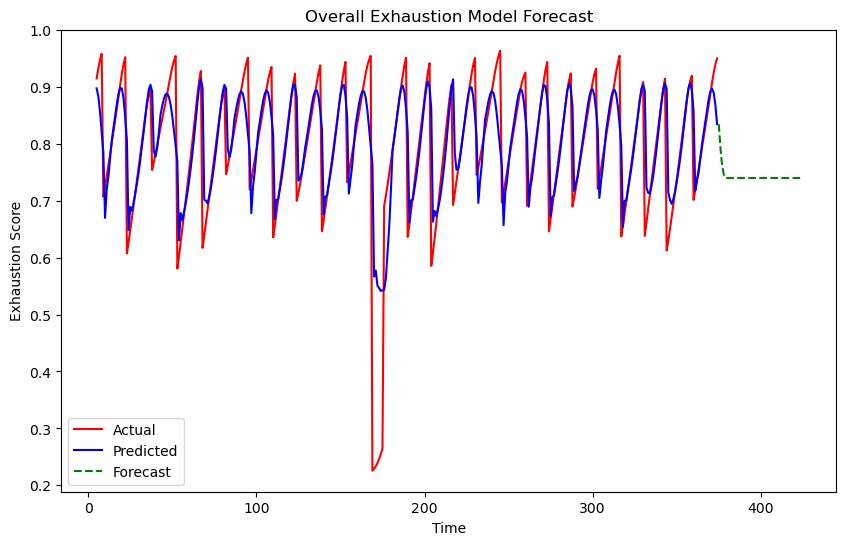

INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

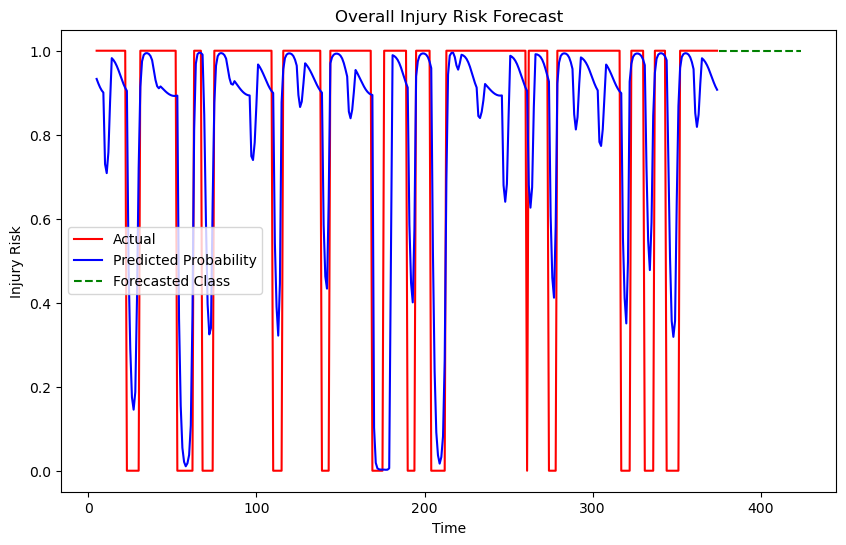

INFO: Created LSTM sequences: (370, 5, 3), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

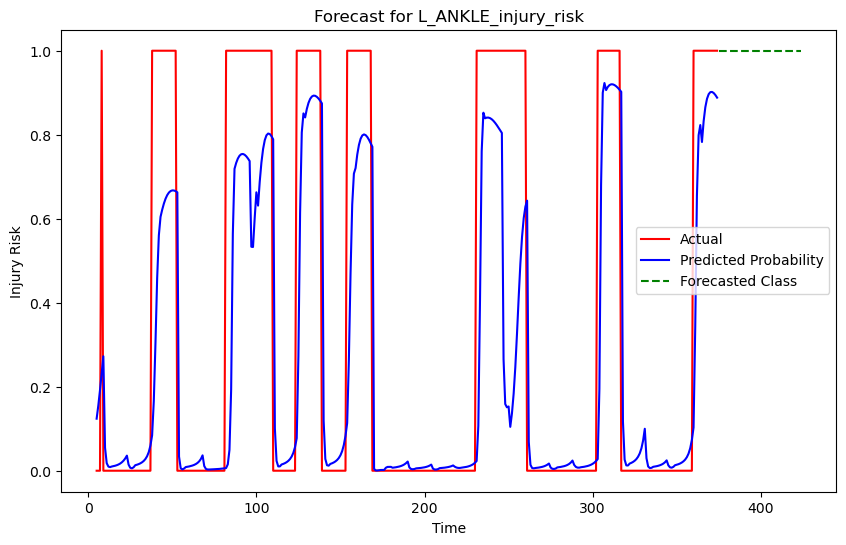

INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

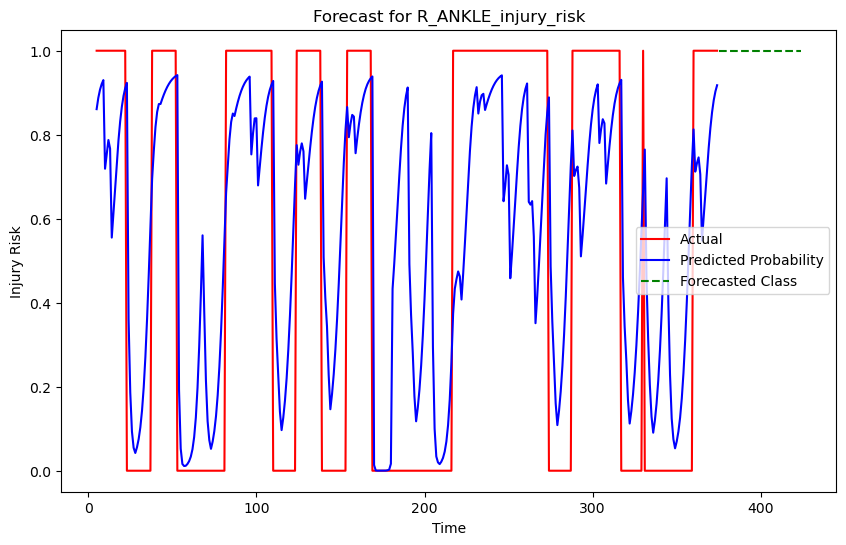

INFO: Created LSTM sequences: (370, 5, 2), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

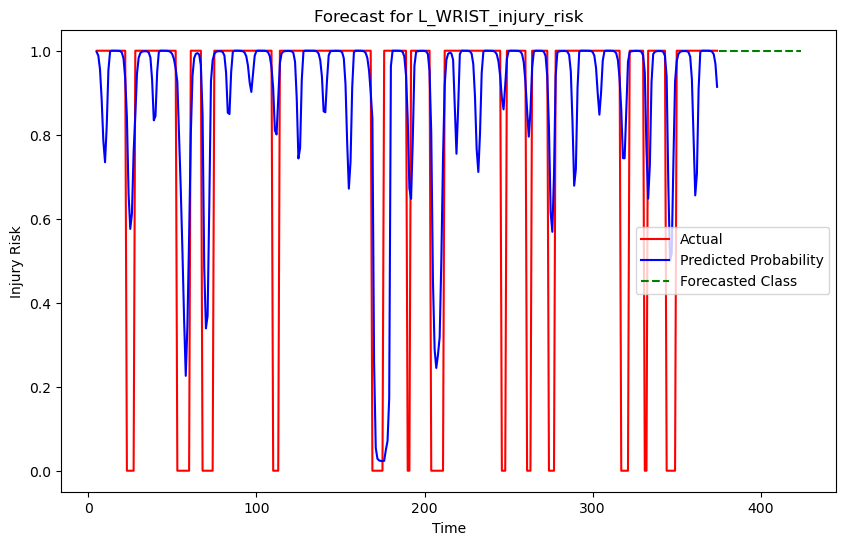

INFO: Created LSTM sequences: (370, 5, 2), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

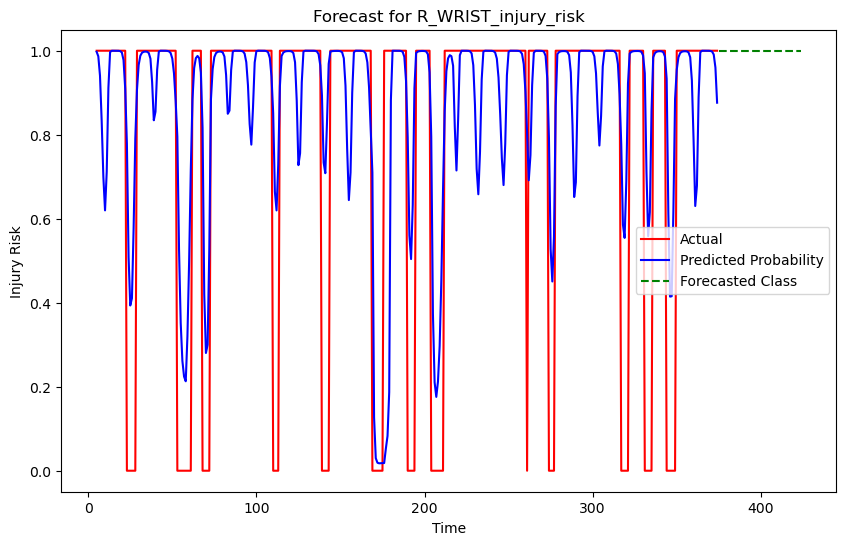

INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

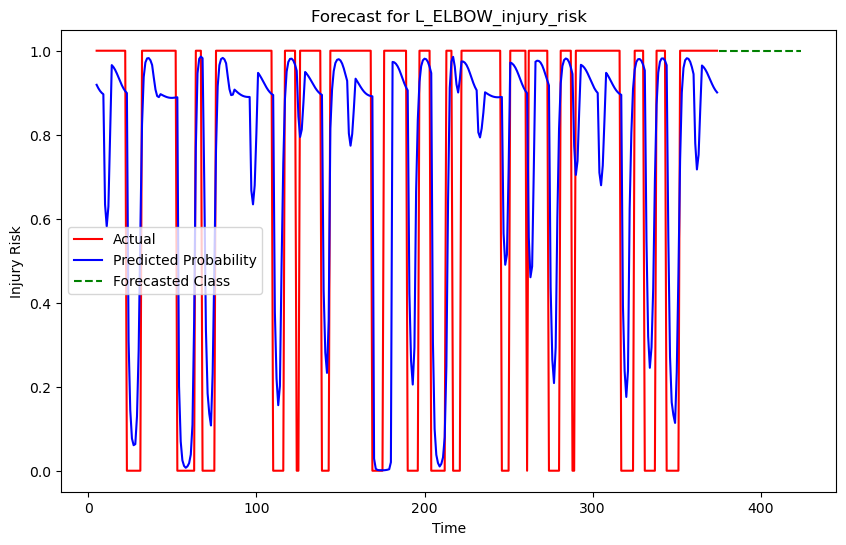

INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

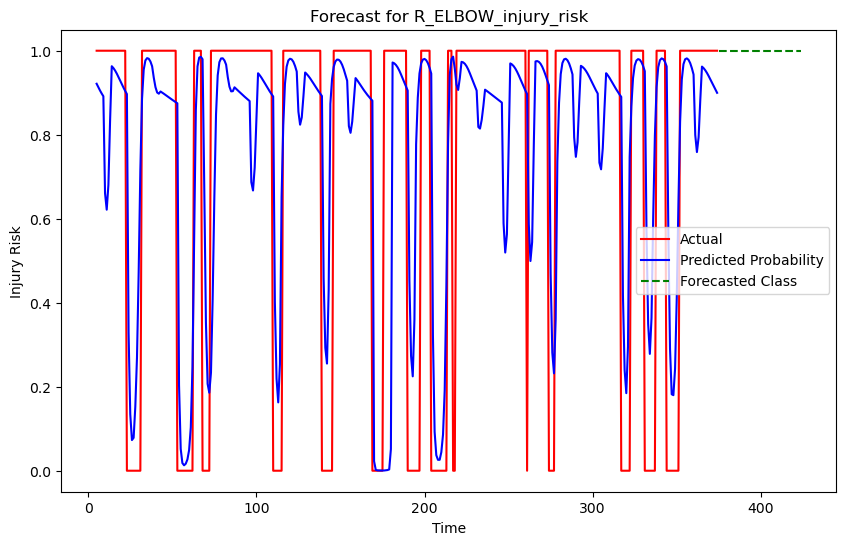

INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

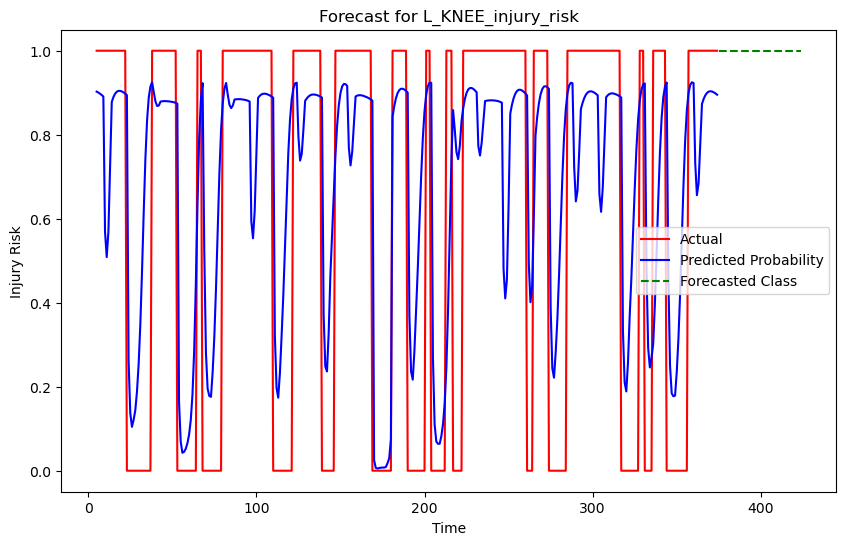

INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

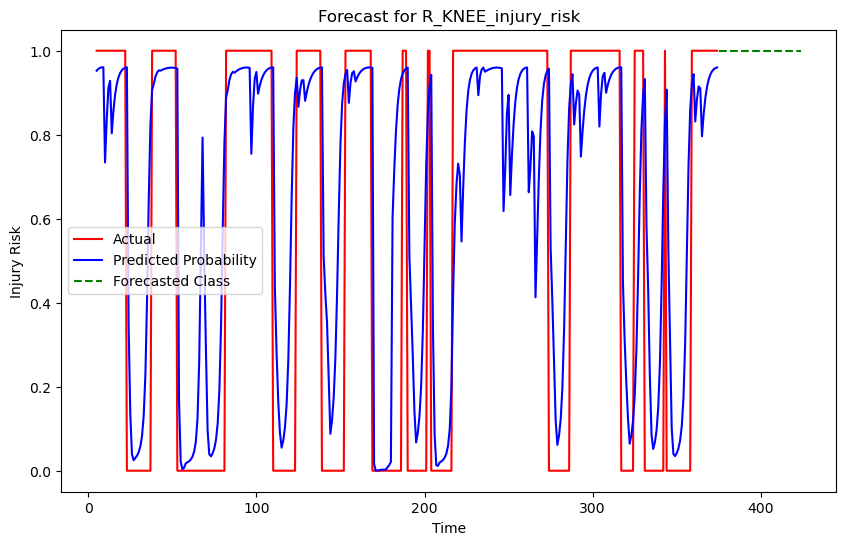

INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

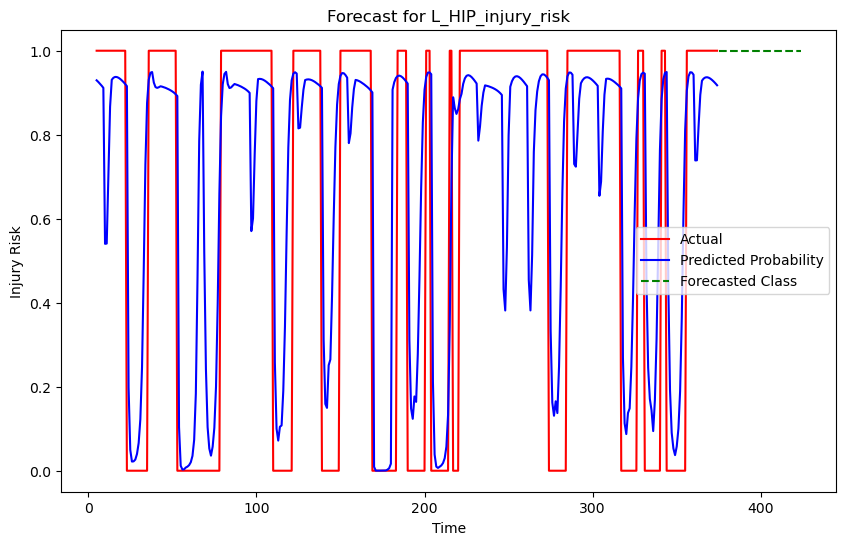

INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

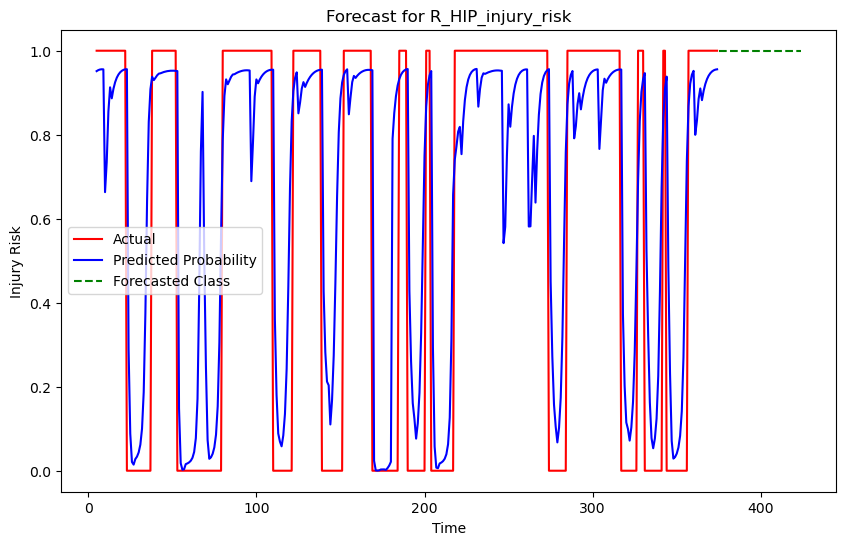

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 3), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 2), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 2), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


INFO: Created LSTM sequences: (370, 5, 1), (370,)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


INFO: Saved model summary dataframe to ..\..\data\Deep_Learning_Final\model_summary.csv
INFO: Performed temporal train-test split with test size = 0.2
INFO: Training data shape: (100, 140), Testing data shape: (25, 140)
INFO: 📥 Loaded General feature list for 'by_trial_exhaustion_score' from ..\..\data\Deep_Learning_Final\trial_summary\by_trial_exhaustion_score_model_feature_list.pkl:
['by_trial_exhaustion_score', 'rolling_hr_mean', 'L_HIP_energy', 'simulated_HR', 'R_HIP_energy', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'R_ELBOW_energy', 'exhaustion_rate_lag1', 'L_ELBOW_energy']
INFO: DataFrame columns for validation: ['trial_id', 'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_p

=== Model Summaries (Base Data) ===
None
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.9740 - val_loss: 1.5075
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9568 - val_loss: 1.4964
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.1859 - val_loss: 1.4845
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.8768 - val_loss: 1.4771
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9160 - val_loss: 1.4741
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8700 - val_loss: 1.4686
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9467 - val_loss: 1.4659
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.8629 - val_loss: 1.4650
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7742 - val_loss: 1.4684
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7885 - val_loss: 1.4721


INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (95, 5, 1), (95,)
INFO: Created LSTM sequences: (20, 5, 1), (20,)
INFO: Training overall injury risk model...


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.4566 - loss: 0.6904 - val_accuracy: 1.0000 - val_loss: 0.6793
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.6761 - val_accuracy: 1.0000 - val_loss: 0.6630
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.6593 - val_accuracy: 1.0000 - val_loss: 0.6436
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.6386 - val_accuracy: 1.0000 - val_loss: 0.6201
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.6148 - val_accuracy: 1.0000 - val_loss: 0.5916
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.5844 - val_accuracy: 1.0000 - val_loss: 0.5567
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.5485 - val_accuracy: 1.0000 - val_loss: 0.5140
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.5023 - val_accuracy: 1.0000 - val_loss: 0.4623


INFO: Created LSTM sequences: (20, 5, 10), (20,)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

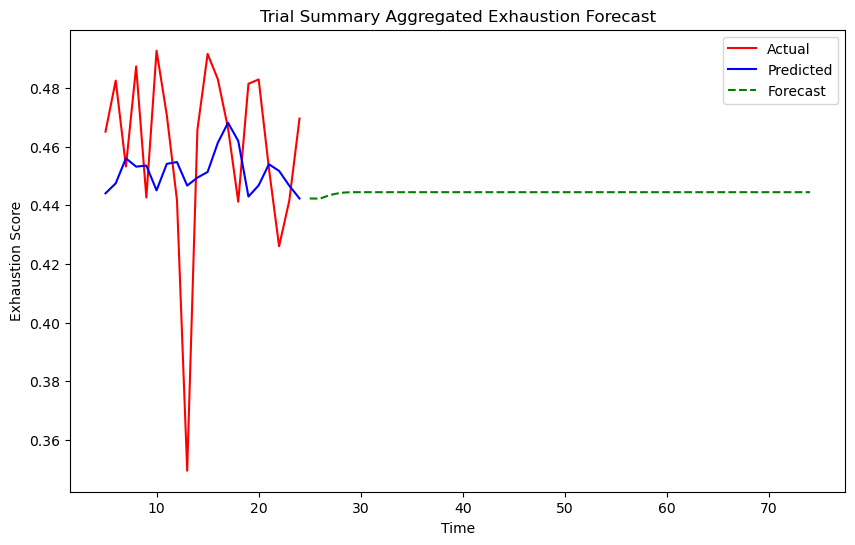

INFO: Created LSTM sequences: (20, 5, 1), (20,)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

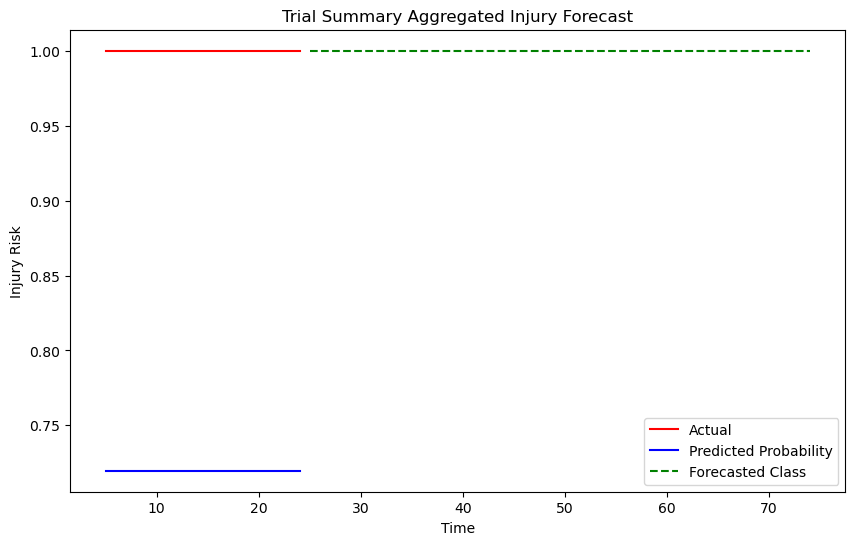

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


ERROR: summarize_joint_models for L_ANKLE_injury_risk - Missing features: ['R_KNEE_ROM_deviation', 'rolling_exhaustion']


ValueError: summarize_joint_models for L_ANKLE_injury_risk - Missing features: ['R_KNEE_ROM_deviation', 'rolling_exhaustion']

In [8]:
import numpy as np
import pandas as pd
import json
import sys
import logging
from pathlib import Path

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, r2_score, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns


# ==================== UTILS ====================
       
def temporal_train_test_split(data, test_size=0.2):
    """Time-based split maintaining temporal order"""
    split_idx = int(len(data) * (1 - test_size))
    train_data = data.iloc[:split_idx]
    test_data = data.iloc[split_idx:]
    logging.info(f"Performed temporal train-test split with test size = {test_size}")
    logging.info(f"Training data shape: {train_data.shape}, Testing data shape: {test_data.shape}")
    return train_data, test_data

def scale_features(X_train, X_test):
    """
    Scales features using StandardScaler.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    logging.info("Features have been scaled using StandardScaler.")
    return X_train_scaled, X_test_scaled, scaler

def create_sequences(X, y, timesteps):
    """
    Creates sequences of data for LSTM input.
    """
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i-timesteps:i])
        y_seq.append(y[i])
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    logging.info(f"Created LSTM sequences: {X_seq.shape}, {y_seq.shape}")
    return X_seq, y_seq
# ==================== TRAINING FUNCTIONS ====================

def train_exhaustion_model(train_data, test_data, features, timesteps, 
                           epochs=50, batch_size=32, early_stop_patience=5,
                           num_lstm_layers=1, lstm_units=64, dropout_rate=0.2,
                           dense_units=1, dense_activation=None):
    """
    Trains the overall exhaustion model (regression) with a separate target scaler.

    Parameters:
      - train_data (DataFrame): Training set.
      - test_data (DataFrame): Testing set.
      - features (list): List of feature column names for exhaustion.
      - timesteps (int): Number of past observations to include in each sequence.
      - epochs (int): Number of training epochs.
      - batch_size (int): Batch size for training.
      - early_stop_patience (int): Patience for EarlyStopping callback.
      - num_lstm_layers (int): Number of LSTM layers in the model.
      - lstm_units (int): Number of units in each LSTM layer.
      - dropout_rate (float): Dropout rate applied after each LSTM layer.
      - dense_units (int): Number of units in the final Dense layer.
      - dense_activation (str or None): Activation function for the Dense layer.
      
    Returns:
      - model_exhaustion: Trained Keras model.
      - scaler_exhaustion: Fitted scaler for the features.
      - target_scaler: Fitted scaler for the target values.
      - X_lstm_exhaustion_val, y_lstm_exhaustion_val: Validation sequences (targets are scaled).
    """
    # Extract features and target from training and testing data
    X_train = train_data[features].values
    y_train = train_data['by_trial_exhaustion_score'].values
    X_test = test_data[features].values
    y_test = test_data['by_trial_exhaustion_score'].values

    # Scale features using the existing helper function
    X_train_scaled, X_test_scaled, scaler_exhaustion = scale_features(X_train, X_test)
    
    # ---- New: Scale the target (exhaustion scores) separately ----
    from sklearn.preprocessing import StandardScaler
    target_scaler = StandardScaler()
    # Reshape y to 2D arrays for StandardScaler
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1))
    # ------------------------------------------------------------------

    # Create sequences for LSTM input using the scaled features and scaled target values
    X_lstm, y_lstm = create_sequences(X_train_scaled, y_train_scaled, timesteps)
    X_lstm_val, y_lstm_val = create_sequences(X_test_scaled, y_test_scaled, timesteps)

    # ---- Model Construction using an explicit Input layer and architecture hyperparameters ----
    from tensorflow.keras import Input
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dropout, Dense

    model_exhaustion = Sequential()
    # Define the input shape
    model_exhaustion.add(Input(shape=(X_lstm.shape[1], X_lstm.shape[2])))
    # Add LSTM layers with dropout (all but last LSTM layer return sequences)
    for i in range(num_lstm_layers):
        return_seq = True if i < num_lstm_layers - 1 else False
        model_exhaustion.add(LSTM(lstm_units, return_sequences=return_seq))
        model_exhaustion.add(Dropout(dropout_rate))
    # Final Dense layer for output (for regression, no activation by default)
    model_exhaustion.add(Dense(dense_units, activation=dense_activation))
    # ----------------------------------------------------------------------------------------------

    model_exhaustion.compile(optimizer='adam', loss='mse')

    from tensorflow.keras.callbacks import EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=early_stop_patience)

    import logging
    logging.info("Training overall exhaustion model...")
    model_exhaustion.fit(
        X_lstm, y_lstm,
        epochs=epochs, 
        batch_size=batch_size,
        validation_data=(X_lstm_val, y_lstm_val),
        callbacks=[early_stop]
    )

    # Return the model, the scaler for features, the separate target scaler, and validation sequences
    return model_exhaustion, scaler_exhaustion, target_scaler, X_lstm_val, y_lstm_val




def train_injury_model(train_data, test_data, features, timesteps,
                       epochs=50, batch_size=32,
                       num_lstm_layers=1, lstm_units=64, dropout_rate=0.2,
                       dense_units=1, dense_activation='sigmoid'):
    """
    Trains the overall injury risk model.

    Parameters:
      - train_data (DataFrame): Training set.
      - test_data (DataFrame): Testing set.
      - features (list): List of feature column names for injury risk.
      - timesteps (int): Number of past observations to include in each sequence.
      - epochs (int): Number of training epochs.
      - batch_size (int): Batch size for training.
      - num_lstm_layers (int): Number of LSTM layers in the model.
      - lstm_units (int): Number of units in each LSTM layer.
      - dropout_rate (float): Dropout rate applied after each LSTM layer.
      - dense_units (int): Number of units in the final Dense layer.
      - dense_activation (str): Activation function for the Dense layer (default 'sigmoid' for classification).
      
    Returns:
      - model_injury: Trained Keras model.
      - scaler_injury: Fitted scaler for the features.
      - X_lstm_injury_val, y_lstm_injury_val: Validation sequences.
    """
    X_train = train_data[features].values
    y_train = train_data['injury_risk'].values
    X_test = test_data[features].values
    y_test = test_data['injury_risk'].values

    # Scale features
    X_train_scaled, X_test_scaled, scaler_injury = scale_features(X_train, X_test)
    # Create sequences for LSTM input
    X_lstm, y_lstm = create_sequences(X_train_scaled, y_train, timesteps)
    X_lstm_val, y_lstm_val = create_sequences(X_test_scaled, y_test, timesteps)

    # ---- Updated Model Construction using an explicit Input layer and architecture hyperparameters ----
    from tensorflow.keras import Input
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dropout, Dense

    model_injury = Sequential()
    model_injury.add(Input(shape=(X_lstm.shape[1], X_lstm.shape[2])))
    for i in range(num_lstm_layers):
        return_seq = True if i < num_lstm_layers - 1 else False
        model_injury.add(LSTM(lstm_units, return_sequences=return_seq))
        model_injury.add(Dropout(dropout_rate))
    model_injury.add(Dense(dense_units, activation=dense_activation))
    # ----------------------------------------------------------------------------------------------

    model_injury.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    import logging
    logging.info("Training overall injury risk model...")
    model_injury.fit(
        X_lstm, y_lstm,
        epochs=epochs, 
        batch_size=batch_size,
        validation_data=(X_lstm_val, y_lstm_val)
    )

    return model_injury, scaler_injury, X_lstm_val, y_lstm_val
# ==================== JOINT-SPECIFIC TRAINING FUNCTION ====================



def train_joint_models(train_data, test_data, joints, timesteps, feature_dir,
                       epochs=50, batch_size=32,
                       num_lstm_layers=1, lstm_units=64, dropout_rate=0.2,
                       dense_units=1, dense_activation='sigmoid',
                       joint_feature_dict=None):
    """
    Trains injury risk models for multiple joints.
    
    Parameters:
      - train_data (DataFrame): Training set.
      - test_data (DataFrame): Testing set.
      - joints (list): List of joint names.
      - timesteps (int): Number of past observations to include in each sequence.
      - feature_dir (str): Directory containing feature lists.
      - epochs (int): Number of training epochs.
      - batch_size (int): Batch size for training.
      - num_lstm_layers (int): Number of LSTM layers in the model.
      - lstm_units (int): Number of units in each LSTM layer.
      - dropout_rate (float): Dropout rate applied after each LSTM layer.
      - dense_units (int): Number of units in the final Dense layer.
      - dense_activation (str): Activation function for the Dense layer.
      - joint_feature_dict (dict or None): (Optional) Dictionary mapping each joint target (e.g., 
            "L_ANKLE_injury_risk") to a preloaded feature list. If None, the function calls
            load_top_features for each target.
      
    Returns:
      - joint_models (dict): Dictionary with joint model information.
    """
    import logging
    from tensorflow.keras import Input
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dropout, Dense
    joint_models = {}

    for joint in joints:
        for side in ['L', 'R']:
            target_joint = f"{side}_{joint}_injury_risk"
            logging.info(f"Training model for {target_joint}...")

            # If a joint_feature_dict is provided and has the target, use it;
            # otherwise, call load_top_features from the specified directory.
            if joint_feature_dict is not None and target_joint in joint_feature_dict:
                joint_features = joint_feature_dict[target_joint]
                logging.info(f"Using preloaded feature list for {target_joint}: {joint_features}")
            else:
                joint_features = load_top_features(target_joint, feature_dir=feature_dir)
            
            # Extract joint-specific features and target values.
            X_train_joint = train_data[joint_features].values
            y_train_joint = train_data[target_joint].values
            X_test_joint = test_data[joint_features].values
            y_test_joint = test_data[target_joint].values

            # Scale features for the joint-specific model.
            X_train_scaled, X_test_scaled, scaler_joint = scale_features(X_train_joint, X_test_joint)
            # Create sequences for LSTM input.
            X_lstm, y_lstm = create_sequences(X_train_scaled, y_train_joint, timesteps)
            X_lstm_val, y_lstm_val = create_sequences(X_test_scaled, y_test_joint, timesteps)

            # Build the joint model.
            model_joint = Sequential()
            model_joint.add(Input(shape=(X_lstm.shape[1], X_lstm.shape[2])))
            for i in range(num_lstm_layers):
                return_seq = True if i < num_lstm_layers - 1 else False
                model_joint.add(LSTM(lstm_units, return_sequences=return_seq))
                model_joint.add(Dropout(dropout_rate))
            model_joint.add(Dense(dense_units, activation=dense_activation))

            model_joint.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

            model_joint.fit(
                X_lstm, y_lstm,
                epochs=epochs, 
                batch_size=batch_size,
                validation_data=(X_lstm_val, y_lstm_val)
            )

            joint_models[target_joint] = {
                'model': model_joint,
                'features': joint_features,
                'scaler': scaler_joint
            }

    # Save the loaded feature lists for all joint models.
    import json
    with open("loaded_features.json", "w") as f:
        json.dump({target: info['features'] for target, info in joint_models.items()}, f, indent=4)
    logging.info("Saved loaded features list for each joint model to 'loaded_features.json'.")

    return joint_models




# ==================== FORECASTING FUNCTION ====================

def forecast_and_plot_exhaustion(model, test_data, forecast_features, scaler_exhaustion, target_scaler, timesteps, future_steps=0, title="Exhaustion Forecast"):
    """
    Generates predictions for the exhaustion target using multi-feature input.
    
    This function extracts the same features used during training (e.g. a 10-dimensional input),
    scales them with the features scaler (scaler_exhaustion), builds forecasting sequences, makes predictions,
    and finally inverse-transforms the predictions using the target scaler.
    
    Parameters:
      - model: Trained exhaustion Keras model.
      - test_data (DataFrame): The test DataFrame containing all features.
      - forecast_features (list): List of feature names used for forecasting (e.g. features_exhaustion).
      - scaler_exhaustion: Fitted StandardScaler used to scale the features.
      - target_scaler: Fitted StandardScaler used to scale the target values.
      - timesteps (int): Number of past observations to include in each sequence.
      - future_steps (int): Number of future time steps to forecast.
                          (Note: Future forecasting is approximate since it assumes constant features.)
      - title (str): Plot title.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Extract multi-dimensional input from test data
    X_forecast = test_data[forecast_features].values  # shape (n, num_features)
    
    # Scale the features using the features scaler
    X_forecast_scaled = scaler_exhaustion.transform(X_forecast)
    
    # Create sequences for forecasting using a dummy y array (since only X is needed)
    X_seq, _ = create_sequences(X_forecast_scaled, np.zeros(len(X_forecast_scaled)), timesteps)
    
    # Make predictions on the scaled sequences
    predictions_scaled = model.predict(X_seq)
    # Inverse-transform predictions using the target scaler
    predictions = target_scaler.inverse_transform(predictions_scaled)
    
    forecast_predictions_inv = None
    if future_steps > 0:
        # For additional future steps, we assume the features remain constant.
        # WARNING: This is an approximation.
        current_sequence = X_seq[-1].copy()  # shape: (timesteps, num_features)
        forecast_predictions = []
        for _ in range(future_steps):
            next_pred = model.predict(current_sequence.reshape(1, timesteps, current_sequence.shape[1]))
            forecast_predictions.append(next_pred[0, 0])
            # Update sequence: drop the first row and append the last row (assumed constant)
            new_row = current_sequence[-1, :].copy()
            current_sequence = np.vstack([current_sequence[1:], new_row])
        forecast_predictions = np.array(forecast_predictions).reshape(-1, 1)
        forecast_predictions_inv = target_scaler.inverse_transform(forecast_predictions)
    
    # Plot actual exhaustion scores versus predictions
    plt.figure(figsize=(10, 6))
    actual = test_data['by_trial_exhaustion_score'].values
    plt.plot(range(timesteps, len(actual)), actual[timesteps:], color='red', label='Actual')
    plt.plot(range(timesteps, len(actual)), predictions, color='blue', label='Predicted')
    if forecast_predictions_inv is not None:
        future_x = list(range(len(actual), len(actual) + future_steps))
        plt.plot(future_x, forecast_predictions_inv, color='green', linestyle='--', label='Forecast')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Exhaustion Score')
    plt.legend()
    plt.show()


def forecast_and_plot_injury(model, test_data, forecast_features, scaler_injury, timesteps, future_steps=0, title="Injury Risk Forecast"):
    """
    Generates predictions for the injury risk model using multi-feature input.
    
    This function extracts the injury features from the test data, scales them using scaler_injury,
    builds forecasting sequences, and makes predictions. Since this is a classification model,
    it outputs probability predictions. These probabilities (or rounded binary classes) are compared
    to the actual injury risk (assumed to be 0 or 1).
    
    Parameters:
      - model: Trained injury risk Keras model.
      - test_data (DataFrame): The test DataFrame containing all features.
      - forecast_features (list): List of feature names used for forecasting (e.g. features_injury).
      - scaler_injury: Fitted StandardScaler used to scale the injury features.
      - timesteps (int): Number of past observations to include in each sequence.
      - future_steps (int): Number of future time steps to forecast.
                          (For classification, future forecasting is less common.)
      - title (str): Plot title.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Extract multi-dimensional input for injury risk from test data
    X_forecast = test_data[forecast_features].values  # shape (n, num_features)
    
    # Scale the features using the injury features scaler
    X_forecast_scaled = scaler_injury.transform(X_forecast)
    
    # Create sequences for forecasting (dummy y used, since only X is needed)
    X_seq, _ = create_sequences(X_forecast_scaled, np.zeros(len(X_forecast_scaled)), timesteps)
    
    # Predict probabilities on the sequences
    predictions_prob = model.predict(X_seq)
    # Convert probabilities to binary predictions (threshold=0.5)
    predictions_class = (predictions_prob >= 0.5).astype(int)
    
    forecast_predictions = None
    if future_steps > 0:
        # For future steps, we assume features remain constant (approximation)
        current_sequence = X_seq[-1].copy()  # shape: (timesteps, num_features)
        forecast_predictions = []
        for _ in range(future_steps):
            next_pred = model.predict(current_sequence.reshape(1, timesteps, current_sequence.shape[1]))
            forecast_predictions.append((next_pred[0, 0] >= 0.5).astype(int))
            new_row = current_sequence[-1, :].copy()
            current_sequence = np.vstack([current_sequence[1:], new_row])
        forecast_predictions = np.array(forecast_predictions)
    
    # Plot the actual injury risk versus predicted probability (or binary prediction)
    plt.figure(figsize=(10, 6))
    actual = test_data['injury_risk'].values
    # For plotting, we align the sequences starting at index 'timesteps'
    plt.plot(range(timesteps, len(actual)), actual[timesteps:], color='red', label='Actual')
    plt.plot(range(timesteps, len(actual)), predictions_prob, color='blue', label='Predicted Probability')
    if forecast_predictions is not None:
        future_x = list(range(len(actual), len(actual) + future_steps))
        plt.plot(future_x, forecast_predictions, color='green', linestyle='--', label='Forecasted Class')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Injury Risk')
    plt.legend()
    plt.show()


def forecast_and_plot_joint(joint_models, test_data, timesteps, future_steps=0):
    """
    Generates forecasts for each joint model using their corresponding features and scalers.
    
    For each joint model in the joint_models dictionary (returned by train_joint_models),
    this function extracts the joint-specific features from test_data, scales them using the model's scaler,
    builds sequences, obtains predictions (probabilities), converts them to binary predictions,
    and then plots the actual joint injury risk versus predicted values.
    
    Parameters:
      - joint_models (dict): Dictionary where each key is a joint target name and each value is a dict 
                             containing 'model', 'features', and 'scaler'.
      - test_data (DataFrame): The test DataFrame containing all features.
      - timesteps (int): Number of past observations to include in each sequence.
      - future_steps (int): Number of future time steps to forecast (optional).
    """
    import numpy as np
    import matplotlib.pyplot as plt

    for target_joint, info in joint_models.items():
        model_joint = info['model']
        joint_features = info['features']
        scaler_joint = info['scaler']
        
        # Extract joint-specific features from test data
        X_forecast = test_data[joint_features].values  # shape (n, num_features)
        # Scale the features
        X_forecast_scaled = scaler_joint.transform(X_forecast)
        # Create sequences for forecasting (dummy y used)
        X_seq, _ = create_sequences(X_forecast_scaled, np.zeros(len(X_forecast_scaled)), timesteps)
        
        # Predict probabilities and convert to binary predictions
        predictions_prob = model_joint.predict(X_seq)
        predictions_class = (predictions_prob >= 0.5).astype(int)
        
        forecast_predictions = None
        if future_steps > 0:
            # Approximate forecasting by assuming constant features
            current_sequence = X_seq[-1].copy()  # shape: (timesteps, num_features)
            forecast_predictions = []
            for _ in range(future_steps):
                next_pred = model_joint.predict(current_sequence.reshape(1, timesteps, current_sequence.shape[1]))
                forecast_predictions.append((next_pred[0, 0] >= 0.5).astype(int))
                new_row = current_sequence[-1, :].copy()
                current_sequence = np.vstack([current_sequence[1:], new_row])
            forecast_predictions = np.array(forecast_predictions)
        
        # Plot for this joint model
        plt.figure(figsize=(10, 6))
        actual = test_data[target_joint].values
        plt.plot(range(timesteps, len(actual)), actual[timesteps:], color='red', label='Actual')
        plt.plot(range(timesteps, len(actual)), predictions_prob, color='blue', label='Predicted Probability')
        if forecast_predictions is not None:
            future_x = list(range(len(actual), len(actual) + future_steps))
            plt.plot(future_x, forecast_predictions, color='green', linestyle='--', label='Forecasted Class')
        plt.title(f"Forecast for {target_joint}")
        plt.xlabel('Time')
        plt.ylabel('Injury Risk')
        plt.legend()
        plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score

def summarize_exhaustion_model(model, X_val, y_val, target_scaler, debug=False):
    """
    Generates evaluation metrics for the exhaustion (regression) model.
    
    Added debug statements to check the predictions before and after inverse transformation.
    These prints help to verify that the predicted outputs and the true target values are finite.
    
    Parameters:
      - model: Trained exhaustion Keras model.
      - X_val: Validation features (sequences) used for prediction.
      - y_val: Validation target values (scaled).
      - target_scaler: Fitted StandardScaler used to inverse transform the targets.
      - debug (bool): If True, prints debug output.
      
    Returns:
      - A dictionary with evaluation metrics: MSE, MAE, and R2 Score.
    """
    preds_scaled = model.predict(X_val)
    if debug:
        print("Step 4: After prediction (scaled predictions)")
        print("preds_scaled stats:", np.nanmin(preds_scaled), np.nanmax(preds_scaled), np.isnan(preds_scaled).sum())
    
    preds = target_scaler.inverse_transform(preds_scaled)
    y_true = target_scaler.inverse_transform(y_val)
    
    if debug:
        print("Step 4: After inverse transformation")
        print("After inverse transform, preds stats:", np.nanmin(preds), np.nanmax(preds), np.isnan(preds).sum())
        print("After inverse transform, y_true stats:", np.nanmin(y_true), np.nanmax(y_true), np.isnan(y_true).sum())
    
    mse = mean_squared_error(y_true, preds)
    mae = mean_absolute_error(y_true, preds)
    r2 = r2_score(y_true, preds)
    
    return {"MSE": mse, "MAE": mae, "R2 Score": r2}


def summarize_classification_model(model, X_val, y_val):
    """
    Generates evaluation metrics for a classification model.
    """
    preds_prob = model.predict(X_val)
    preds_class = (preds_prob >= 0.5).astype(int)
    
    accuracy = accuracy_score(y_val, preds_class)
    precision = precision_score(y_val, preds_class, zero_division=0)
    recall = recall_score(y_val, preds_class, zero_division=0)
    f1 = f1_score(y_val, preds_class, zero_division=0)
    
    return {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}

def summarize_joint_models(joint_models, test_data, timesteps):
    """
    Computes evaluation metrics for each joint model.
    
    For each joint model in the dictionary, it:
      - Validates that all expected joint features are present in the test data.
      - Extracts the feature columns and target values.
      - Scales the features and creates sequences.
      - Computes the evaluation metrics.
    
    Parameters:
      - joint_models (dict): Dictionary with joint model information.
      - test_data (DataFrame): Test data containing all features.
      - timesteps (int): Number of past observations to include in each sequence.
      
    Returns:
      - summaries (dict): Dictionary with evaluation metrics for each joint model.
    """
    summaries = {}
    for target_joint, info in joint_models.items():
        model_joint = info['model']
        joint_features = info['features']
        scaler_joint = info['scaler']
        
        # Validate that the test data has all the joint-specific features
        validate_features(joint_features, test_data, context=f"summarize_joint_models for {target_joint}")
        
        # Now safely extract the features and target from test_data.
        X_joint = test_data[joint_features].values
        y_joint = test_data[target_joint].values
        
        X_joint_scaled = scaler_joint.transform(X_joint)
        X_seq, y_seq = create_sequences(X_joint_scaled, y_joint, timesteps)
        
        metrics = summarize_classification_model(model_joint, X_seq, y_seq)
        summaries[target_joint] = metrics
    return summaries


def summarize_all_models(model_exhaustion, X_val_exh, y_val_exh, target_scaler,
                         model_injury, X_val_injury, y_val_injury,
                         joint_models, test_data, timesteps, output_dir):
    """
    Combines summaries from the exhaustion, injury, and joint models into a table.
    """
    summary_data = []
    exh_metrics = summarize_exhaustion_model(model_exhaustion, X_val_exh, y_val_exh, target_scaler)
    summary_data.append({
        "Model": "Exhaustion Model",
        "Type": "Regression",
        "MSE": exh_metrics.get("MSE"),
        "MAE": exh_metrics.get("MAE"),
        "R2 Score": exh_metrics.get("R2 Score"),
        "Accuracy": None,
        "Precision": None,
        "Recall": None,
        "F1 Score": None
    })
    
    injury_metrics = summarize_classification_model(model_injury, X_val_injury, y_val_injury)
    summary_data.append({
        "Model": "Injury Model",
        "Type": "Classification",
        "MSE": None,
        "MAE": None,
        "R2 Score": None,
        "Accuracy": injury_metrics.get("Accuracy"),
        "Precision": injury_metrics.get("Precision"),
        "Recall": injury_metrics.get("Recall"),
        "F1 Score": injury_metrics.get("F1 Score")
    })
    
    joint_summaries = summarize_joint_models(joint_models, test_data, timesteps)
    for target_joint, metrics in joint_summaries.items():
        summary_data.append({
            "Model": target_joint,
            "Type": "Classification",
            "MSE": None,
            "MAE": None,
            "R2 Score": None,
            "Accuracy": metrics.get("Accuracy"),
            "Precision": metrics.get("Precision"),
            "Recall": metrics.get("Recall"),
            "F1 Score": metrics.get("F1 Score")
        })
    
    summary_df = pd.DataFrame(summary_data)
    output_file = Path(output_dir) / "model_summary.csv"
    summary_df.to_csv(output_file, index=False)
    logging.info(f"Saved model summary dataframe to {output_file}")




if __name__ == "__main__":
    import logging
    import os
    logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

    # ------------------------------
    # 1. Data Loading & Preparation
    # ------------------------------
    csv_path = "../../data/processed/final_granular_dataset.csv"
    json_path = "../../data/basketball/freethrow/participant_information.json"
    feature_dir = "../../data/Deep_Learning_Final"  # Directory where feature lists were saved
    output_dir = "../../data/Deep_Learning_Final"   # Used for both saving features and summaries

    # Load raw data and run initial feature engineering on the base data.
    data = load_data(csv_path, json_path, debug=True)
    data = prepare_joint_features(data, debug=True)
    data = feature_engineering(data, debug=True)
    data = data.copy()  # Defragment DataFrame
    print("Base data columns:", data.columns.tolist())

    # ------------------------------
    # 2. Create Aggregated (Summarized) Datasets
    # ------------------------------
    default_agg_columns = [
        # Primary joint energies (key performance indicators)
        'joint_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy',
        # Critical power metrics 
        'joint_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 
        'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power',
        'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power',
        # Key asymmetry metrics (injury prevention indicators)
        'elbow_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', 'hip_asymmetry',
        # Critical joint angles (form analysis)
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle', 
        'L_KNEE_angle', 'R_KNEE_angle',
        # Essential ROM metrics (technique consistency)
        'L_SHOULDER_ROM', 'R_SHOULDER_ROM', 'L_WRIST_ROM', 'R_WRIST_ROM',
        'L_KNEE_ROM', 'R_KNEE_ROM', 'L_HIP_ROM', 'R_HIP_ROM',
        # Fatigue and injury risk indicators
        'exhaustion_rate', 'by_trial_exhaustion_score', 'injury_risk',
        'energy_acceleration', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'simulated_HR',
        # Player physical attributes
        'player_height_in_meters', 'player_weight__in_kg'
    ]
    
    default_lag_columns = [
        # Energy transfer metrics (fatigue indicators)
        'joint_energy', 'joint_power',
        'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy',
        # Primary asymmetry metrics (technique degradation)
        'elbow_asymmetry', 'wrist_asymmetry',
        # Critical angles for shooting form
        'L_ELBOW_angle', 'R_ELBOW_angle', 'L_WRIST_angle', 'R_WRIST_angle',
        # Fatigue indicators
        'exhaustion_rate', 'by_trial_exhaustion_score',
        'simulated_HR'
    ]
    rolling_window = 3

    # Create trial and shot phase aggregated datasets.
    trial_data = prepare_joint_features(data, debug=True, group_trial=True)
    trial_data = feature_engineering(trial_data, debug=True, group_trial=True)
    
    trial_summary_data = summarize_data(
        data,
        groupby_cols=['trial_id'],
        lag_columns=default_lag_columns,
        rolling_window=rolling_window,
        agg_columns=default_agg_columns,
        global_lag=True,
        debug=True
    )
    
    shot_phase_data = prepare_joint_features(data, debug=True, group_trial=True, group_shot_phase=True)
    shot_phase_data = feature_engineering(shot_phase_data, debug=True, group_trial=True, group_shot_phase=True)
    shot_phase_summary_data = summarize_data(
        shot_phase_data,
        groupby_cols=['trial_id', 'shooting_phases'],
        lag_columns=default_lag_columns,
        rolling_window=rolling_window,
        agg_columns=default_agg_columns,
        phase_list=["arm_cock", "arm_release", "leg_cock", "wrist_release"],
        debug=True
    )
    print("Shot Phase Summary Sample:")
    print(shot_phase_summary_data.head())
    print("Trial Summary Sample:")
    print(trial_summary_data.head())

    # ------------------------------
    # 3. Filter Base Data for Modeling
    # ------------------------------
    # Use only rows where shooting_motion == 1.
    data = data[data['shooting_motion'] == 1]

    # ------------------------------
    # 4. Load Selected Features for Base Models
    # ------------------------------
    # Load the features selected from earlier feature importance analysis.
    # These feature lists were saved using the new importance_threshold filter.
    # Load feature lists for base targets.
    features_exhaustion = load_top_features('by_trial_exhaustion_score', feature_dir=base_feature_dir)
    features_injury = load_top_features('injury_risk', feature_dir=base_feature_dir)
    
    # For joint models, preload the feature lists into a dictionary.
    joints = ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']
    joint_feature_dict = {}
    for joint in joints:
        for side in ['L', 'R']:
            target_joint = f"{side}_{joint}_injury_risk"
            joint_feature_dict[target_joint] = load_top_features(target_joint, feature_dir=base_feature_dir)
    
    # ------------------------------
    # 5. Split Base Data for Training Models
    # ------------------------------
    train_data, test_data = temporal_train_test_split(data, test_size=0.2)
    timesteps = 5

    # Hyperparameters and architecture definitions.
    hyperparams = {
        "epochs": 10,
        "batch_size": 32,
        "early_stop_patience": 5
    }
    arch_exhaustion = {
        "num_lstm_layers": 1,
        "lstm_units": 64,
        "dropout_rate": 0.2,
        "dense_units": 1,
        "dense_activation": None
    }
    arch_injury = {
        "num_lstm_layers": 1,
        "lstm_units": 64,
        "dropout_rate": 0.2,
        "dense_units": 1,
        "dense_activation": "sigmoid"
    }

    # ------------------------------
    # 6. Train Models on Base Data
    # ------------------------------
    model_exhaustion, scaler_exhaustion, target_scaler, X_val_exh, y_val_exh = train_exhaustion_model(
        train_data, test_data, features_exhaustion, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        early_stop_patience=hyperparams["early_stop_patience"],
        num_lstm_layers=arch_exhaustion["num_lstm_layers"],
        lstm_units=arch_exhaustion["lstm_units"],
        dropout_rate=arch_exhaustion["dropout_rate"],
        dense_units=arch_exhaustion["dense_units"],
        dense_activation=arch_exhaustion["dense_activation"]
    )
    model_injury, scaler_injury, X_val_injury, y_val_injury = train_injury_model(
        train_data, test_data, features_injury, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        num_lstm_layers=arch_injury["num_lstm_layers"],
        lstm_units=arch_injury["lstm_units"],
        dropout_rate=arch_injury["dropout_rate"],
        dense_units=arch_injury["dense_units"],
        dense_activation=arch_injury["dense_activation"]
    )
    # For joint models, we train using the base data and the corresponding features saved earlier.
    joints = ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']
    # Now train joint models by passing the preloaded joint feature dictionary.
    joint_models = train_joint_models(
        train_data, test_data, joints, timesteps, feature_dir=base_feature_dir,
        epochs=10, batch_size=32,
        num_lstm_layers=1, lstm_units=64, dropout_rate=0.2,
        dense_units=1, dense_activation='sigmoid',
        joint_feature_dict=joint_feature_dict
    )

    # ------------------------------
    # 7. Forecasting for Base Models
    # ------------------------------
    forecast_and_plot_exhaustion(
        model=model_exhaustion,
        test_data=test_data,
        forecast_features=features_exhaustion,
        scaler_exhaustion=scaler_exhaustion,
        target_scaler=target_scaler,
        timesteps=timesteps,
        future_steps=50,
        title="Overall Exhaustion Model Forecast"
    )
    forecast_and_plot_injury(
        model=model_injury,
        test_data=test_data,
        forecast_features=features_injury,
        scaler_injury=scaler_injury,
        timesteps=timesteps,
        future_steps=50,
        title="Overall Injury Risk Forecast"
    )
    forecast_and_plot_joint(
        joint_models=joint_models,
        test_data=test_data,
        timesteps=timesteps,
        future_steps=50
    )

    # ------------------------------
    # 8. Summarize Base Model Testing Results
    # ------------------------------
    summary_df = summarize_all_models(
        model_exhaustion, X_val_exh, y_val_exh, target_scaler,
        model_injury, X_val_injury, y_val_injury,
        joint_models, test_data, timesteps, output_dir
    )
    print("=== Model Summaries (Base Data) ===")
    print(summary_df)

    # ------------------------------
    # 9. Train, Forecast, and Summarize Aggregated Models
    # ------------------------------
    # Instead of using a hard-coded summary_features list, we now load the top features
    # specific to each aggregated dataset (which were saved using the threshold filter).
    
    # --- 9a. Process Trial Summary Data ---
    trial_train_data, trial_test_data = temporal_train_test_split(trial_summary_data, test_size=0.2)
    
    # Load the dataset-specific features from the "trial_summary" folder.
    features_exhaustion_trial = load_top_features('by_trial_exhaustion_score',
                                                feature_dir=os.path.join(feature_dir, "trial_summary"),
                                                df=trial_summary_data)
    features_injury_trial = load_top_features('injury_risk',
                                            feature_dir=os.path.join(feature_dir, "trial_summary"),
                                            df=trial_summary_data)

    model_exhaustion_trial, scaler_exhaustion_trial, target_scaler_trial, X_val_exh_trial, y_val_exh_trial = train_exhaustion_model(
        trial_train_data, trial_test_data, features_exhaustion_trial, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        early_stop_patience=hyperparams["early_stop_patience"],
        num_lstm_layers=arch_exhaustion["num_lstm_layers"],
        lstm_units=arch_exhaustion["lstm_units"],
        dropout_rate=arch_exhaustion["dropout_rate"],
        dense_units=arch_exhaustion["dense_units"],
        dense_activation=arch_exhaustion["dense_activation"]
    )
    model_injury_trial, scaler_injury_trial, X_val_injury_trial, y_val_injury_trial = train_injury_model(
        trial_train_data, trial_test_data, features_injury_trial, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        num_lstm_layers=arch_injury["num_lstm_layers"],
        lstm_units=arch_injury["lstm_units"],
        dropout_rate=arch_injury["dropout_rate"],
        dense_units=arch_injury["dense_units"],
        dense_activation=arch_injury["dense_activation"]
    )
    
    forecast_and_plot_exhaustion(
        model=model_exhaustion_trial,
        test_data=trial_test_data,
        forecast_features=features_exhaustion_trial,
        scaler_exhaustion=scaler_exhaustion_trial,
        target_scaler=target_scaler_trial,
        timesteps=timesteps,
        future_steps=50,
        title="Trial Summary Aggregated Exhaustion Forecast"
    )
    forecast_and_plot_injury(
        model=model_injury_trial,
        test_data=trial_test_data,
        forecast_features=features_injury_trial,
        scaler_injury=scaler_injury_trial,
        timesteps=timesteps,
        future_steps=50,
        title="Trial Summary Aggregated Injury Forecast"
    )
    
    trial_summary_df = summarize_all_models(
        model_exhaustion_trial, X_val_exh_trial, y_val_exh_trial, target_scaler_trial,
        model_injury_trial, X_val_injury_trial, y_val_injury_trial,
        joint_models, trial_test_data, timesteps, output_dir
    )
    print("=== Model Summaries (Trial Summary Aggregated Data) ===")
    print(trial_summary_df)
    
    # --- 9b. Process Shot Phase Summary Data ---
    shot_train_data, shot_test_data = temporal_train_test_split(shot_phase_summary_data, test_size=0.2)
    
    # Load the dataset-specific features from the "shot_phase_summary" folder.
    features_exhaustion_shot = load_top_features('by_trial_exhaustion_score',
                                                feature_dir=os.path.join(feature_dir, "shot_phase_summary"),
                                                df=shot_phase_summary_data)
    features_injury_shot = load_top_features('injury_risk',
                                            feature_dir=os.path.join(feature_dir, "shot_phase_summary"),
                                            df=shot_phase_summary_data)

    model_exhaustion_shot, scaler_exhaustion_shot, target_scaler_shot, X_val_exh_shot, y_val_exh_shot = train_exhaustion_model(
        shot_train_data, shot_test_data, features_exhaustion_shot, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        early_stop_patience=hyperparams["early_stop_patience"],
        num_lstm_layers=arch_exhaustion["num_lstm_layers"],
        lstm_units=arch_exhaustion["lstm_units"],
        dropout_rate=arch_exhaustion["dropout_rate"],
        dense_units=arch_exhaustion["dense_units"],
        dense_activation=arch_exhaustion["dense_activation"]
    )
    model_injury_shot, scaler_injury_shot, X_val_injury_shot, y_val_injury_shot = train_injury_model(
        shot_train_data, shot_test_data, features_injury_shot, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        num_lstm_layers=arch_injury["num_lstm_layers"],
        lstm_units=arch_injury["lstm_units"],
        dropout_rate=arch_injury["dropout_rate"],
        dense_units=arch_injury["dense_units"],
        dense_activation=arch_injury["dense_activation"]
    )
    
    forecast_and_plot_exhaustion(
        model=model_exhaustion_shot,
        test_data=shot_test_data,
        forecast_features=features_exhaustion_shot,
        scaler_exhaustion=scaler_exhaustion_shot,
        target_scaler=target_scaler_shot,
        timesteps=timesteps,
        future_steps=50,
        title="Shot Phase Summary Aggregated Exhaustion Forecast"
    )
    forecast_and_plot_injury(
        model=model_injury_shot,
        test_data=shot_test_data,
        forecast_features=features_injury_shot,
        scaler_injury=scaler_injury_shot,
        timesteps=timesteps,
        future_steps=50,
        title="Shot Phase Summary Aggregated Injury Forecast"
    )
    
    shot_summary_df = summarize_all_models(
        model_exhaustion_shot, X_val_exh_shot, y_val_exh_shot, target_scaler_shot,
        model_injury_shot, X_val_injury_shot, y_val_injury_shot,
        joint_models, shot_test_data, timesteps, output_dir
    )
    print("=== Model Summaries (Shot Phase Summary Aggregated Data) ===")
    print(shot_summary_df)



    